# midi music generation
--------------------------
This notebook explores the possibility to train a neural network with already existing digital music to generate new digital music information.
<br>
The digital music are sequences in midi format 
<br>
(https://de.wikipedia.org/wiki/MIDI)
<br>
<br>
<br>
**this has no license whatsoever and I belive in free knowledge anyways, so fell free to use it and/or give some feedback**

--------------------------
# setting Up

In [1]:
import os
import time
from datetime import datetime
import glob
import re
import itertools
import random

from multiprocessing import Process, Queue

import torch
from torch.optim import Adam, SparseAdam, RMSprop, SGD
from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall, MeanSquaredError

from torchview import draw_graph

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

from scipy.stats import zscore
from scipy.optimize import fsolve
import numpy as np
import fractions
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from pathlib import Path
from tqdm import tqdm

import IPython
from IPython.display import Image, Audio

from midi2audio import FluidSynth
from music21 import corpus, converter, instrument, tempo, meter, note, pitch, stream, chord, duration, midi
import music21

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

**music21**

Ref: https://web.mit.edu/music21/doc/usersGuide

- **wiki set theory:** https://en.wikipedia.org/wiki/Set_theory_(music)
- **wiki pitch class:** https://en.wikipedia.org/wiki/Pitch_class

In [3]:
print(music21.__doc__)


The music21 Framework is Copyright © 2006-2022 Michael Scott Asato Cuthbert.

Some Rights Reserved
Released under the BSD (3-clause) license.  See license.txt.

See license.txt file for the full license which represents your legal
obligations in using, modifying, or distributing music21.

Roughly speaking, this means that anyone can use this software for
free, they can distribute it to anyone, so long as this acknowledgment
of copyright and ownership remain publicly accessible.  You may also
modify this software or use it in your own programs so long as you do
so long as you make your product available
under the same license.  You may also link to this code as a library
from your sold, proprietary commercial product so long as this code
remains open and accessible, this license is made accessible,
and the developers are credited.

The development of music21 was supported by grants
from the Seaver Institute and the NEH/Digging into Data Challenge,
with the support of the MIT
Music and 

In [4]:
#help(music21)

In [5]:
print(torch.__doc__)


The torch package contains data structures for multi-dimensional
tensors and defines mathematical operations over these tensors.
Additionally, it provides many utilities for efficient serialization of
Tensors and arbitrary types, and other useful utilities.

It has a CUDA counterpart, that enables you to run your tensor computations
on an NVIDIA GPU with compute capability >= 3.0.



In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#DEVICE = 'cpu'

print(f'selcted tensor device: {DEVICE}')

selcted tensor device: cuda:0


# load files
load random sample of all files

In [7]:


path = Path.cwd().joinpath('archive')
files = list(path.glob('*.mid'))# ["JS_dontneednodoc", "Sham_Time", "slinky", "the_sight_of_spira", "john_sein_song", "ty_august"]


## VRAM is too small :'-)
n_files = 18 #len(files)

scores = []
scores_file = []

for n, f in enumerate(random.sample(files, n_files)):
    file = path.joinpath(f)
    
    midifile = midi.MidiFile()
    midifile.open(file)
    midifile.read()
    
    tracks = [t for t in midifile.tracks if not any([e.channel == 16 for e in t.events])]
    
    
    
    for track in tracks:
        score = stream.Score()
        midi.translate.midiTrackToStream(track,                                            
            inputM21=score,
            forceSource=False, 
            quantizePost=False,
            ticksPerQuarter=midifile.ticksPerQuarterNote,
            quarterLengthDivisors=(4,3),
        )
        scores.append(score)
        scores_file.append(f)
    
    print(f'file:{file} found {len(tracks)} tracks!')

file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Snake_dance_bass.mid found 3 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\red_hot_chili_peppers_californication.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Come_Alive.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Lavender Town.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\JS_dontneednodoc.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\johnny_cash_personal_jesus.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\mendel_op30_1.mid found 9 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Tetris - A.mid found 2 tracks!
file:D:\Documents\Uni\Maschinelles Lernen\music generation\archive\The-House-Of-The-Rising-Sun.mid found 11 tracks!
file:D:\Documents\Uni\Maschinelles Lern

---------------------
# Extract the data


we should exclude time durations shorter than 64th notes (0.0625 timeunits)

In [8]:
## load note durations dict
NOTE_DURATIONS = duration.typeToDuration
NOTE_DURATIONS

{'duplex-maxima': 64.0,
 'maxima': 32.0,
 'longa': 16.0,
 'breve': 8.0,
 'whole': 4.0,
 'half': 2.0,
 'quarter': 1.0,
 'eighth': 0.5,
 '16th': 0.25,
 '32nd': 0.125,
 '64th': 0.0625,
 '128th': 0.03125,
 '256th': 0.015625,
 '512th': 0.0078125,
 '1024th': 0.00390625,
 '2048th': 0.001953125,
 'zero': 0.0}

In [9]:
filter_durations = True

if filter_durations:
    sl = slice(10, -1)
else:
    sl = slice(0)
    
print('durations to exclude:')
print(list(NOTE_DURATIONS.keys())[sl])
print(list(NOTE_DURATIONS.values())[sl])

def NOTE_SORT(value):
    sort = 0
    try:
        if isinstance(value, float):
            sort = np.argmax(np.isclose(value, list(NOTE_DURATIONS.values()), rtol=0.5))
        elif isinstance(value, str):    
            sort = list(NOTE_DURATIONS.keys()).index(value)
    except Exception as e:
        print(e)
    return sort    

durations to exclude:
['64th', '128th', '256th', '512th', '1024th', '2048th']
[0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]


In [10]:
keys_keep = sorted(list(set(list(NOTE_DURATIONS.keys())) - set(list(NOTE_DURATIONS.keys())[sl])), key=NOTE_SORT) 
vals_keep = sorted(list(set(list(NOTE_DURATIONS.values())) - set(list(NOTE_DURATIONS.values())[sl])), key=NOTE_SORT) 
VALID_NOTE_DURATIONS = dict(itertools.zip_longest(*[keys_keep], *[vals_keep], fillvalue="-1"))
print('keeping durations:', VALID_NOTE_DURATIONS)

keeping durations: {'duplex-maxima': 64.0, 'maxima': 32.0, 'longa': 16.0, 'breve': 8.0, 'whole': 4.0, 'half': 2.0, 'quarter': 1.0, 'eighth': 0.5, '16th': 0.25, '32nd': 0.125, 'zero': 0.0}


### read scores into dataframes

In [11]:
score_dataframes = []

#head = scores[0]
#print(dir(head))
itr = enumerate(zip(scores_file, scores))

for score_n,(fn, original_score) in itr:

    #original_score = score.chordify()
    
    ## laufender idx für note oder chords + rest
    idx = 0
    ## laufender idx für note oder chords
    last_idx = 0
    ## letzter erfolgreicher idx für note oder chords
    last_idx_ok = 0
    
    elements = []
    notes = []
    root_notes = []
    root_pitch = []
    cardinalities = [] 
    forteClasses = []
    inversions = []
    pcOriginals = []
    cardinalities_step = [] 
    forteClasses_step = []
    inversions_step = []
    pcOriginals_step = []
    pitches = []
    root_step = []
    seconds = []
    duration_step = []
    durations = []
    chord_intervals = []
    chords = []
    df_name = ""
    df_bpm = 0
    
    for element in original_score.flatten():    
        elements.append(element)
        if isinstance(element, instrument.Instrument):
            #print(score_n, idx, element)
            if 'perc' in str(element).lower():
                    #next(itr)
                break
            elif 'drum' in str(element).lower():
                    #next(itr)
                break
            if idx <= 1:
                df_name = f'{fn}  - {element}'

        elif isinstance(element, chord.Chord):      
            c = chord.Chord(element.pitches, duration=element.duration)     
            chords.append(c)  ### append(element) enough??
            chord_intervals.append(c.commonName)
            (cardinality, forteClass, inversion, pcOriginal) = c.chordTablesAddress
            cardinalities.append(cardinality)
            forteClasses.append(forteClass)
            inversions.append(inversion)
            pcOriginals.append(pcOriginal)
            d_o = float(element.duration.quarterLength)
            d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
            d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]
            durations.append(d)
            try:    
                duration_step.append(d - durations[idx - 2])
                
            except IndexError:
                duration_step.append(0)
                
            notes.append([n.nameWithOctave for n in element.pitches])
            pitches.append(np.array([p.ps for p in element.pitches]))
            root_notes.append(c.root().nameWithOctave)
            root_pitch.append(c.root().ps)
            try:
                root_step.append(c.root().ps - chords[last_idx].root().ps)
                cardinalities_step.append(cardinality - cardinalities[last_idx])
                forteClasses_step.append(forteClass - forteClasses[last_idx])
                inversions_step.append(inversion - inversions[last_idx])
                pcOriginals_step.append(pcOriginal - pcOriginals[last_idx])
            except chord.ChordException:
                root_step.append(0)
                cardinalities_step.append(0)
                forteClasses_step.append(0)
                inversions_step.append(0)
                pcOriginals_step.append(0)
            last_idx = idx 
            idx += 1
    
        elif isinstance(element, (note.Note, note.Rest)):
            idx += 1
            if element.isRest:
                r = str(element.name)
                chords.append(chord.Chord(None, duration=element.duration))
                chord_intervals.append(r)
                cardinalities.append(np.nan)
                forteClasses.append(np.nan)
                inversions.append(np.nan)
                pcOriginals.append(np.nan)
                cardinalities_step.append(np.nan)
                forteClasses_step.append(np.nan)
                inversions_step.append(np.nan)
                pcOriginals_step.append(np.nan)
                notes.append(r)
                pitches.append(np.nan)
                root_pitch.append(np.nan)
                root_notes.append(r)
                root_step.append(np.nan)
                #last_idx += 1
                ## fix durations
                d_o = float(element.duration.quarterLength.__round__(1))
                d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
                d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]

            else:
                
                c = chord.Chord(element.nameWithOctave, duration=element.duration)
                chords.append(c)
                chord_intervals.append(c.commonName)
                (cardinality, forteClass, inversion, pcOriginal) = c.chordTablesAddress
                cardinalities.append(cardinality)
                forteClasses.append(forteClass)
                inversions.append(inversion)
                pcOriginals.append(pcOriginal)
                notes.append(str(element.nameWithOctave))
                pitches.append(np.array([element.pitch.ps]))
                root_notes.append(c.root().nameWithOctave)
                root_pitch.append(c.root().ps)
                
                try:
                    root_step.append(c.root().ps - chords[last_idx].root().ps)
                    cardinalities_step.append(cardinality - cardinalities[last_idx])
                    forteClasses_step.append(forteClass - forteClasses[last_idx])
                    inversions_step.append(inversion - inversions[last_idx])
                    pcOriginals_step.append(pcOriginal - pcOriginals[last_idx])
                    last_idx = idx - 1
                except chord.ChordException:
                    root_step.append(0)
                    cardinalities_step.append(0)
                    forteClasses_step.append(0)
                    inversions_step.append(0)
                    pcOriginals_step.append(0)
                    if last_idx <= 6:
                        last_idx += 1

                d_o = float(element.duration.quarterLength)
                d_idx = np.argmax(np.isclose(d_o, sorted(VALID_NOTE_DURATIONS.values()), rtol=0.5))
                d = sorted(VALID_NOTE_DURATIONS.values())[d_idx]
            durations.append(d)
            try:    
                duration_step.append(d - durations[idx - 2])
            except IndexError:
                duration_step.append(0)
        
                
        elif isinstance(element, tempo.MetronomeMark):
           
            df_bpm = element.getQuarterBPM()

        elif isinstance(element,meter.TimeSignature):
            pass
        else:
            pass

    
    if len(chords) <= 1:
        print(f'{df_name} error! len(chords) <= 1')
        continue
    #c.pitchedCommonName
    d = {
         'notes': notes,
         'note_pitches' : pitches, 
         'duration': durations,
         'duration_step': duration_step,
         'root_note': root_notes,
         'root_pitch': root_pitch,
         'root_step': root_step,
        'chord_interval': chord_intervals,
        'cardinality': cardinalities,
        'cardinality_step': cardinalities_step,
        'forteClass': forteClasses,
        'forteClass_step': forteClasses_step,
        'inversion': inversions,
        'inversion_step': inversions_step,
        'pcOriginal': pcOriginals,
        'pcOriginal_step': pcOriginals_step
        }
    dataframe = pd.DataFrame(data=d) #pd.concat([dataframe_1, dataframe_2], axis=1)
    dataframe.name = df_name
    dataframe.bpm = df_bpm
    score_dataframes.append(dataframe)
    print(f'{df_name} processed! shape={dataframe.shape}')

#score_dataframes[0].head(15)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Snake_dance_bass.mid  - Snake Dance:  error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Snake_dance_bass.mid  - Acoustic Guitar error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Snake_dance_bass.mid  - Electric Bass: Electric Bass processed! shape=(182, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\red_hot_chili_peppers_californication.mid  - Californication:  error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\red_hot_chili_peppers_californication.mid  - Gtr 1: Electric Guitar processed! shape=(942, 16)
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Come_Alive.mid  - Come Alive:  error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Come_Alive.mid  - Acoustic Guitar processed! shape=(1031, 16)
 error! len(chords) <= 1
D:\Documents\Uni\Maschinelles Lernen

# explore individual MIDI scores

In [12]:
print(score_dataframes[0].name)
score_dataframes[0].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Snake_dance_bass.mid  - Electric Bass: Electric Bass


notes note_pitches  duration  duration_step root_note  root_pitch  \
0     C3       [48.0]      0.25           0.00        C3        48.0   
1   rest          NaN      0.25           0.00      rest         NaN   
2    B-2       [46.0]      0.25           0.00       B-2        46.0   
3     C3       [48.0]      0.25           0.00        C3        48.0   
4     G2       [43.0]      0.25           0.00        G2        43.0   
5   rest          NaN      0.25           0.00      rest         NaN   
6     F2       [41.0]      0.25           0.00        F2        41.0   
7     G2       [43.0]      0.25           0.00        G2        43.0   
8     C2       [36.0]      0.25           0.00        C2        36.0   
9     C2       [36.0]      0.50           0.25        C2        36.0   
10    C2       [36.0]      0.25          -0.25        C2        36.0   
11  rest          NaN      1.00           0.75      rest         NaN   
12  rest          NaN      0.50          -0.50      rest         NaN   
13    C2       [36.0]      0.25          -0.25        C2        36.0   
14    C2       [36.0]      0.25           0.00        C2        36.0   
15    C2       [36.0]      0.50           0.25        C2        36.0   
16    D2       [38.0]      0.50           0.00        D2        38.0   
17   E-2       [39.0]      0.25          -0.25       E-2        39.0   
18   E-2       [39.0]      0.50           0.25       E-2        39.0   
19   E-2       [39.0]      0.50           0.00       E-2        39.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0           note          1.0               0.0         1.0   
1         NaN           rest          NaN               NaN         NaN   
2        -2.0           note          1.0               0.0         1.0   
3         2.0           note          1.0               0.0         1.0   
4        -5.0           note          1.0               0.0         1.0   
5         NaN           rest          NaN               NaN         NaN   
6        -2.0           note          1.0               0.0         1.0   
7         2.0           note          1.0               0.0         1.0   
8        -7.0           note          1.0               0.0         1.0   
9         0.0           note          1.0               0.0         1.0   
10        0.0           note          1.0               0.0         1.0   
11        NaN           rest          NaN               NaN         NaN   
12        NaN           rest          NaN               NaN         NaN   
13        0.0           note          1.0               0.0         1.0   
14        0.0           note          1.0               0.0         1.0   
15        0.0           note          1.0               0.0         1.0   
16        2.0           note          1.0               0.0         1.0   
17        1.0           note          1.0               0.0         1.0   
18        0.0           note          1.0               0.0         1.0   
19        0.0           note          1.0               0.0         1.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0         0.0              0.0  
1               NaN        NaN             NaN         NaN              NaN  
2               0.0        0.0             0.0        10.0             10.0  
3               0.0        0.0             0.0         0.0            -10.0  
4               0.0        0.0             0.0         7.0              7.0  
5               NaN        NaN             NaN         NaN              NaN  
6               0.0        0.0             0.0         5.0             -2.0  
7               0.0        0.0             0.0         7.0              2.0  
8               0.0        0.0             0.0         0.0             -7.0  
9               0.0        0.0             0.0         0.0              0.0  
10              0.0        0.0             0.0         0

In [13]:
print(score_dataframes[2].name)
score_dataframes[2].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Come_Alive.mid  - Acoustic Guitar


notes  note_pitches  duration  duration_step root_note  root_pitch  \
0    [D4, B2]  [62.0, 47.0]      0.25            0.0        B2        47.0   
1          A3        [57.0]      0.25            0.0        A3        57.0   
2          B2        [47.0]      0.25            0.0        B2        47.0   
3         F#4        [66.0]      0.25            0.0       F#4        66.0   
4          A3        [57.0]      0.25            0.0        A3        57.0   
5          B2        [47.0]      0.25            0.0        B2        47.0   
6   [A3, F#2]  [57.0, 42.0]      0.25            0.0       F#2        42.0   
7          E3        [52.0]      0.25            0.0        E3        52.0   
8         F#2        [42.0]      0.25            0.0       F#2        42.0   
9          B3        [59.0]      0.25            0.0        B3        59.0   
10         E3        [52.0]      0.25            0.0        E3        52.0   
11        F#2        [42.0]      0.25            0.0       F#2        42.0   
12  [E4, C#3]  [64.0, 49.0]      0.25            0.0       C#3        49.0   
13         B3        [59.0]      0.25            0.0        B3        59.0   
14        C#3        [49.0]      0.25            0.0       C#3        49.0   
15        F#4        [66.0]      0.25            0.0       F#4        66.0   
16         B3        [59.0]      0.25            0.0        B3        59.0   
17        C#3        [49.0]      0.25            0.0       C#3        49.0   
18  [B3, G#2]  [59.0, 44.0]      0.25            0.0       G#2        44.0   
19        F#3        [54.0]      0.25            0.0       F#3        54.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0    Minor Tenth          2.0               0.0         3.0   
1        10.0           note          1.0              -1.0         1.0   
2       -10.0           note          1.0               0.0         1.0   
3        19.0           note          1.0               0.0         1.0   
4        -9.0           note          1.0               0.0         1.0   
5       -10.0           note          1.0               0.0         1.0   
6        -5.0    Minor Tenth          2.0               1.0         3.0   
7        10.0           note          1.0              -1.0         1.0   
8       -10.0           note          1.0               0.0         1.0   
9        17.0           note          1.0               0.0         1.0   
10       -7.0           note          1.0               0.0         1.0   
11      -10.0           note          1.0               0.0         1.0   
12        7.0    Minor Tenth          2.0               1.0         3.0   
13       10.0           note          1.0              -1.0         1.0   
14      -10.0           note          1.0               0.0         1.0   
15       17.0           note          1.0               0.0         1.0   
16       -7.0           note          1.0               0.0         1.0   
17      -10.0           note          1.0               0.0         1.0   
18       -5.0    Minor Tenth          2.0               1.0         3.0   
19       10.0           note          1.0              -1.0         1.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0        11.0              0.0  
1              -2.0        0.0             0.0         9.0             -2.0  
2               0.0        0.0             0.0        11.0              2.0  
3               0.0        0.0             0.0         6.0             -5.0  
4               0.0        0.0             0.0         9.0              3.0  
5               0.0        0.0             0.0        11.0              2.0  
6               2.0        0.0             0.0         6.0             -5.0  
7              -2.0        0.0             0.0         4.0             -2.0  
8               0.0        0.0             0.0         6.0              2.0  
9            

In [14]:
print(score_dataframes[8].name)
score_dataframes[8].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\mendel_op30_1.mid  - Piano


notes note_pitches  duration  duration_step root_note  root_pitch  \
0    E-2       [39.0]      1.00           0.00       E-2        39.0   
1   rest          NaN      0.25          -0.75      rest         NaN   
2    B-2       [46.0]      0.25           0.00       B-2        46.0   
3    E-3       [51.0]      0.25           0.00       E-3        51.0   
4     G3       [55.0]      0.25           0.00        G3        55.0   
5   rest          NaN      1.00           0.75      rest         NaN   
6    E-3       [51.0]      0.25          -0.75       E-3        51.0   
7    B-2       [46.0]      0.25           0.00       B-2        46.0   
8    E-2       [39.0]      1.00           0.75       E-2        39.0   
9    B-2       [46.0]      0.25          -0.75       B-2        46.0   
10   E-3       [51.0]      0.25           0.00       E-3        51.0   
11    G3       [55.0]      0.25           0.00        G3        55.0   
12  rest          NaN      1.00           0.75      rest         NaN   
13   E-3       [51.0]      0.25          -0.75       E-3        51.0   
14   B-2       [46.0]      0.25           0.00       B-2        46.0   
15   E-2       [39.0]      1.00           0.75       E-2        39.0   
16  rest          NaN      0.25          -0.75      rest         NaN   
17   B-2       [46.0]      0.25           0.00       B-2        46.0   
18   E-3       [51.0]      0.25           0.00       E-3        51.0   
19    G3       [55.0]      0.25           0.00        G3        55.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0           note          1.0               0.0         1.0   
1         NaN           rest          NaN               NaN         NaN   
2         7.0           note          1.0               0.0         1.0   
3         5.0           note          1.0               0.0         1.0   
4         4.0           note          1.0               0.0         1.0   
5         NaN           rest          NaN               NaN         NaN   
6        -4.0           note          1.0               0.0         1.0   
7        -5.0           note          1.0               0.0         1.0   
8        -7.0           note          1.0               0.0         1.0   
9         7.0           note          1.0               0.0         1.0   
10        5.0           note          1.0               0.0         1.0   
11        4.0           note          1.0               0.0         1.0   
12        NaN           rest          NaN               NaN         NaN   
13       -4.0           note          1.0               0.0         1.0   
14       -5.0           note          1.0               0.0         1.0   
15       -7.0           note          1.0               0.0         1.0   
16        NaN           rest          NaN               NaN         NaN   
17        7.0           note          1.0               0.0         1.0   
18        5.0           note          1.0               0.0         1.0   
19        4.0           note          1.0               0.0         1.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0         3.0              0.0  
1               NaN        NaN             NaN         NaN              NaN  
2               0.0        0.0             0.0        10.0              7.0  
3               0.0        0.0             0.0         3.0             -7.0  
4               0.0        0.0             0.0         7.0              4.0  
5               NaN        NaN             NaN         NaN              NaN  
6               0.0        0.0             0.0         3.0             -4.0  
7               0.0        0.0             0.0        10.0              7.0  
8               0.0        0.0             0.0         3.0             -7.0  
9               0.0        0.0             0.0        10.0              7.0  
10              0.0        0.0             0.0         3

In [15]:
print(score_dataframes[-1].name)
score_dataframes[-1].head(20)

D:\Documents\Uni\Maschinelles Lernen\music generation\archive\Dr_Dre_Still_Dre.mid  - TabIt MIDI - Track 3: Electric Guitar


notes  note_pitches  duration  duration_step root_note  root_pitch  \
0   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
1   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
2   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
3   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
4   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
5   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
6   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
7   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
8   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
9   [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
10  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
11  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
12  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
13  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
14  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
15  [B4, G5]  [71.0, 79.0]       0.5            0.0        G5        79.0   
16  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
17  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
18  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   
19  [C5, A5]  [72.0, 81.0]       0.5            0.0        A5        81.0   

    root_step chord_interval  cardinality  cardinality_step  forteClass  \
0         0.0    Major Sixth          2.0               0.0         3.0   
1         0.0    Major Sixth          2.0               0.0         3.0   
2         0.0    Major Sixth          2.0               0.0         3.0   
3         0.0    Major Sixth          2.0               0.0         3.0   
4         0.0    Major Sixth          2.0               0.0         3.0   
5         0.0    Major Sixth          2.0               0.0         3.0   
6         0.0    Major Sixth          2.0               0.0         3.0   
7         0.0    Major Sixth          2.0               0.0         3.0   
8         0.0    Major Sixth          2.0               0.0         3.0   
9         0.0    Major Sixth          2.0               0.0         3.0   
10        0.0    Major Sixth          2.0               0.0         3.0   
11       -2.0    Minor Sixth          2.0               0.0         4.0   
12        0.0    Minor Sixth          2.0               0.0         4.0   
13        0.0    Minor Sixth          2.0               0.0         4.0   
14        0.0    Minor Sixth          2.0               0.0         4.0   
15        0.0    Minor Sixth          2.0               0.0         4.0   
16        2.0    Major Sixth          2.0               0.0         3.0   
17        0.0    Major Sixth          2.0               0.0         3.0   
18        0.0    Major Sixth          2.0               0.0         3.0   
19        0.0    Major Sixth          2.0               0.0         3.0   

    forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0               0.0        0.0             0.0         9.0              0.0  
1               0.0        0.0             0.0         9.0              0.0  
2               0.0        0.0             0.0         9.0              0.0  
3               0.0        0.0             0.0         9.0              0.0  
4               0.0        0.0             0.0         9.0              0.0  
5               0.0        0.0             0.0         9.0              0.0  
6               0.0        0.0             0.0         9.0              0.0  
7               0.0        0.0             0.0         9.0              0.0  
8               0.0        0.0             0.0         9.0              0.0  
9               0.0        0.0   

## shuffle MIDI score sequence

In [16]:
random.shuffle(score_dataframes)

# process data

## cancat all dataframes

In [17]:
dataframe_all = pd.concat(score_dataframes).reset_index(drop=True)
dataframe_all.name = 'alle Daten'
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0      rest          NaN       4.0           0.00      rest         NaN   
1      rest          NaN       4.0           0.00      rest         NaN   
2      rest          NaN       4.0           0.00      rest         NaN   
3      rest          NaN       4.0           0.00      rest         NaN   
4      rest          NaN       4.0           0.00      rest         NaN   
...     ...          ...       ...            ...       ...         ...   
19599   E-2       [39.0]       1.0           0.75       E-2        39.0   
19600  rest          NaN       1.0           0.00      rest         NaN   
19601   E-2       [39.0]       1.0           0.00       E-2        39.0   
19602  rest          NaN       1.0           0.00      rest         NaN   
19603   E-2       [39.0]       4.0           3.00       E-2        39.0   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            NaN           rest          NaN               NaN         NaN   
1            NaN           rest          NaN               NaN         NaN   
2            NaN           rest          NaN               NaN         NaN   
3            NaN           rest          NaN               NaN         NaN   
4            NaN           rest          NaN               NaN         NaN   
...          ...            ...          ...               ...         ...   
19599       -7.0           note          1.0               0.0         1.0   
19600        NaN           rest          NaN               NaN         NaN   
19601        0.0           note          1.0               0.0         1.0   
19602        NaN           rest          NaN               NaN         NaN   
19603        0.0           note          1.0               0.0         1.0   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  NaN        NaN             NaN         NaN              NaN  
1                  NaN        NaN             NaN         NaN              NaN  
2                  NaN        NaN             NaN         NaN              NaN  
3                  NaN        NaN             NaN         NaN              NaN  
4                  NaN        NaN             NaN         NaN              NaN  
...                ...        ...             ...         ...              ...  
19599              0.0        0.0             0.0         3.0             -7.0  
19600              NaN        NaN             NaN         NaN              NaN  
19601              0.0        0.0             0.0         3.0              0.0  
19602              NaN        NaN             NaN         NaN              NaN  
19603              0.0        0.0             0.0         3.0              0.0  

[19604 rows x 16 columns]

## data cleaning

In [18]:
where = np.where(np.logical_and(dataframe_all['root_step'].isna(), ~dataframe_all['root_pitch'].isna()))

dataframe_all = dataframe_all.drop(index = where[0], axis = 0)
dataframe_all.name = 'alle Daten'

dataframe_all

In [19]:
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0      rest          NaN       4.0           0.00      rest         NaN   
1      rest          NaN       4.0           0.00      rest         NaN   
2      rest          NaN       4.0           0.00      rest         NaN   
3      rest          NaN       4.0           0.00      rest         NaN   
4      rest          NaN       4.0           0.00      rest         NaN   
...     ...          ...       ...            ...       ...         ...   
19599   E-2       [39.0]       1.0           0.75       E-2        39.0   
19600  rest          NaN       1.0           0.00      rest         NaN   
19601   E-2       [39.0]       1.0           0.00       E-2        39.0   
19602  rest          NaN       1.0           0.00      rest         NaN   
19603   E-2       [39.0]       4.0           3.00       E-2        39.0   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            NaN           rest          NaN               NaN         NaN   
1            NaN           rest          NaN               NaN         NaN   
2            NaN           rest          NaN               NaN         NaN   
3            NaN           rest          NaN               NaN         NaN   
4            NaN           rest          NaN               NaN         NaN   
...          ...            ...          ...               ...         ...   
19599       -7.0           note          1.0               0.0         1.0   
19600        NaN           rest          NaN               NaN         NaN   
19601        0.0           note          1.0               0.0         1.0   
19602        NaN           rest          NaN               NaN         NaN   
19603        0.0           note          1.0               0.0         1.0   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  NaN        NaN             NaN         NaN              NaN  
1                  NaN        NaN             NaN         NaN              NaN  
2                  NaN        NaN             NaN         NaN              NaN  
3                  NaN        NaN             NaN         NaN              NaN  
4                  NaN        NaN             NaN         NaN              NaN  
...                ...        ...             ...         ...              ...  
19599              0.0        0.0             0.0         3.0             -7.0  
19600              NaN        NaN             NaN         NaN              NaN  
19601              0.0        0.0             0.0         3.0              0.0  
19602              NaN        NaN             NaN         NaN              NaN  
19603              0.0        0.0             0.0         3.0              0.0  

[19604 rows x 16 columns]

### remove rows with root step > 48 (>4 octaves)

In [20]:
where_h = dataframe_all['root_step'] > 48

dataframe_all[where_h]

Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

In [21]:
where_l = dataframe_all['root_step'] < -48

dataframe_all[where_l]

notes  note_pitches  duration  duration_step root_note  root_pitch  \
3462  [F1, F2]  [29.0, 41.0]       1.0            1.0        F1        29.0   
3932  [F1, F2]  [29.0, 41.0]       1.0            1.0        F1        29.0   

      root_step  chord_interval  cardinality  cardinality_step  forteClass  \
3462      -52.0  Perfect Octave          1.0               0.0         1.0   
3932      -52.0  Perfect Octave          1.0               0.0         1.0   

      forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
3462              0.0        0.0             0.0         5.0             -4.0  
3932              0.0        0.0             0.0         5.0             -4.0

In [22]:
where = np.logical_or(where_h, where_l)


dataframe_all = dataframe_all.drop(index=dataframe_all[where].index, axis=0)
dataframe_all

notes note_pitches  duration  duration_step root_note  root_pitch  \
0      rest          NaN       4.0           0.00      rest         NaN   
1      rest          NaN       4.0           0.00      rest         NaN   
2      rest          NaN       4.0           0.00      rest         NaN   
3      rest          NaN       4.0           0.00      rest         NaN   
4      rest          NaN       4.0           0.00      rest         NaN   
...     ...          ...       ...            ...       ...         ...   
19599   E-2       [39.0]       1.0           0.75       E-2        39.0   
19600  rest          NaN       1.0           0.00      rest         NaN   
19601   E-2       [39.0]       1.0           0.00       E-2        39.0   
19602  rest          NaN       1.0           0.00      rest         NaN   
19603   E-2       [39.0]       4.0           3.00       E-2        39.0   

       root_step chord_interval  cardinality  cardinality_step  forteClass  \
0            NaN           rest          NaN               NaN         NaN   
1            NaN           rest          NaN               NaN         NaN   
2            NaN           rest          NaN               NaN         NaN   
3            NaN           rest          NaN               NaN         NaN   
4            NaN           rest          NaN               NaN         NaN   
...          ...            ...          ...               ...         ...   
19599       -7.0           note          1.0               0.0         1.0   
19600        NaN           rest          NaN               NaN         NaN   
19601        0.0           note          1.0               0.0         1.0   
19602        NaN           rest          NaN               NaN         NaN   
19603        0.0           note          1.0               0.0         1.0   

       forteClass_step  inversion  inversion_step  pcOriginal  pcOriginal_step  
0                  NaN        NaN             NaN         NaN              NaN  
1                  NaN        NaN             NaN         NaN              NaN  
2                  NaN        NaN             NaN         NaN              NaN  
3                  NaN        NaN             NaN         NaN              NaN  
4                  NaN        NaN             NaN         NaN              NaN  
...                ...        ...             ...         ...              ...  
19599              0.0        0.0             0.0         3.0             -7.0  
19600              NaN        NaN             NaN         NaN              NaN  
19601              0.0        0.0             0.0         3.0              0.0  
19602              NaN        NaN             NaN         NaN              NaN  
19603              0.0        0.0             0.0         3.0              0.0  

[19602 rows x 16 columns]

### remove rows with very short durations (everything shorter than 64th notes)

In [23]:
sl = slice(10, -1)

print('durations to exclude:')

print(list(NOTE_DURATIONS.keys())[sl])
print(list(NOTE_DURATIONS.values())[sl])


where = dataframe_all[dataframe_all['duration'].isin(list(NOTE_DURATIONS.values())[sl])]

where

durations to exclude:
['64th', '128th', '256th', '512th', '1024th', '2048th']
[0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]


Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

In [24]:
where = dataframe_all[dataframe_all['duration_step'] > 4.]
where

Empty DataFrame
Columns: [notes, note_pitches, duration, duration_step, root_note, root_pitch, root_step, chord_interval, cardinality, cardinality_step, forteClass, forteClass_step, inversion, inversion_step, pcOriginal, pcOriginal_step]
Index: []

## additional synthetic features

# explore concat data distributions

In [25]:
dataframe_all.name = 'alle Daten'

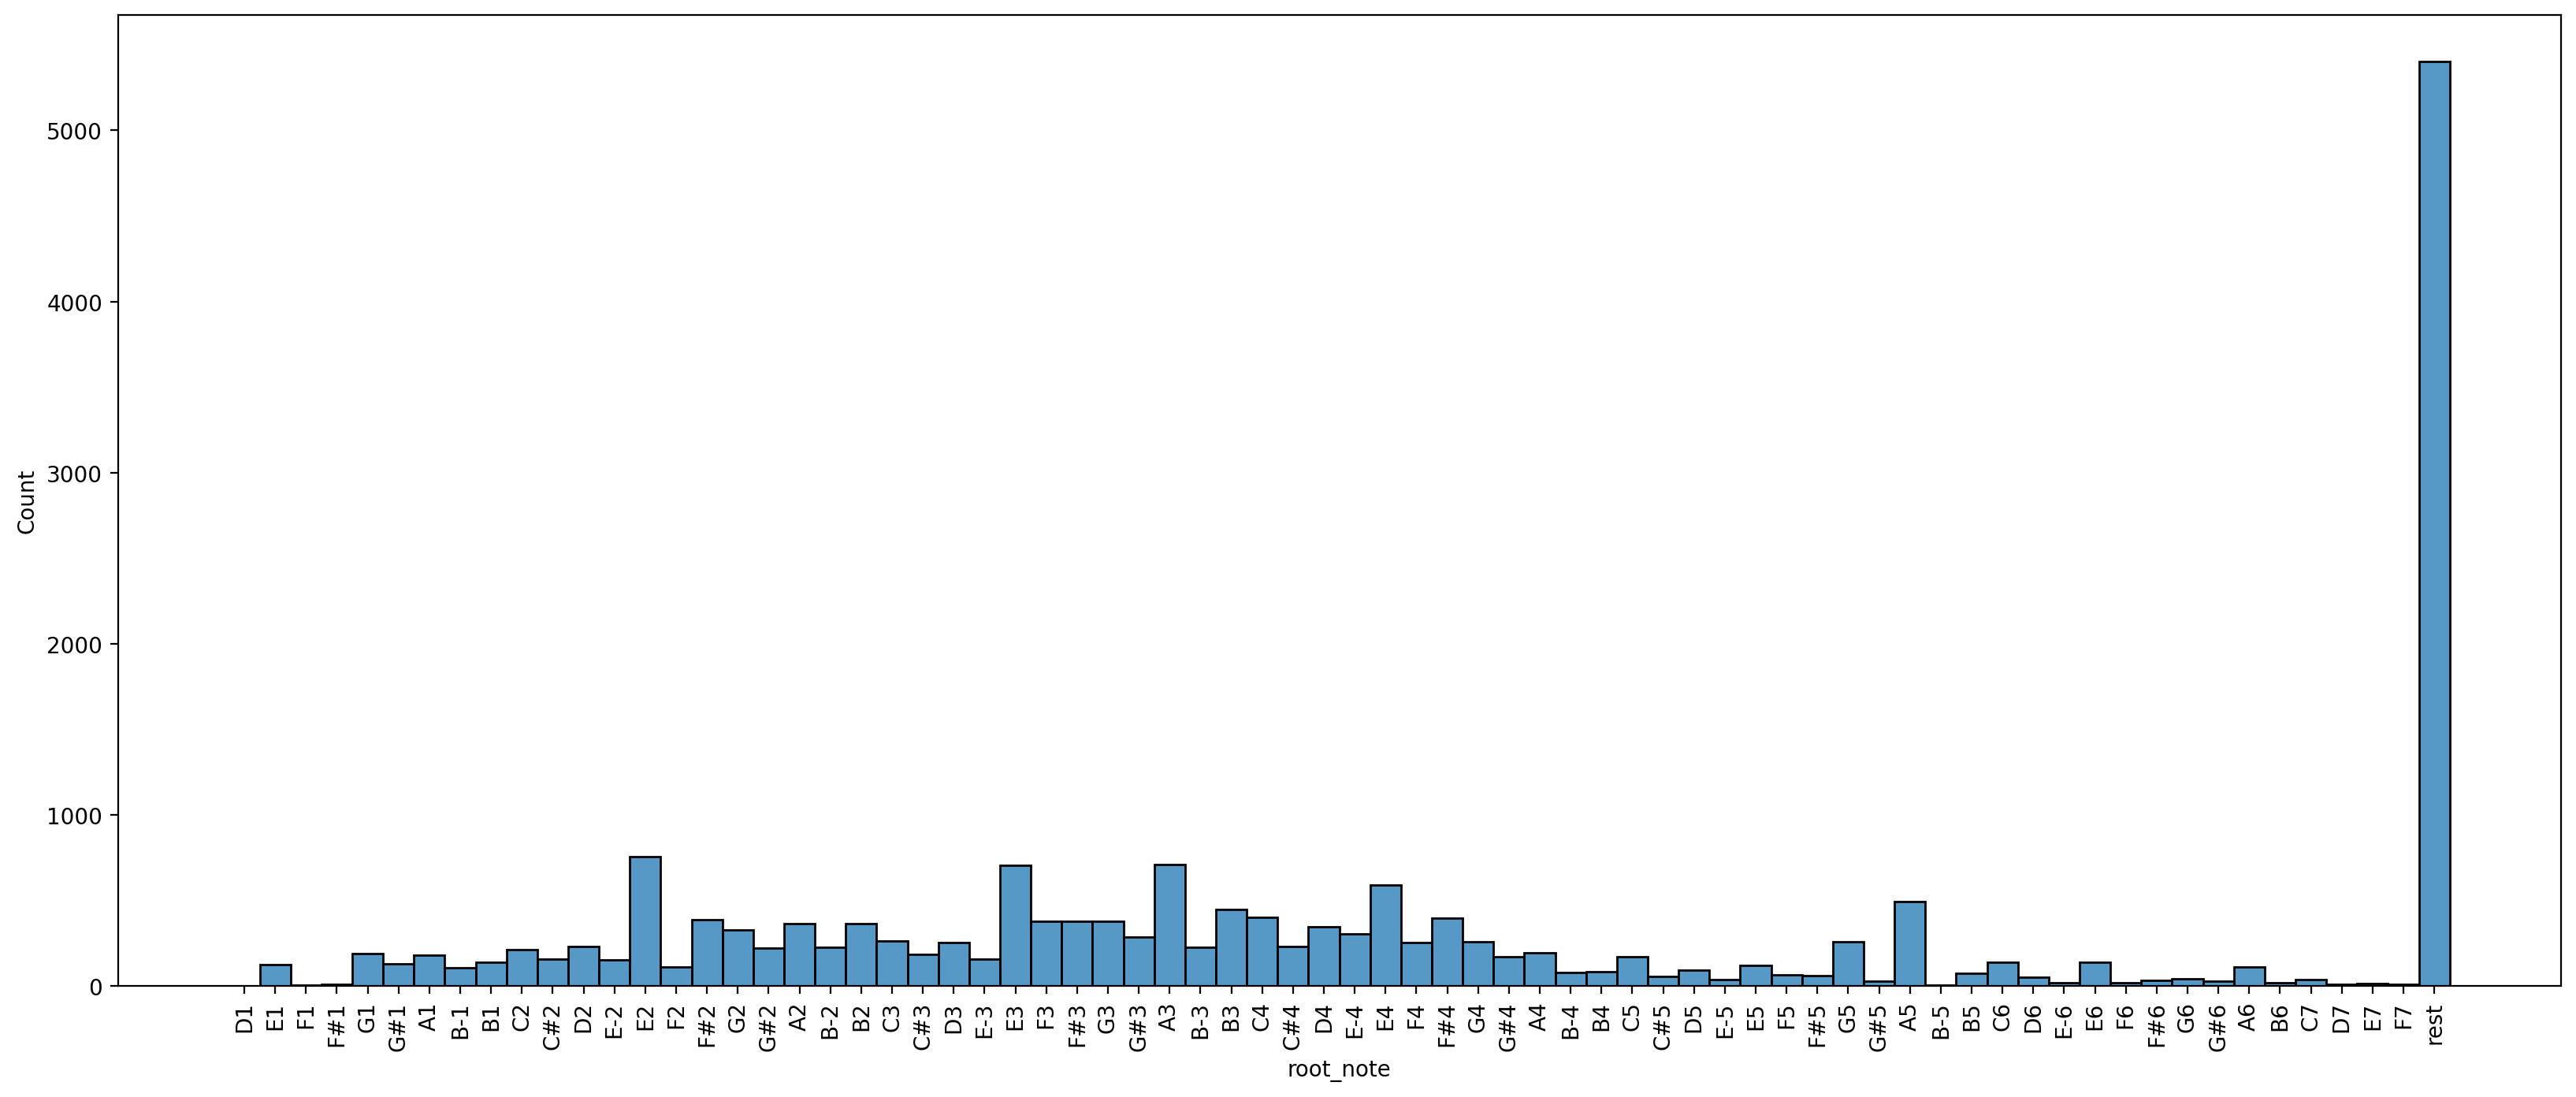

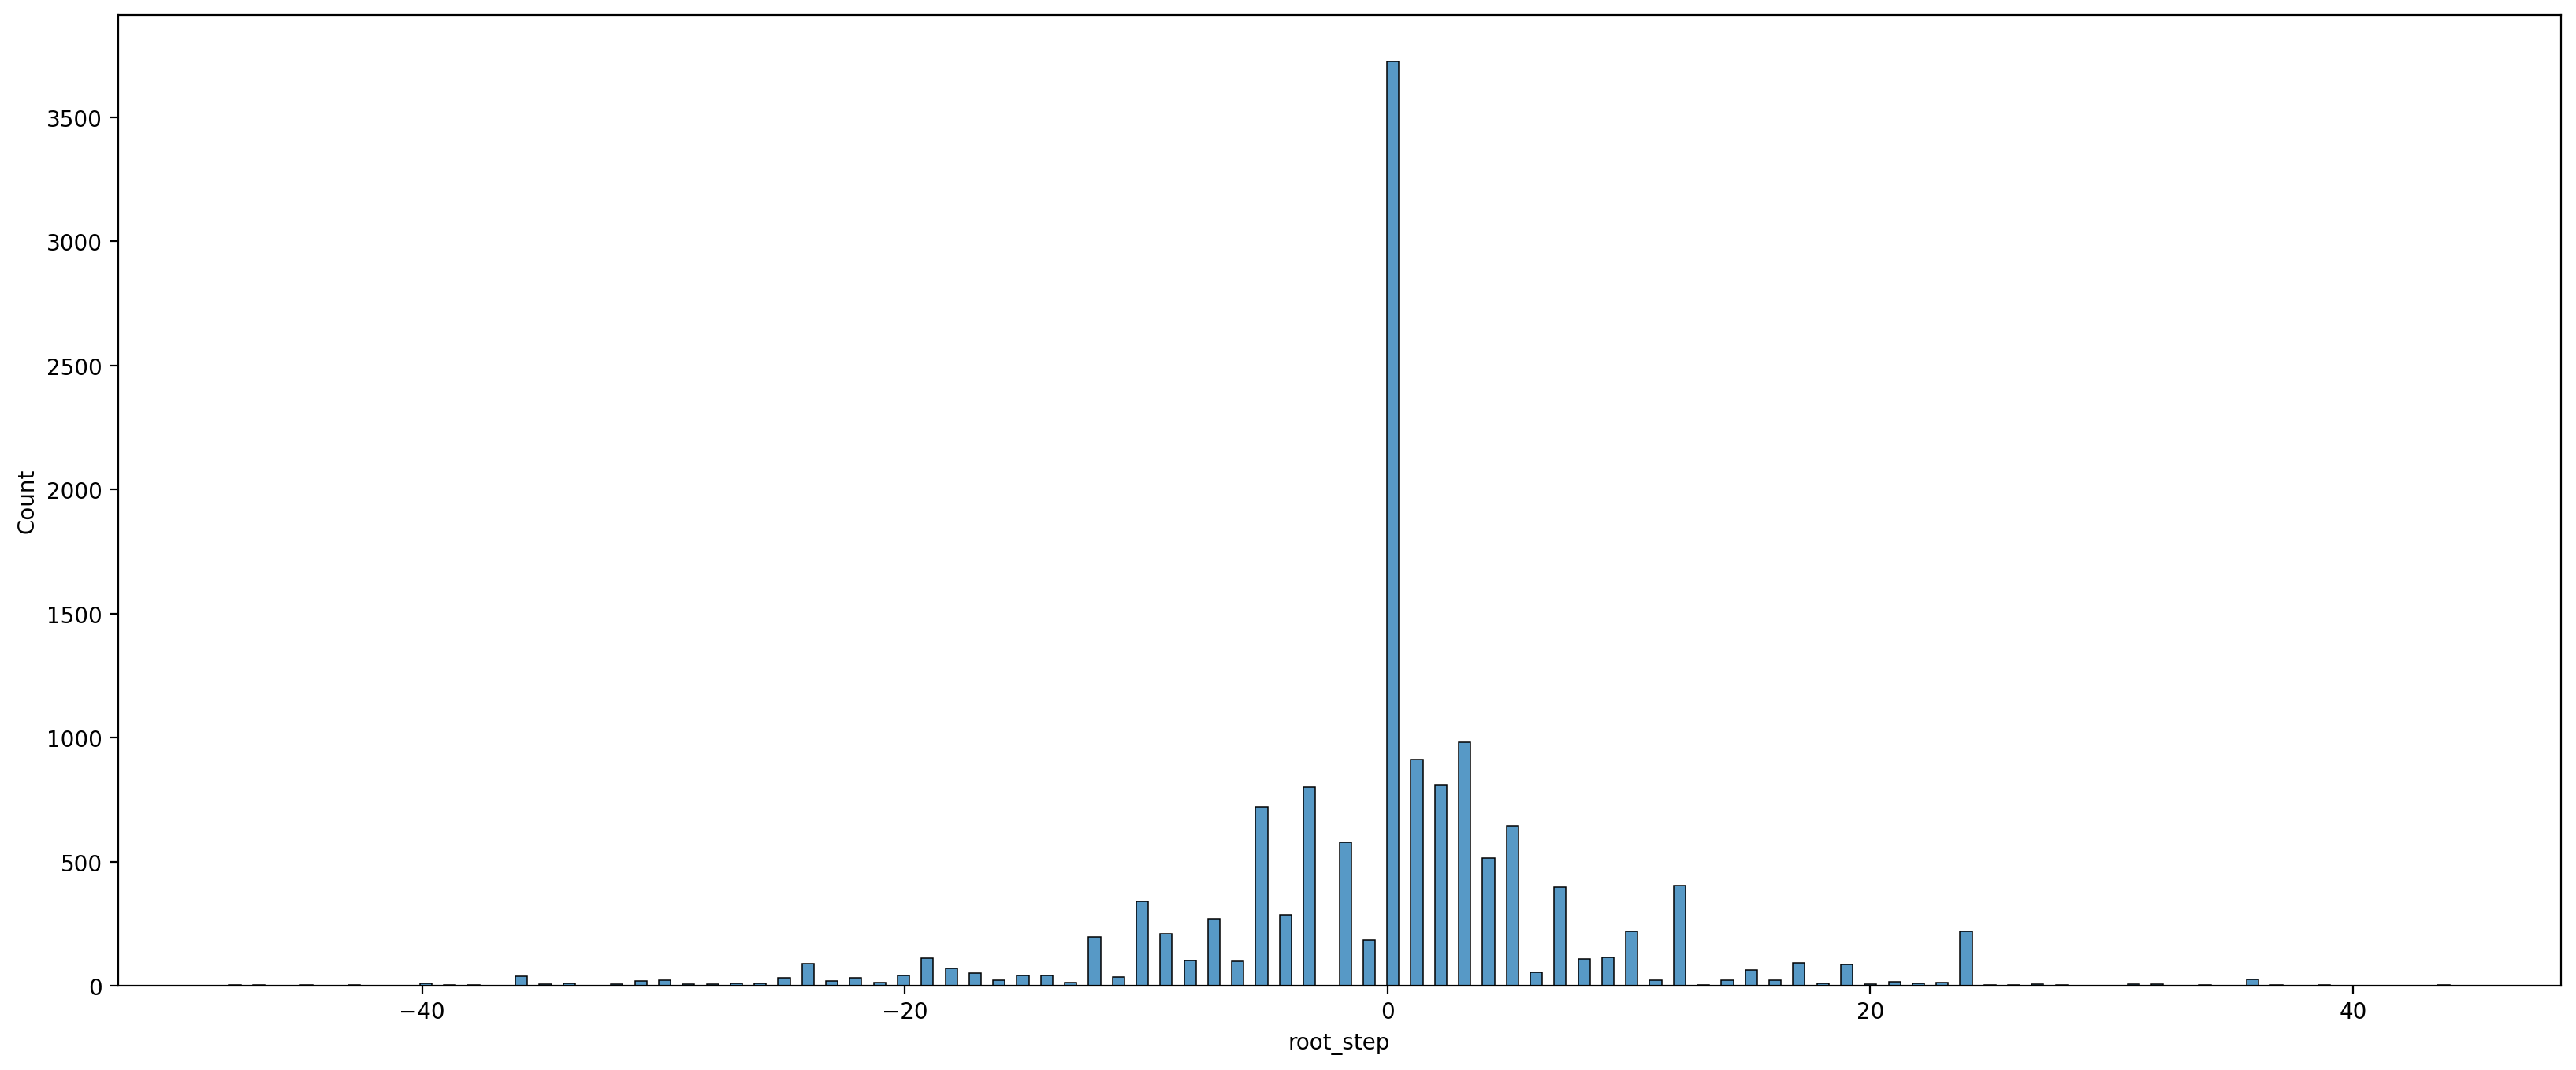

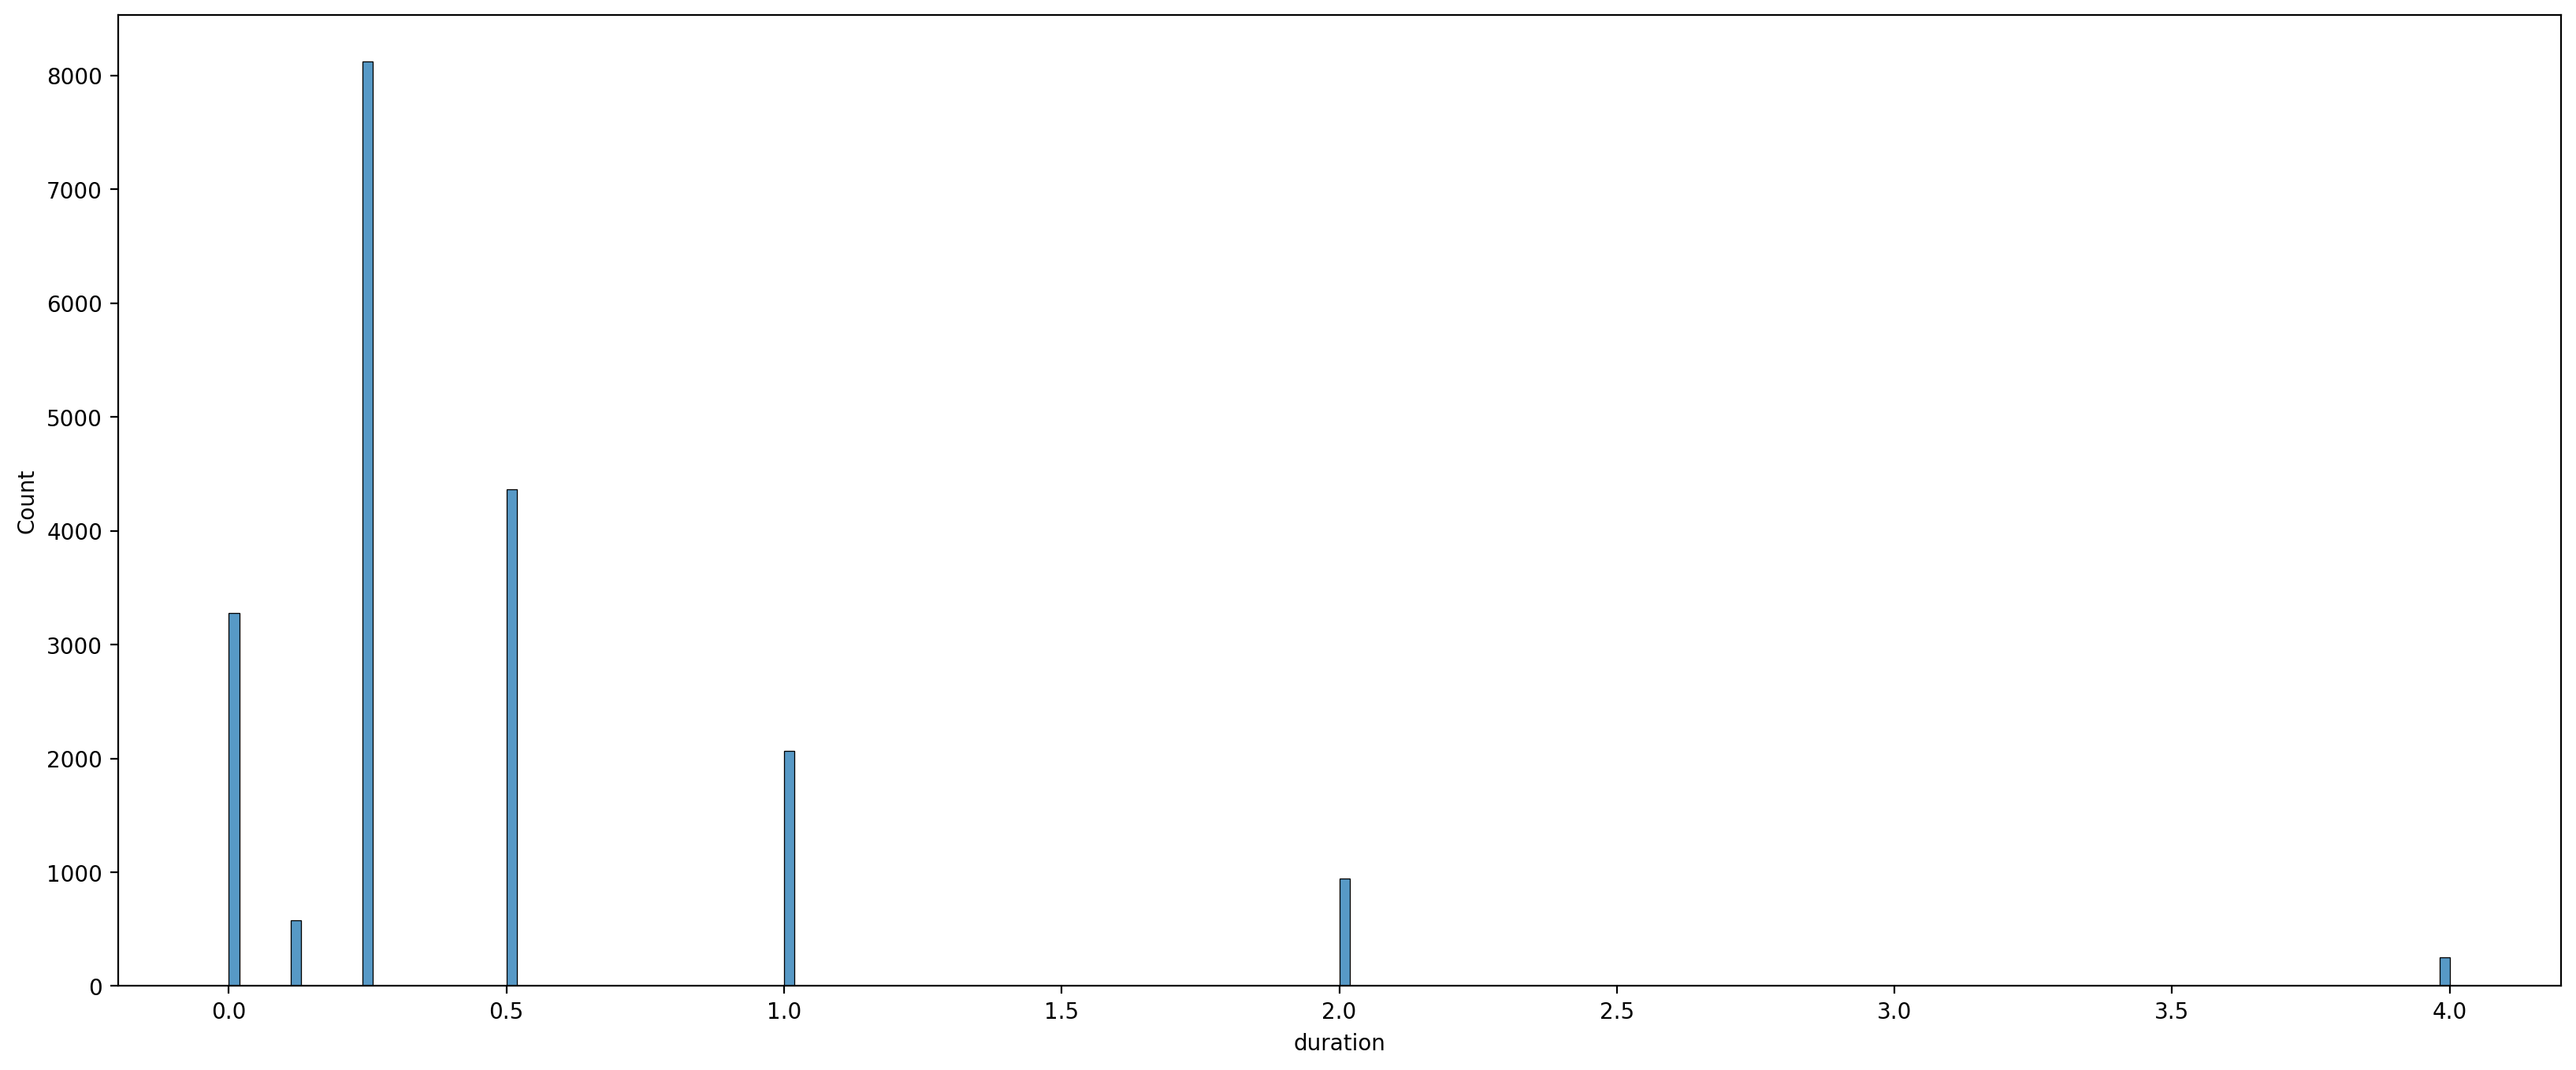

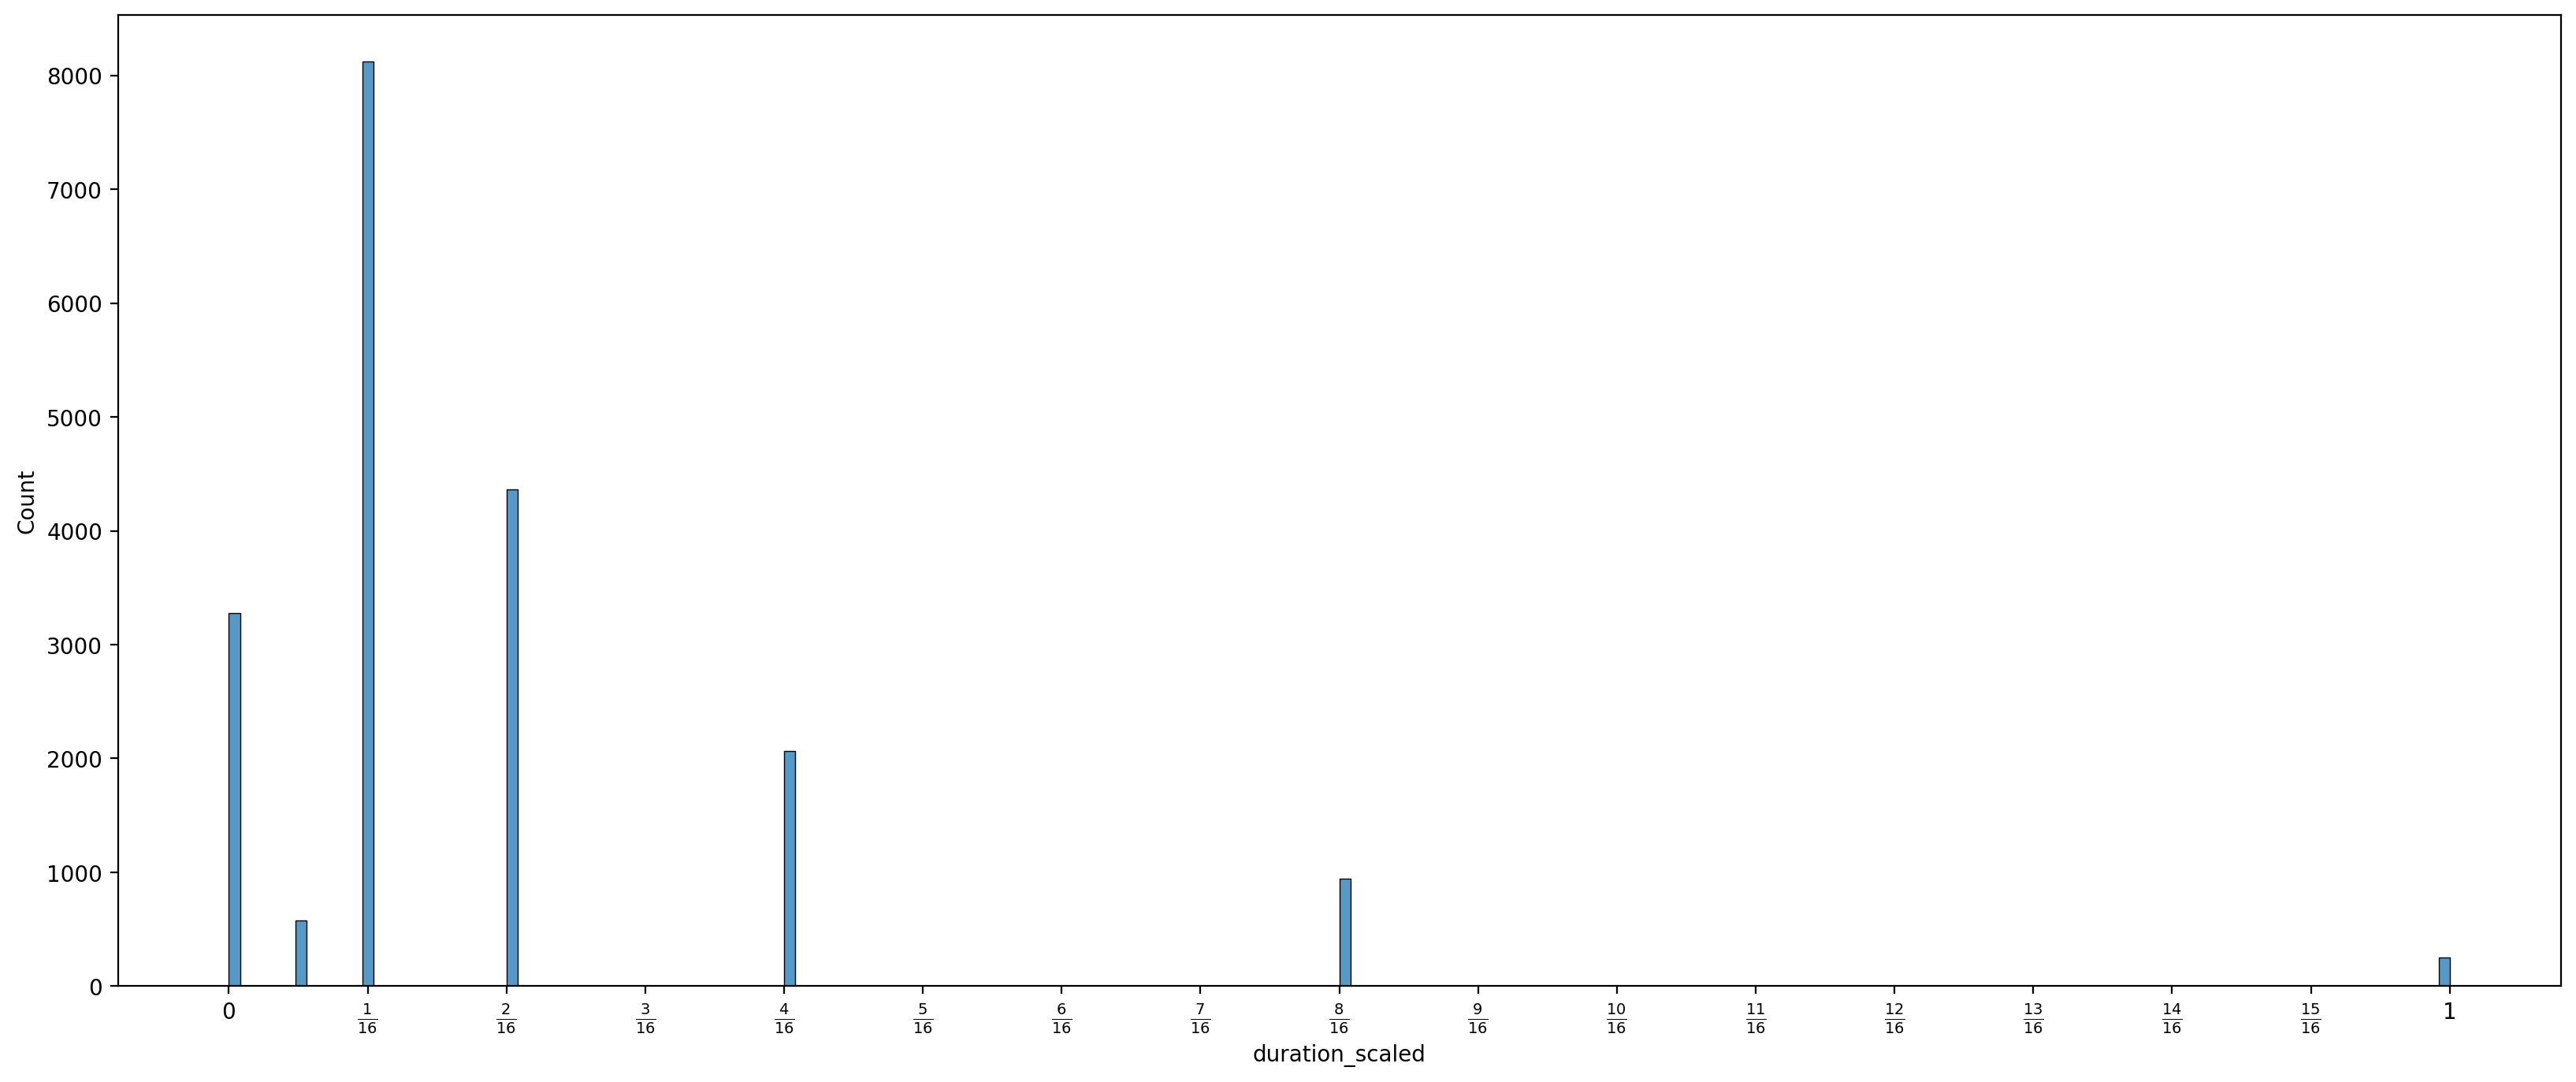

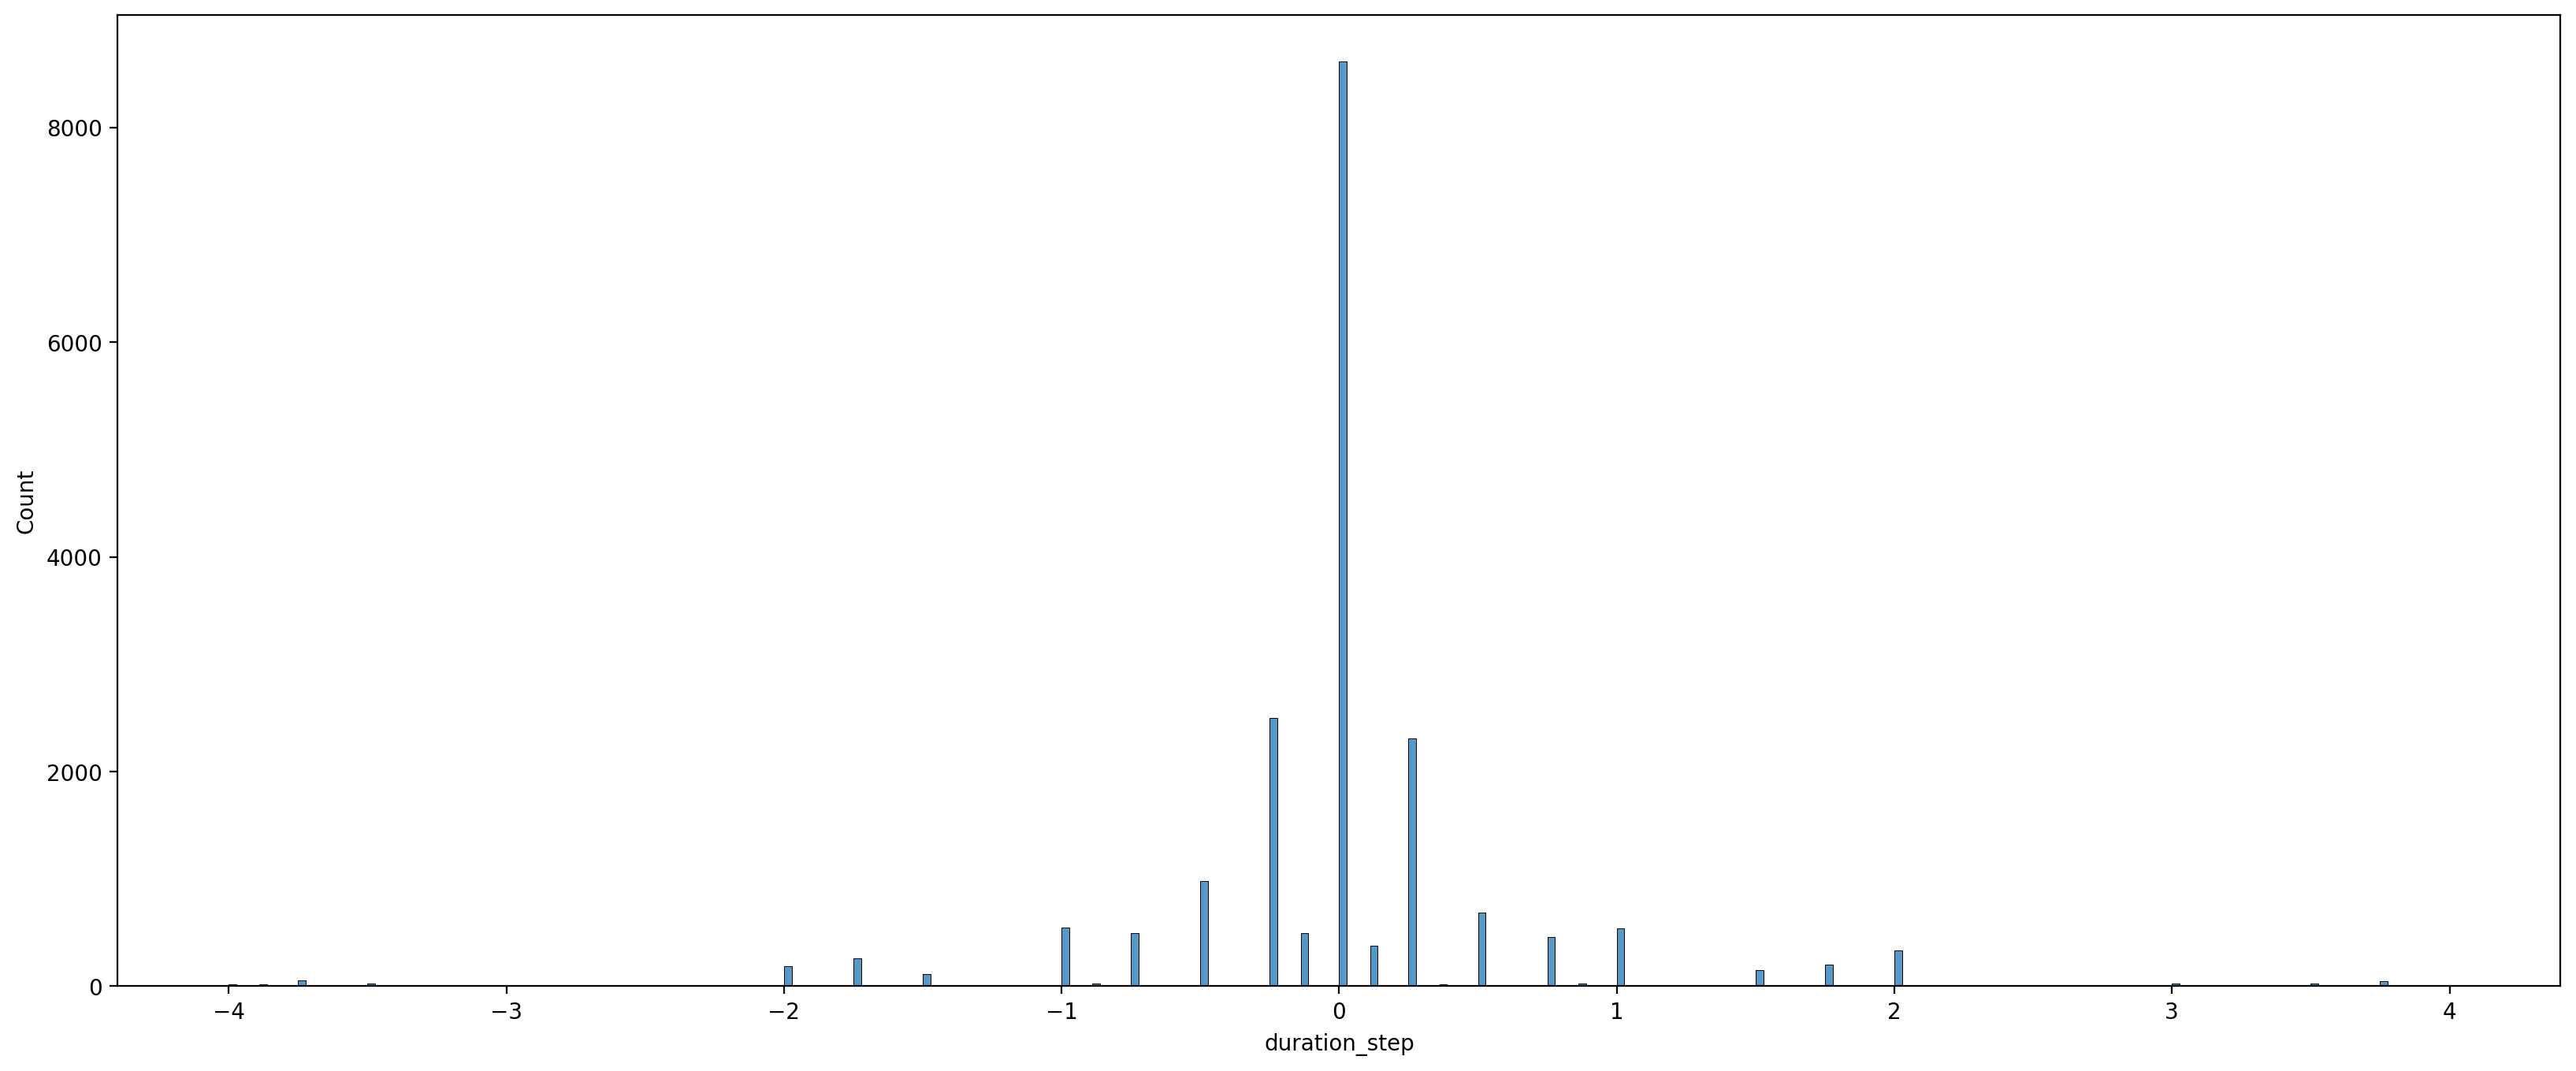

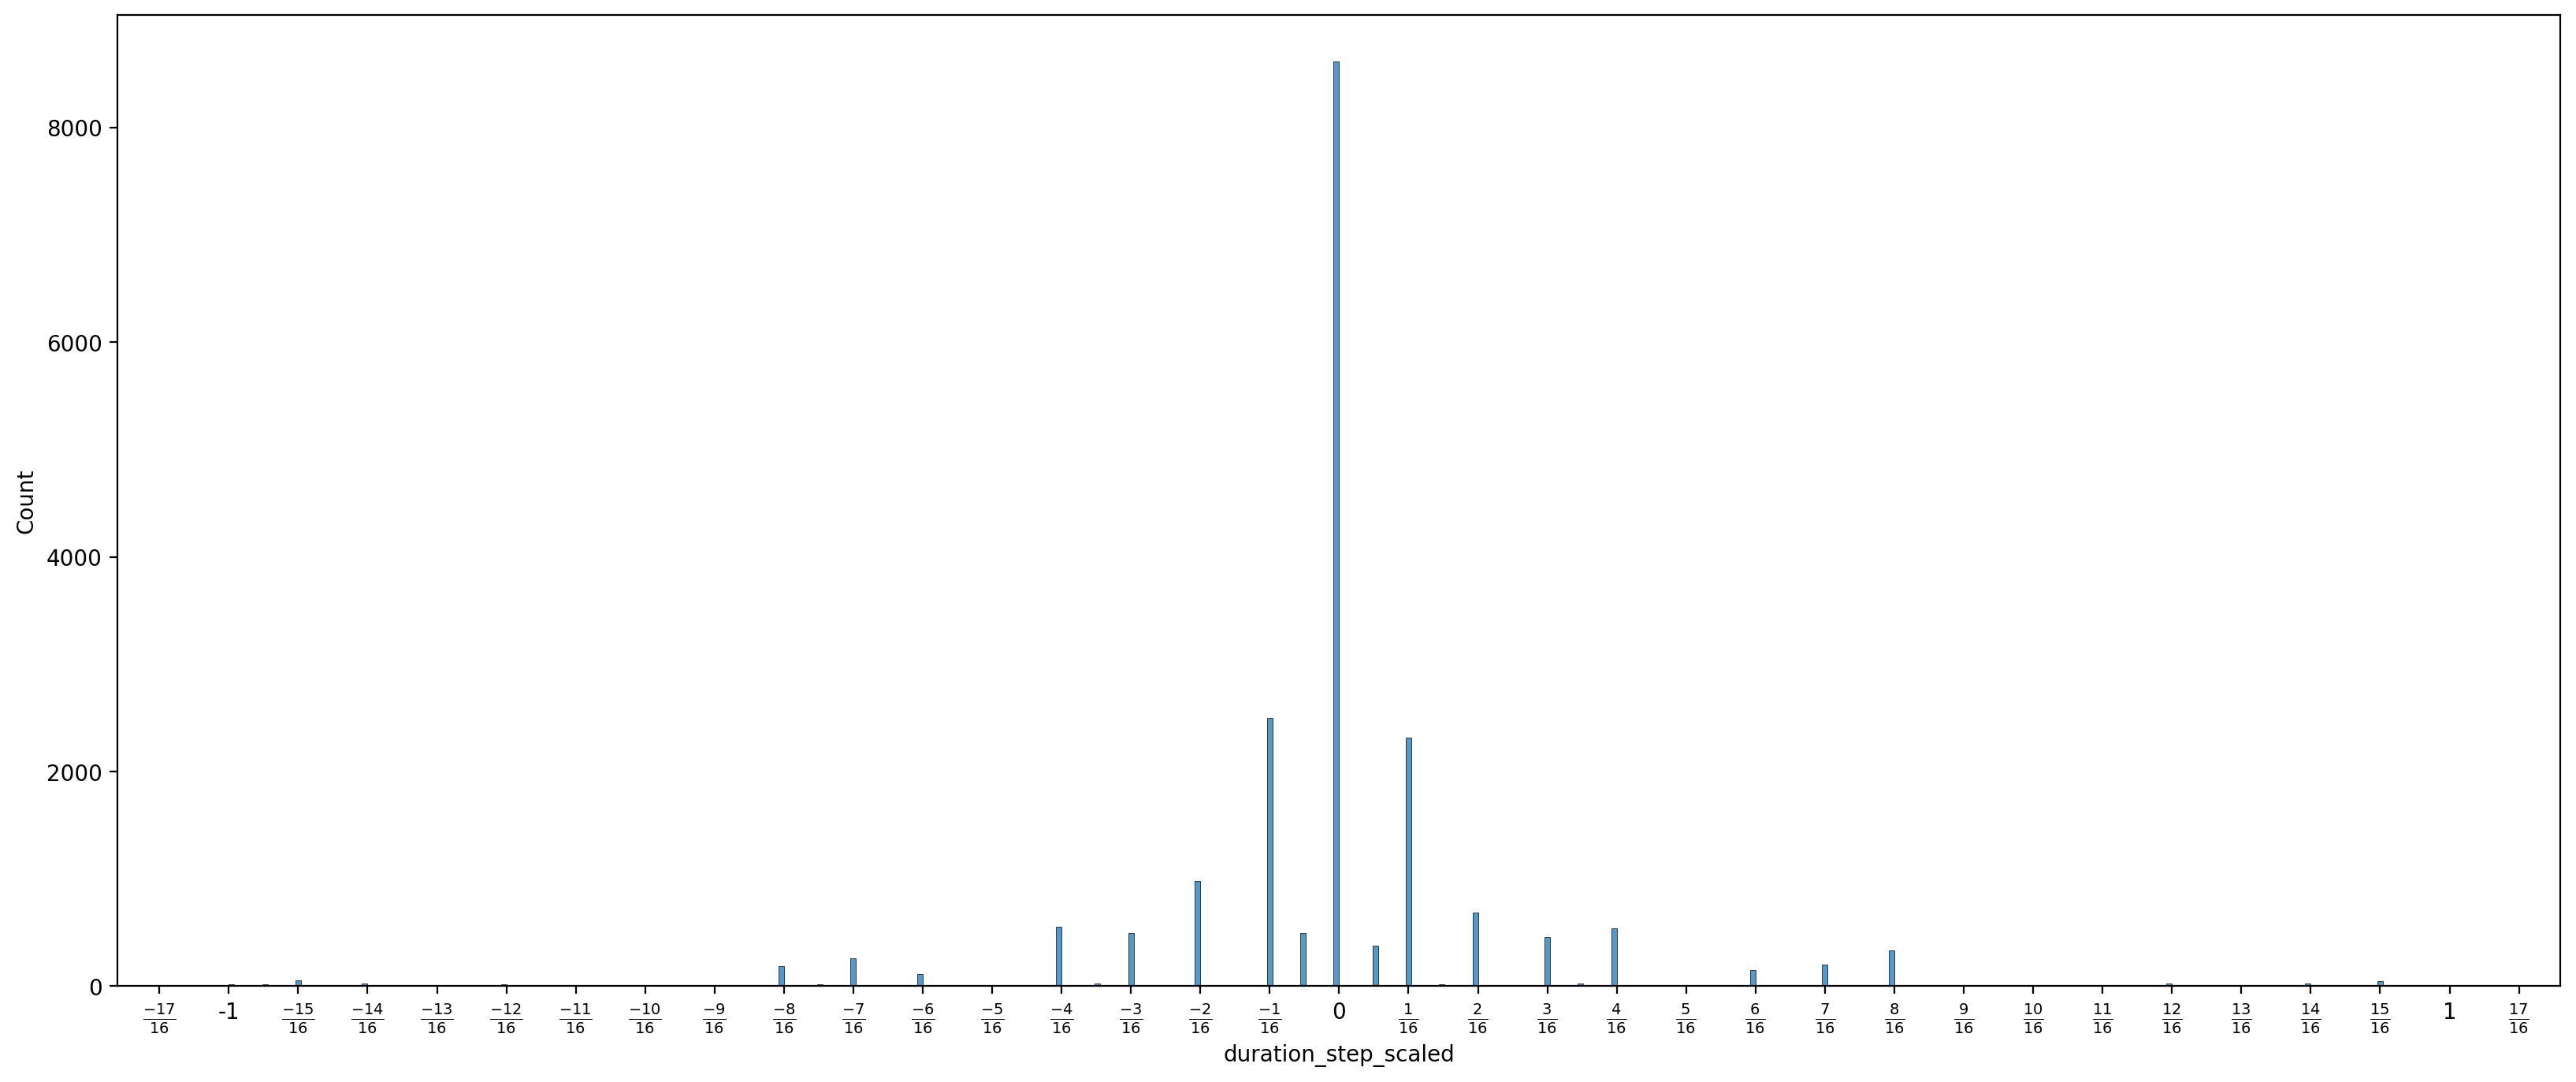

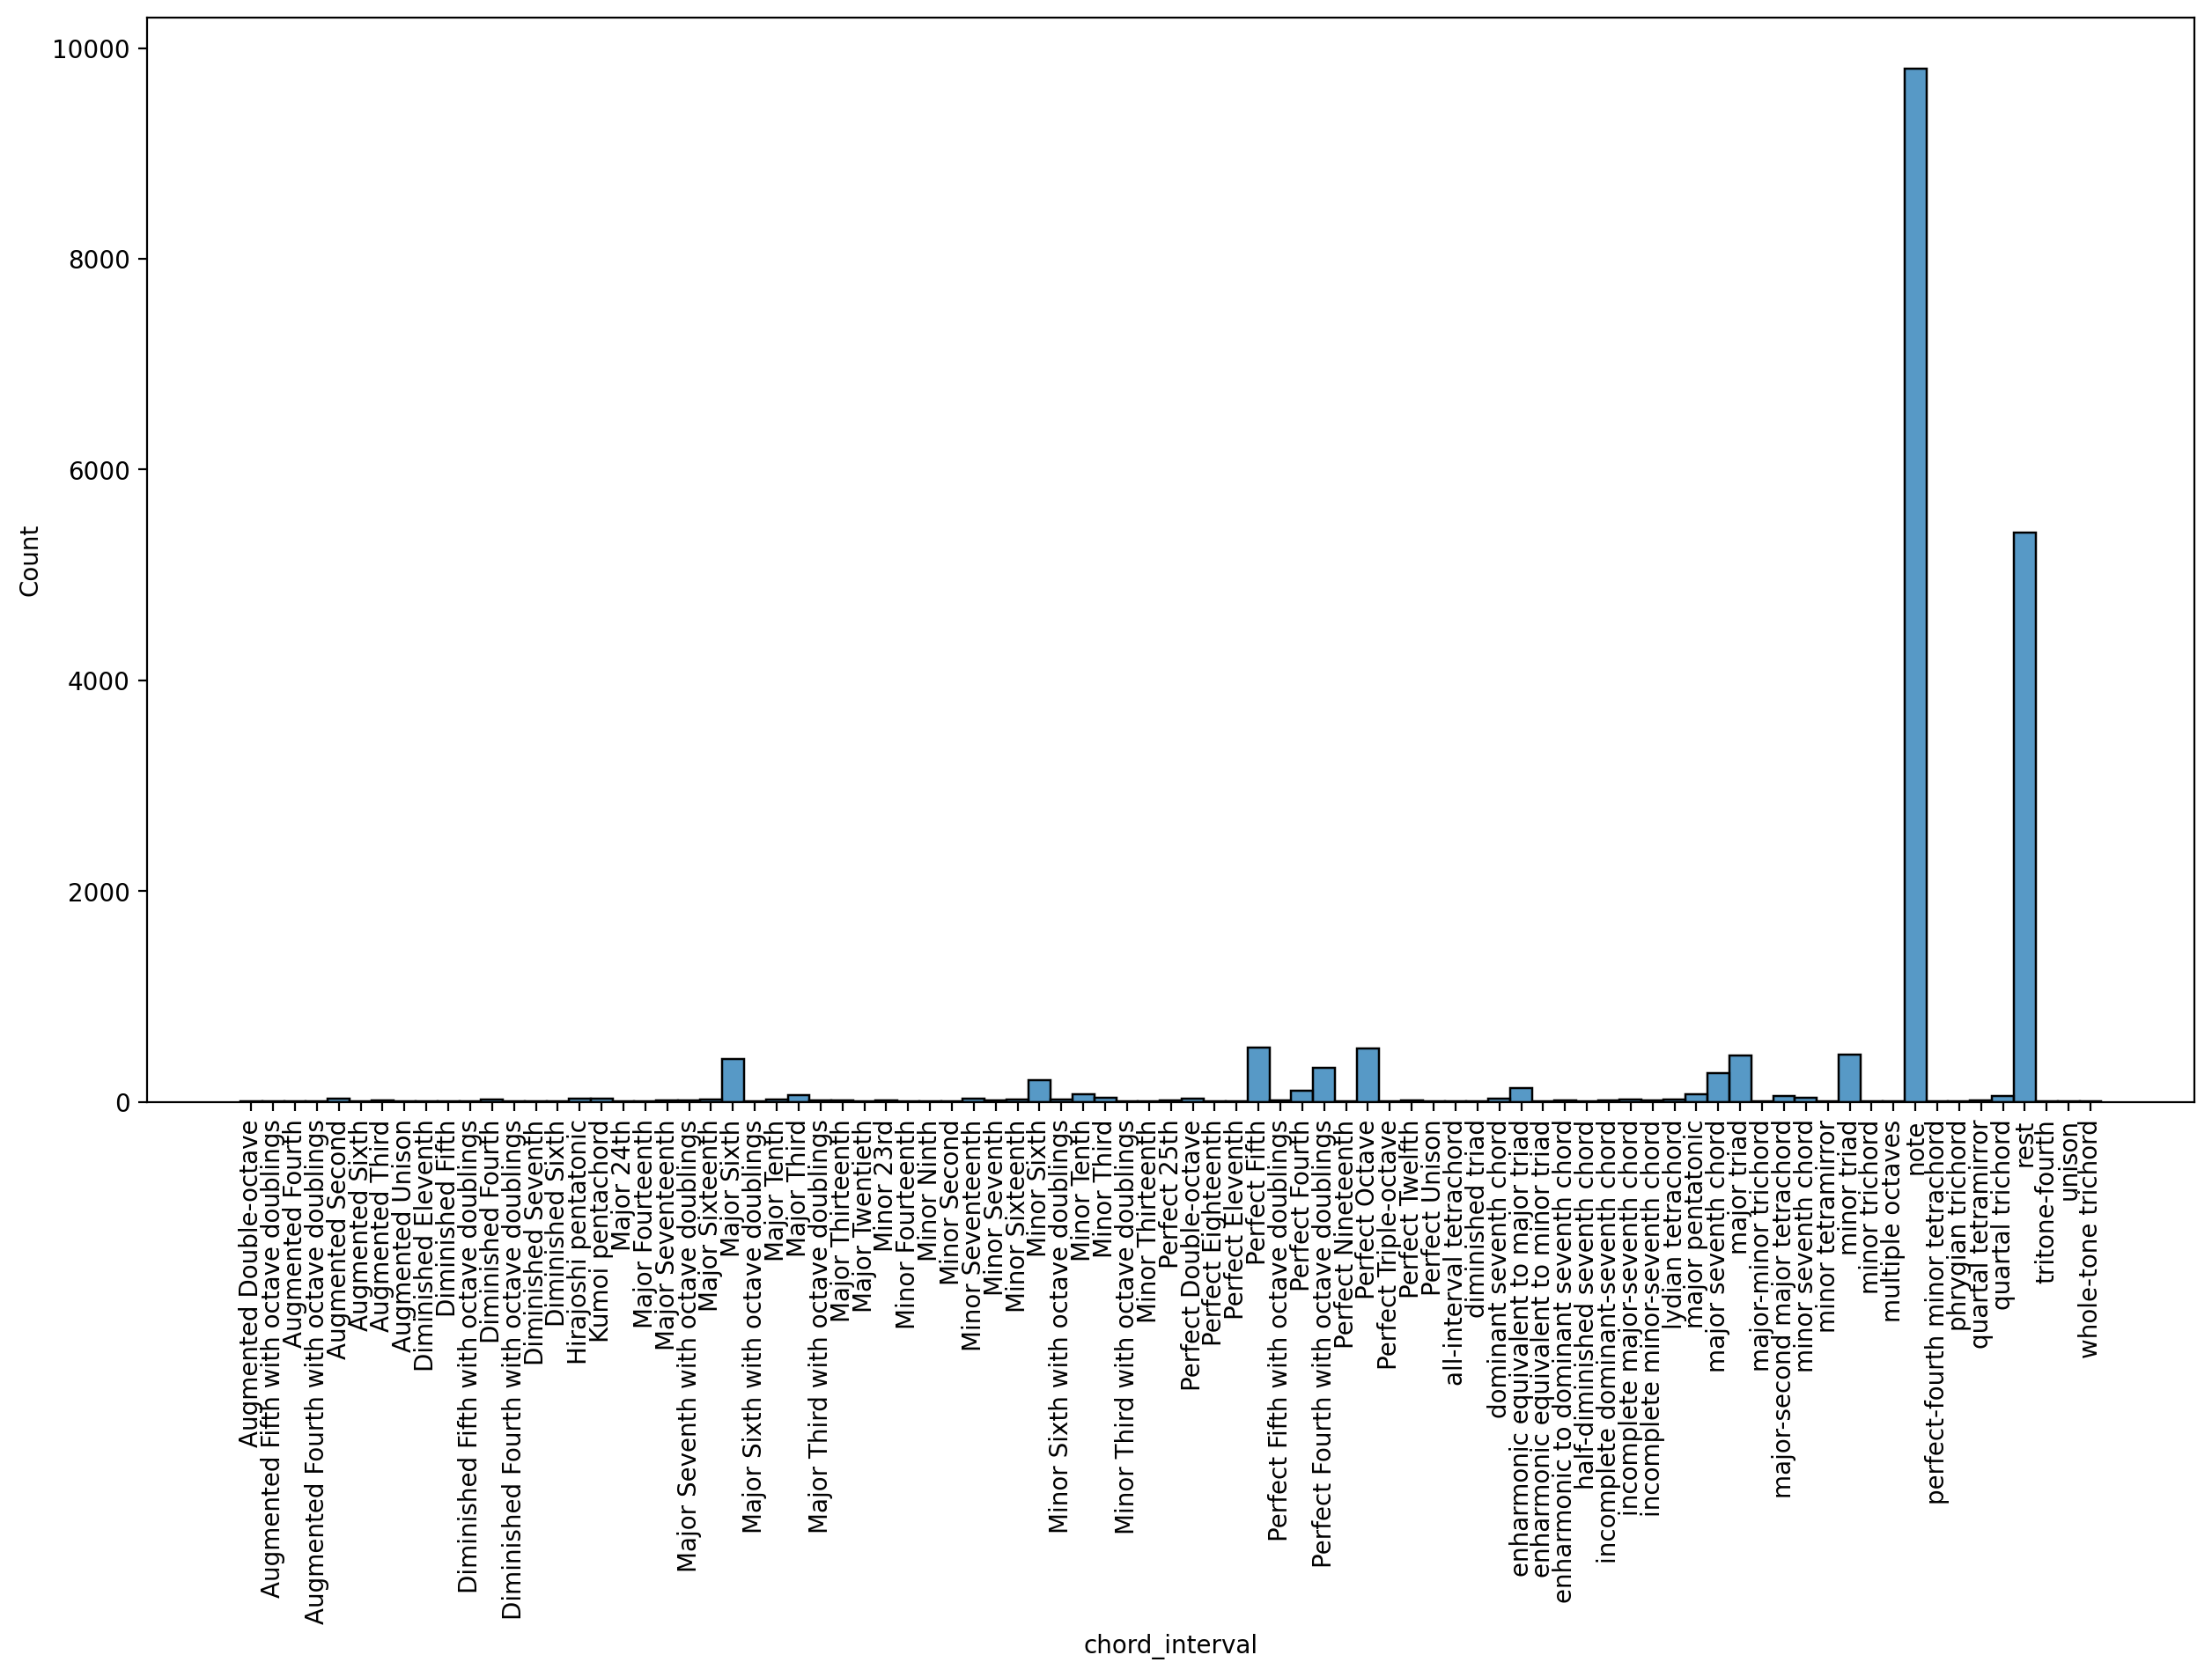

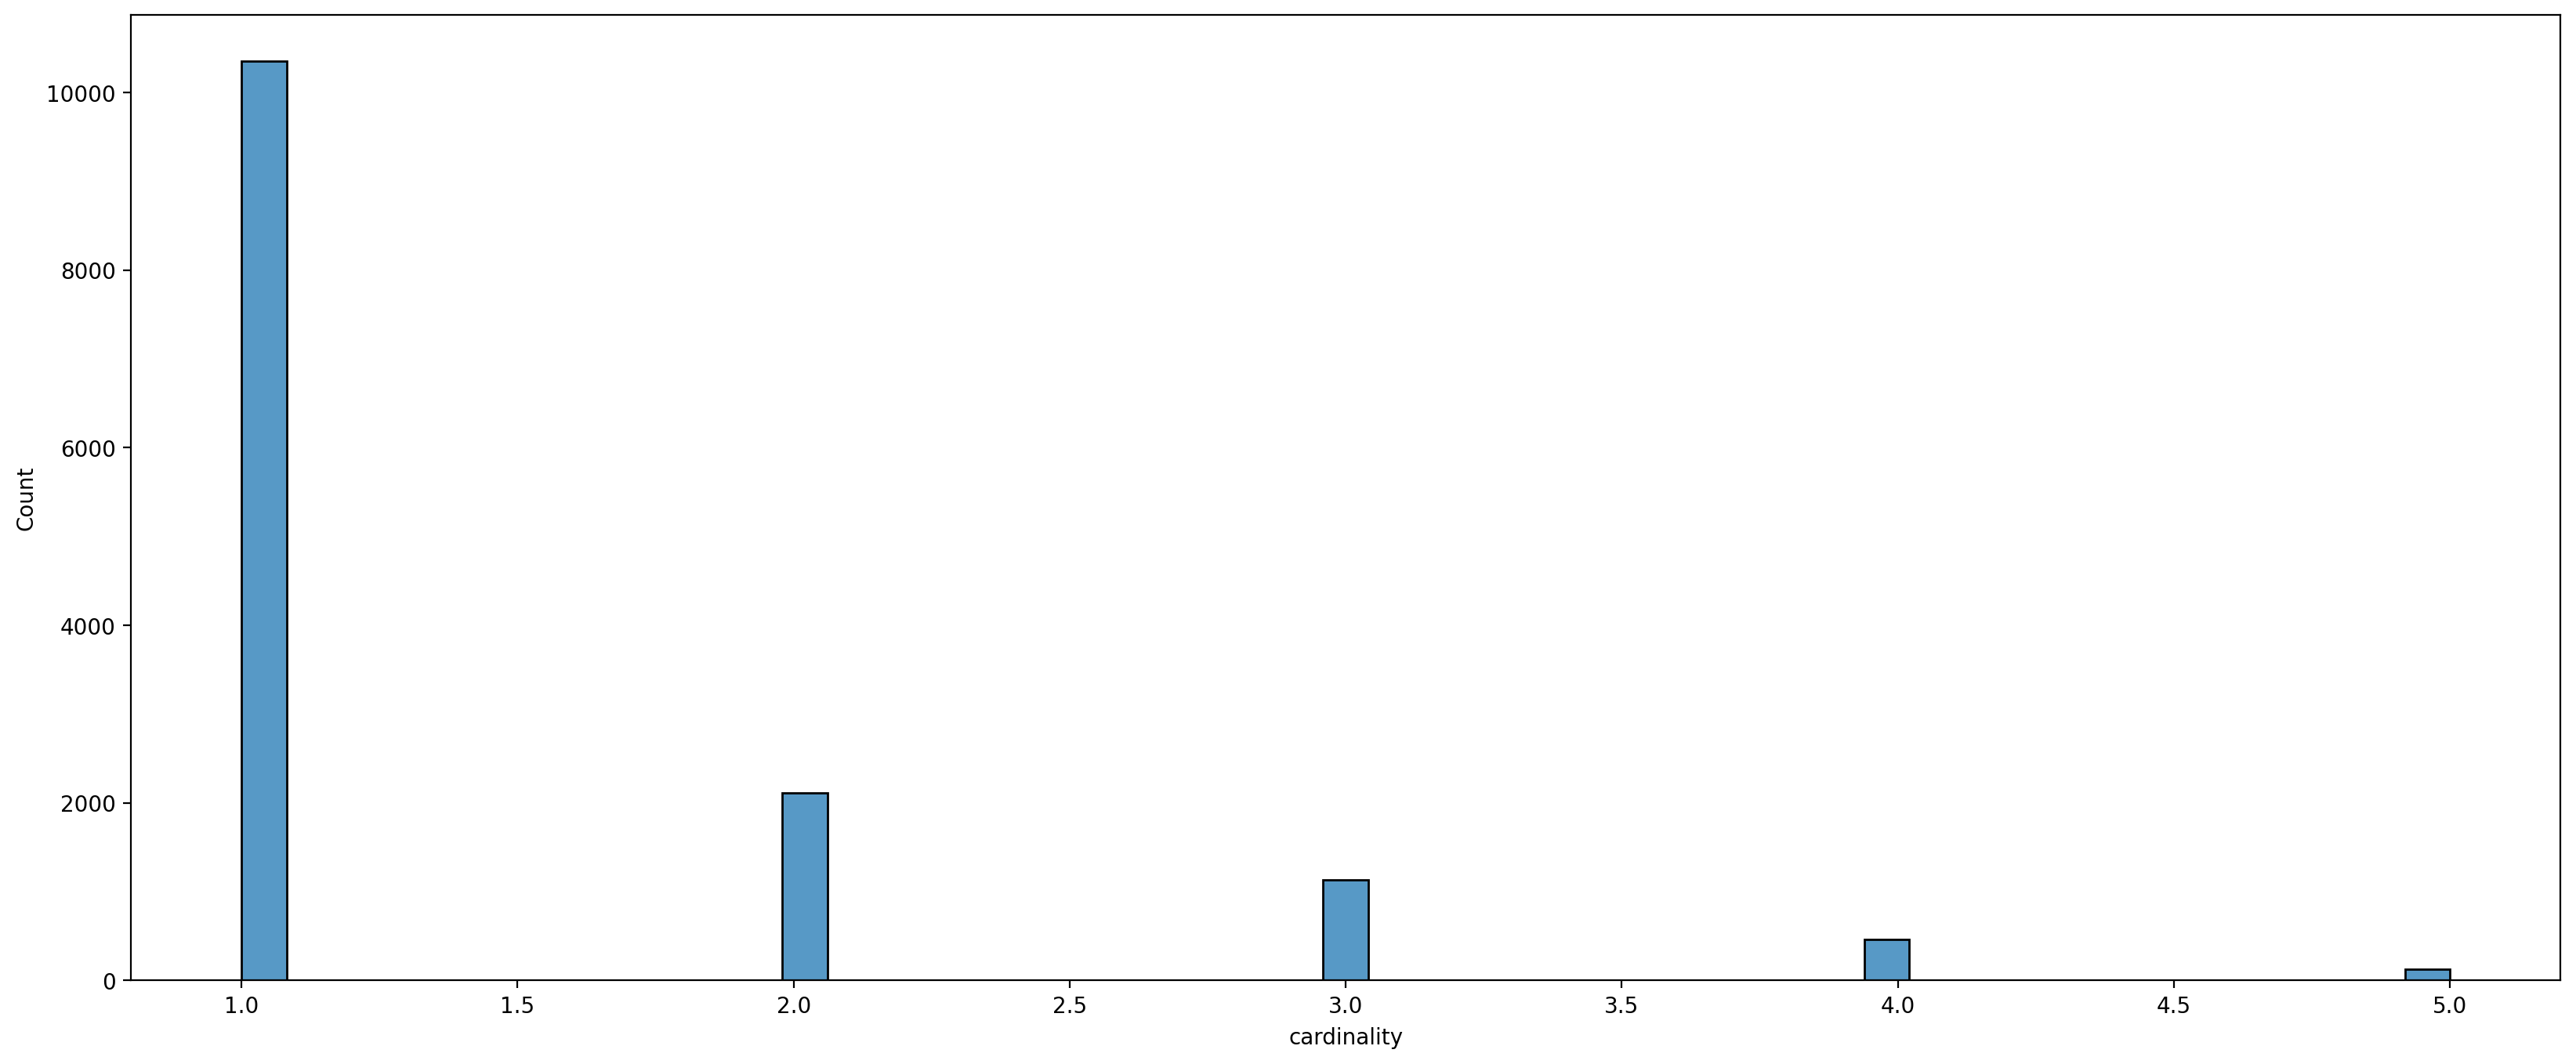

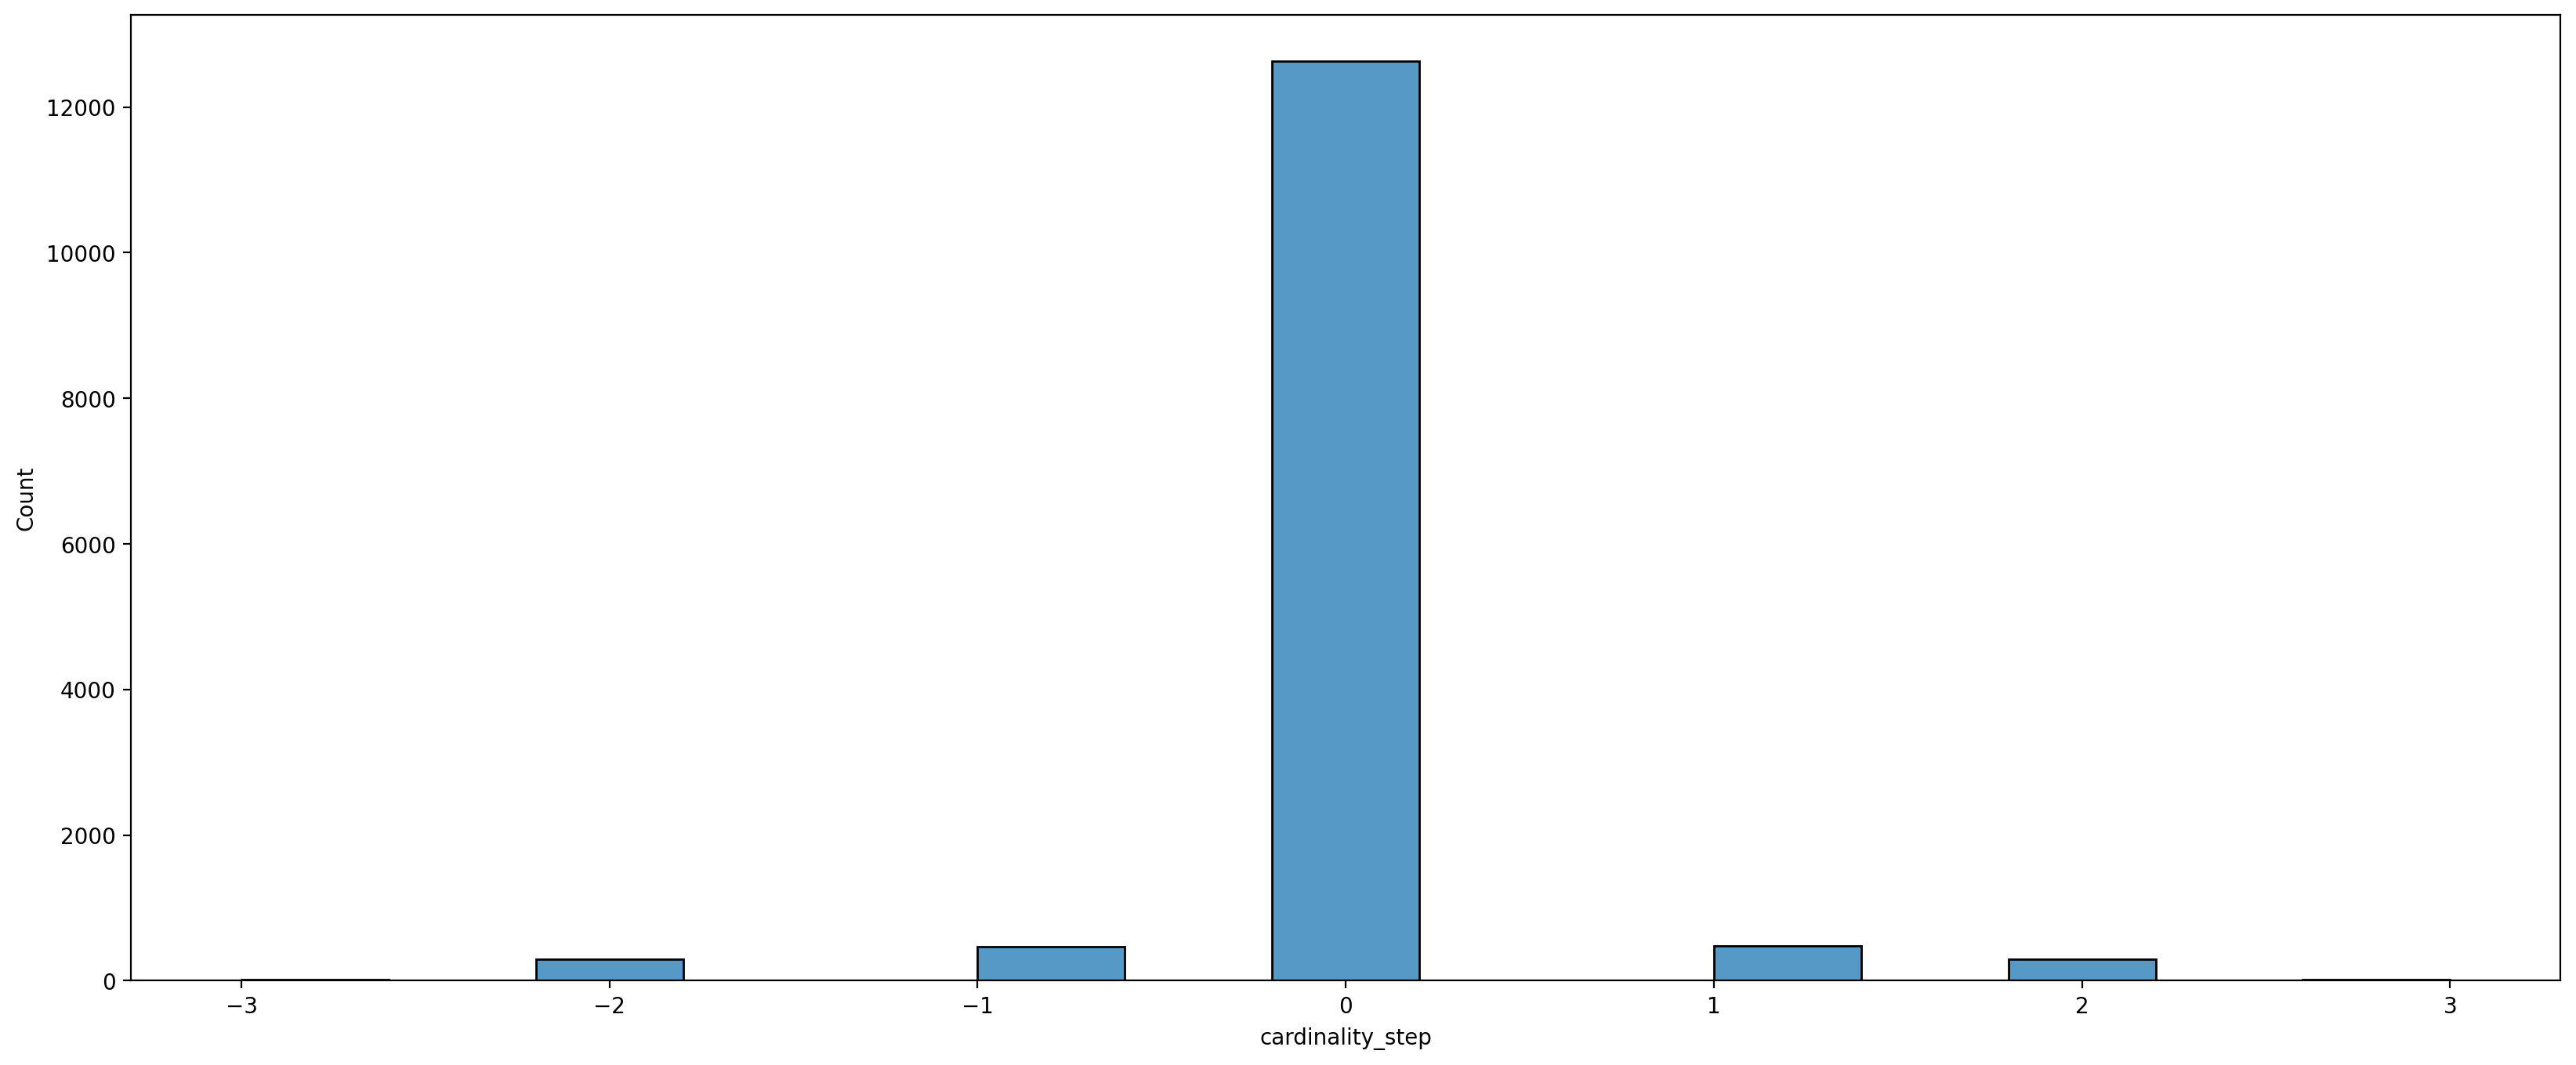

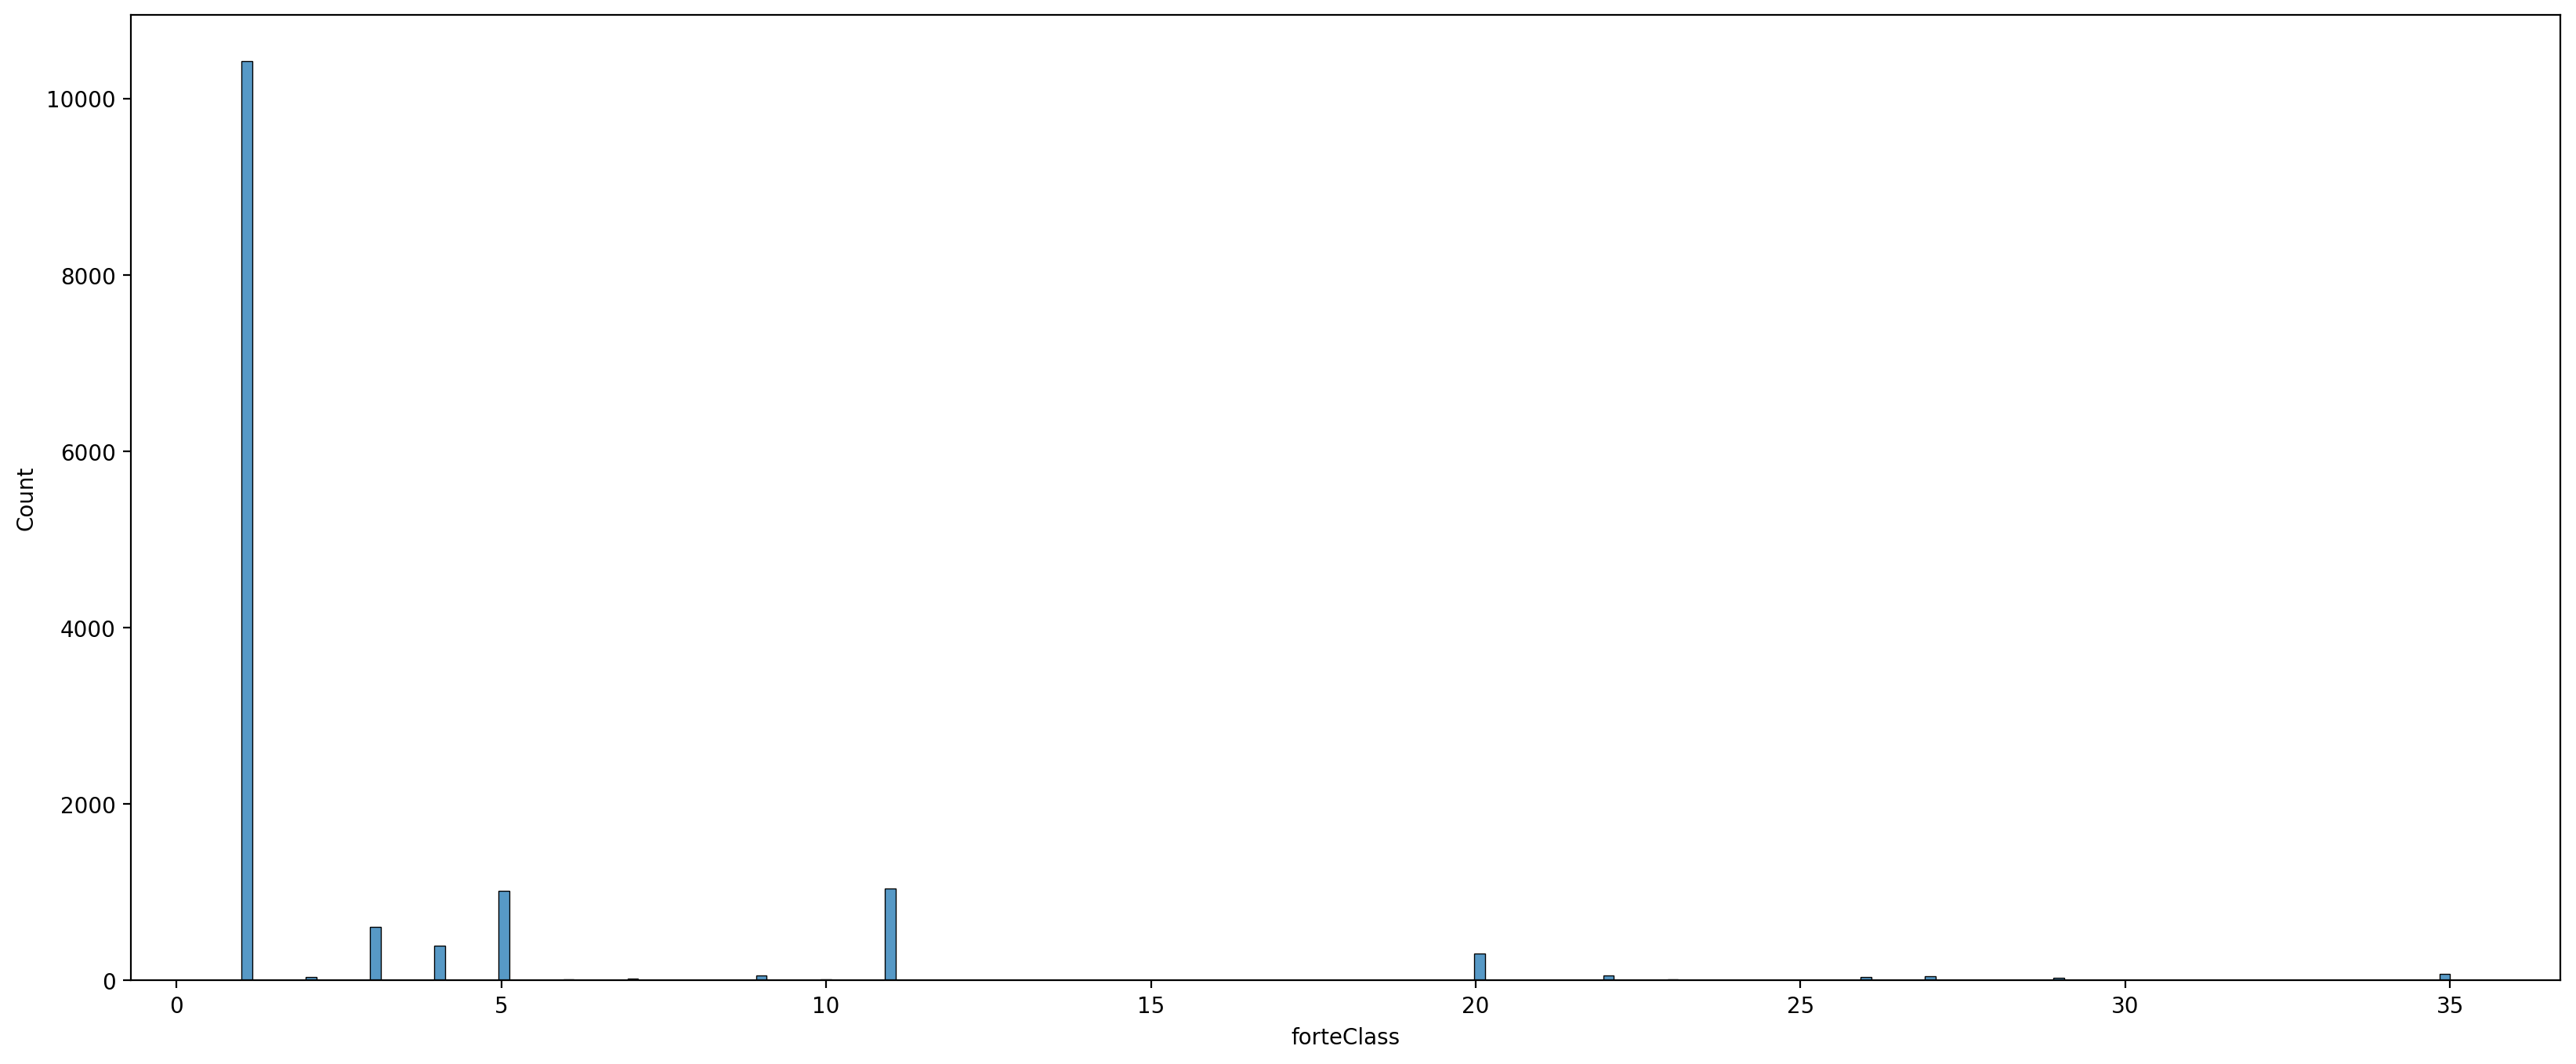

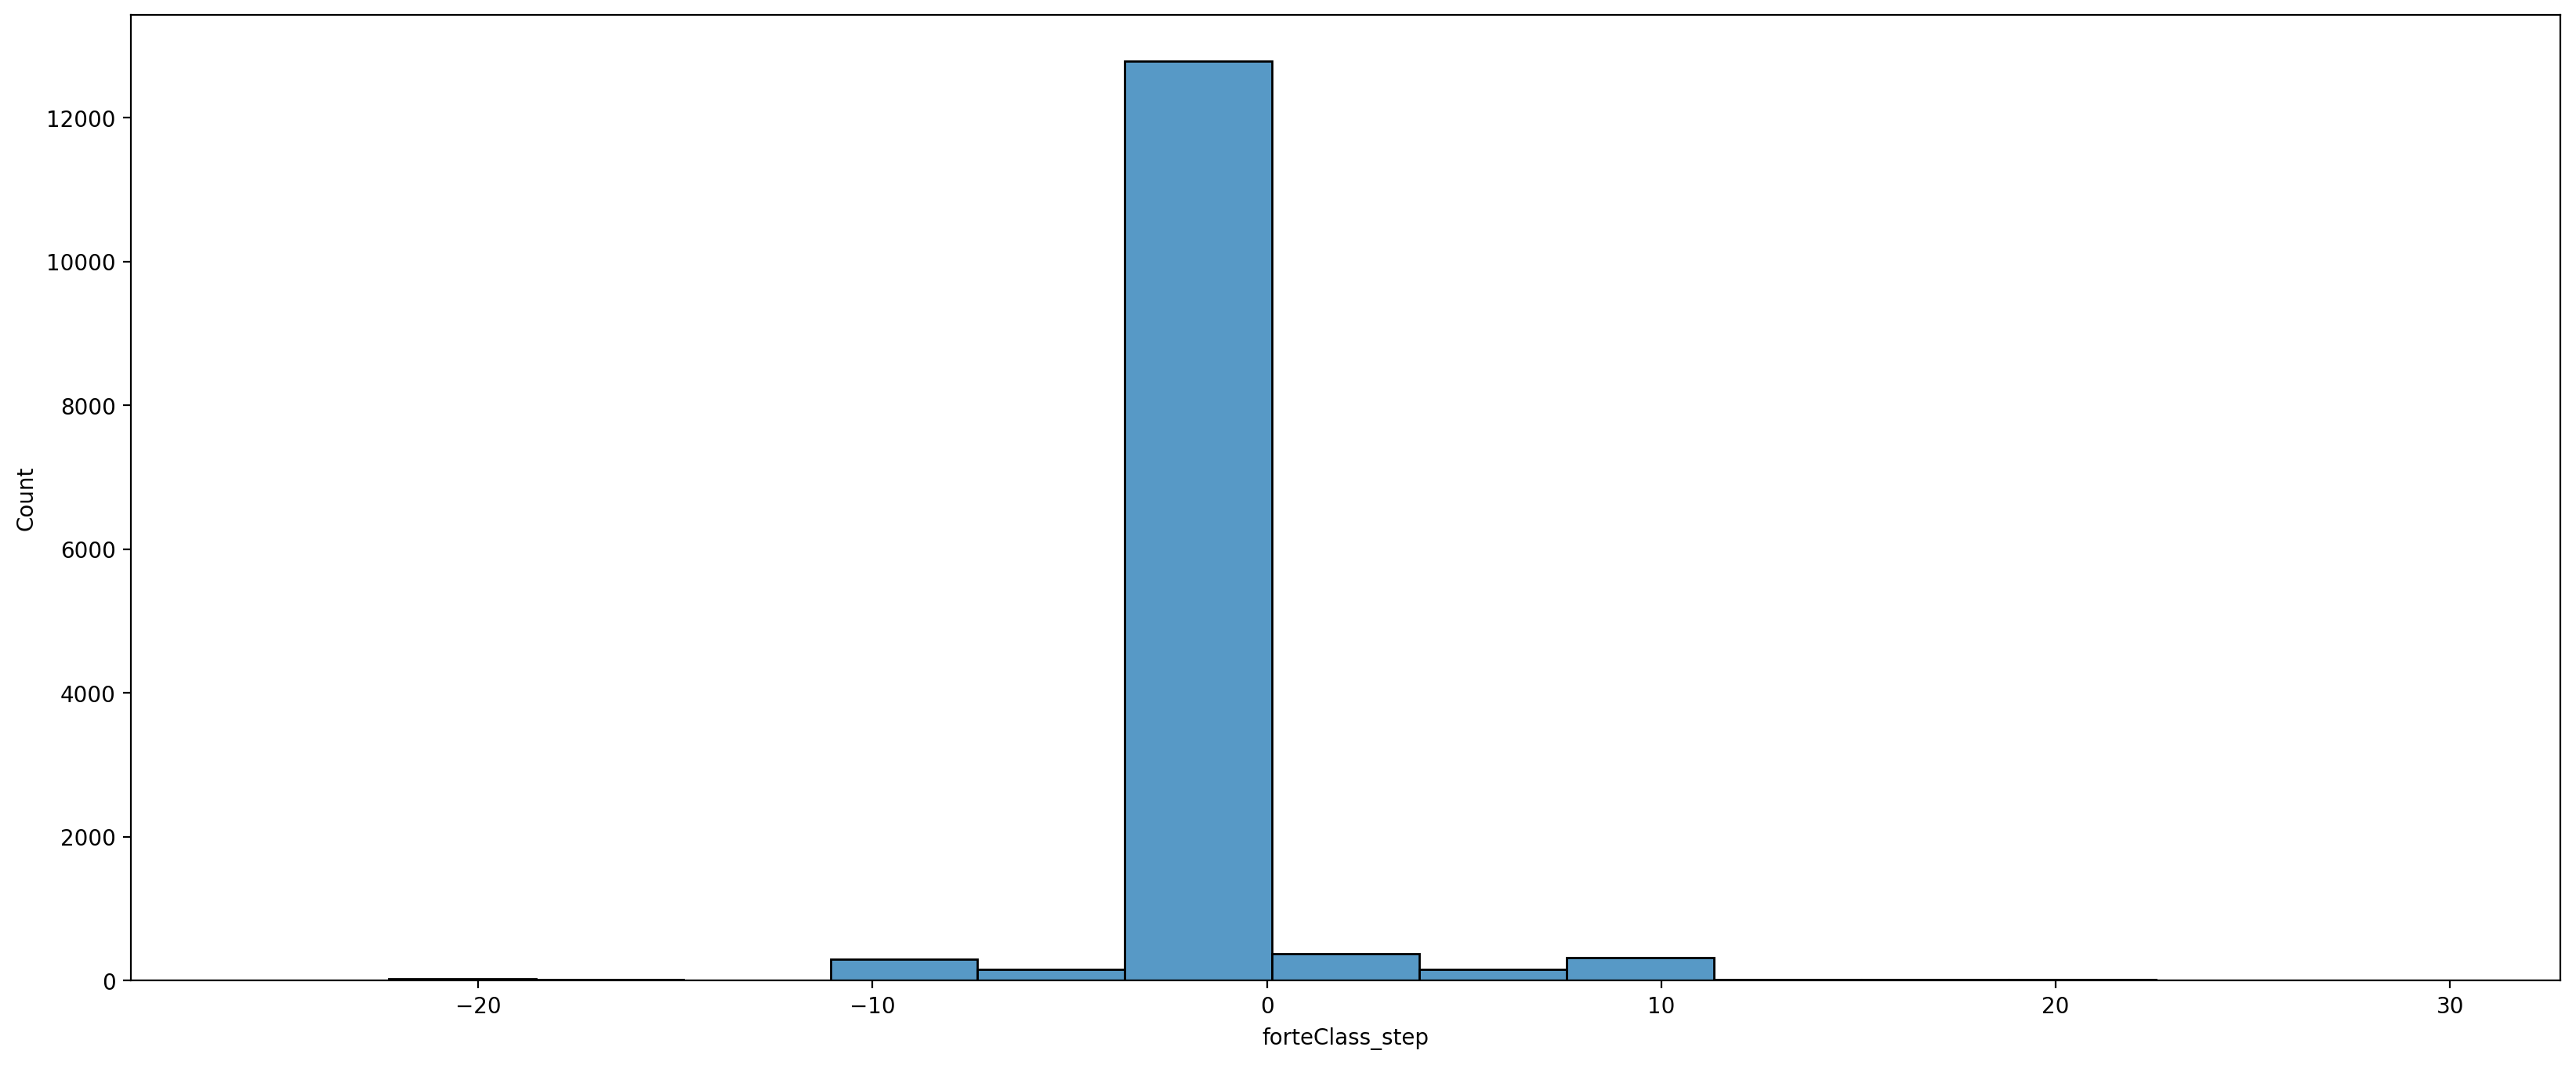

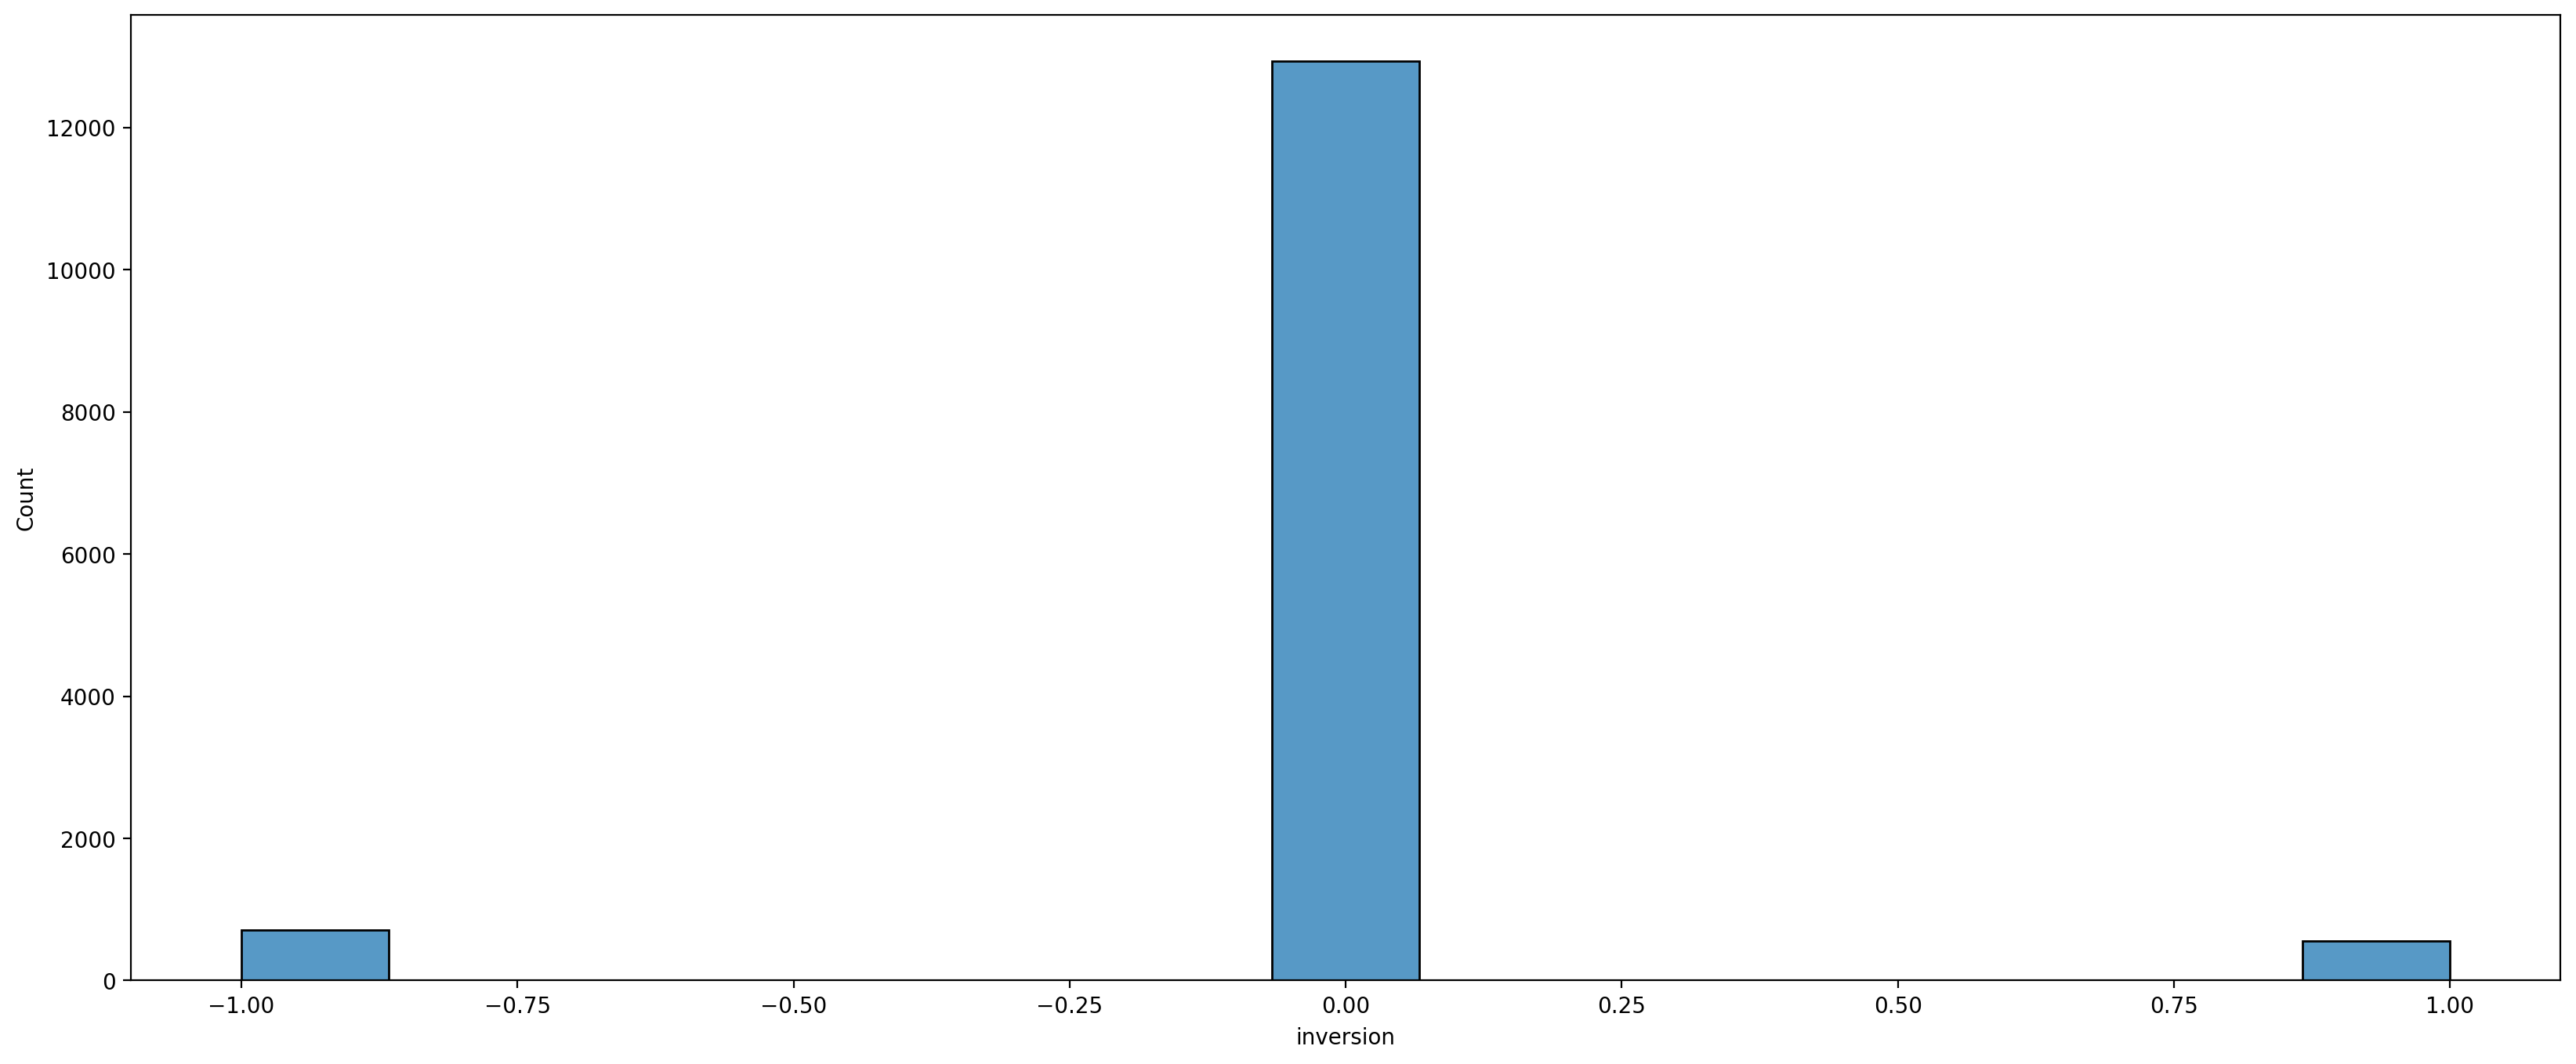

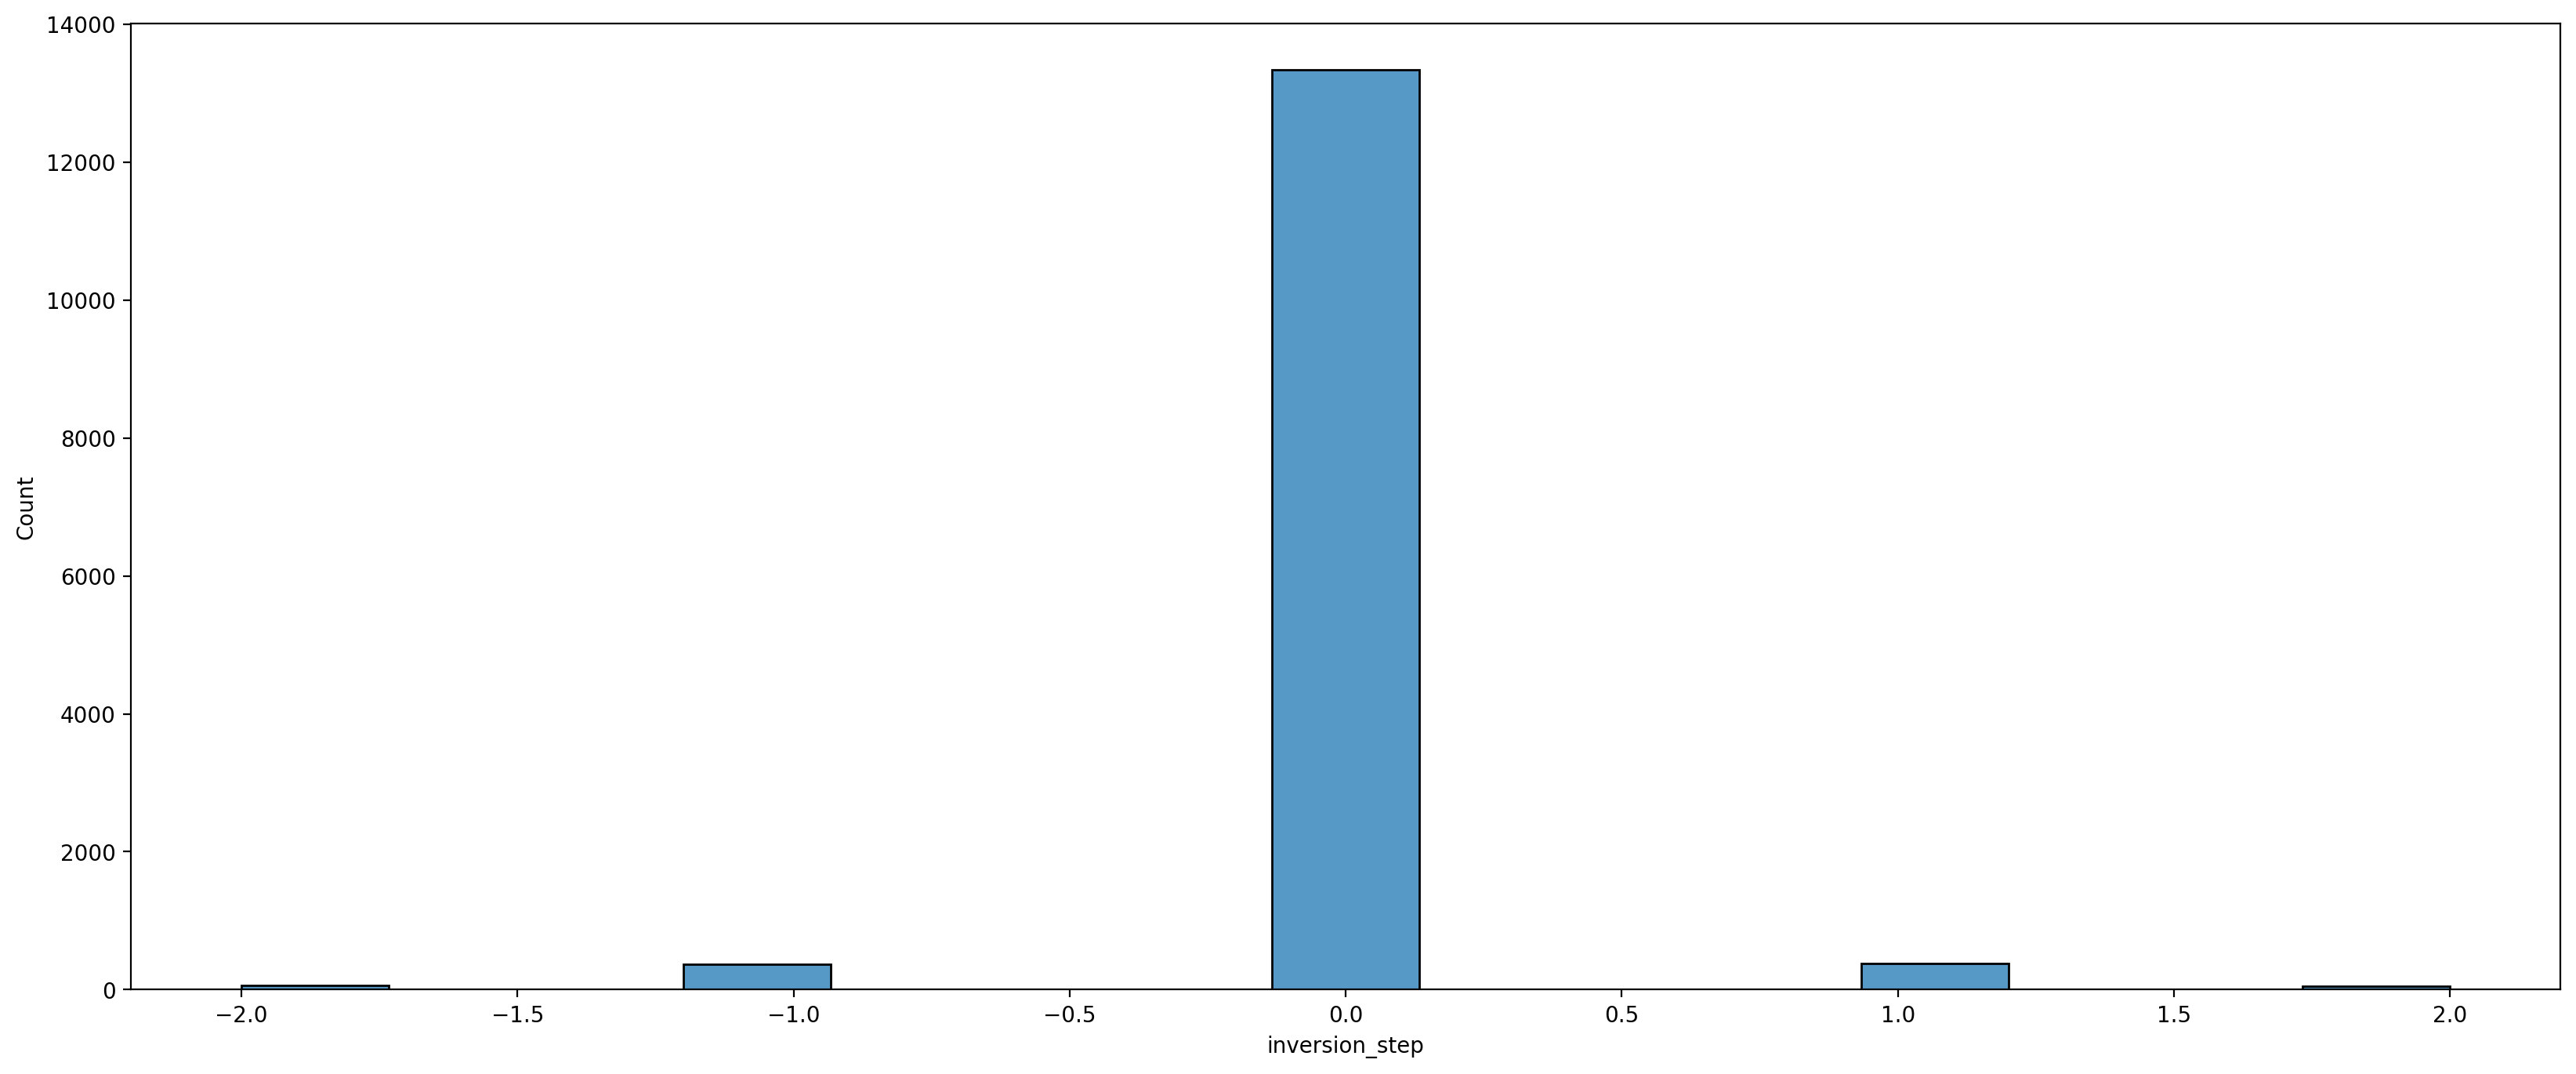

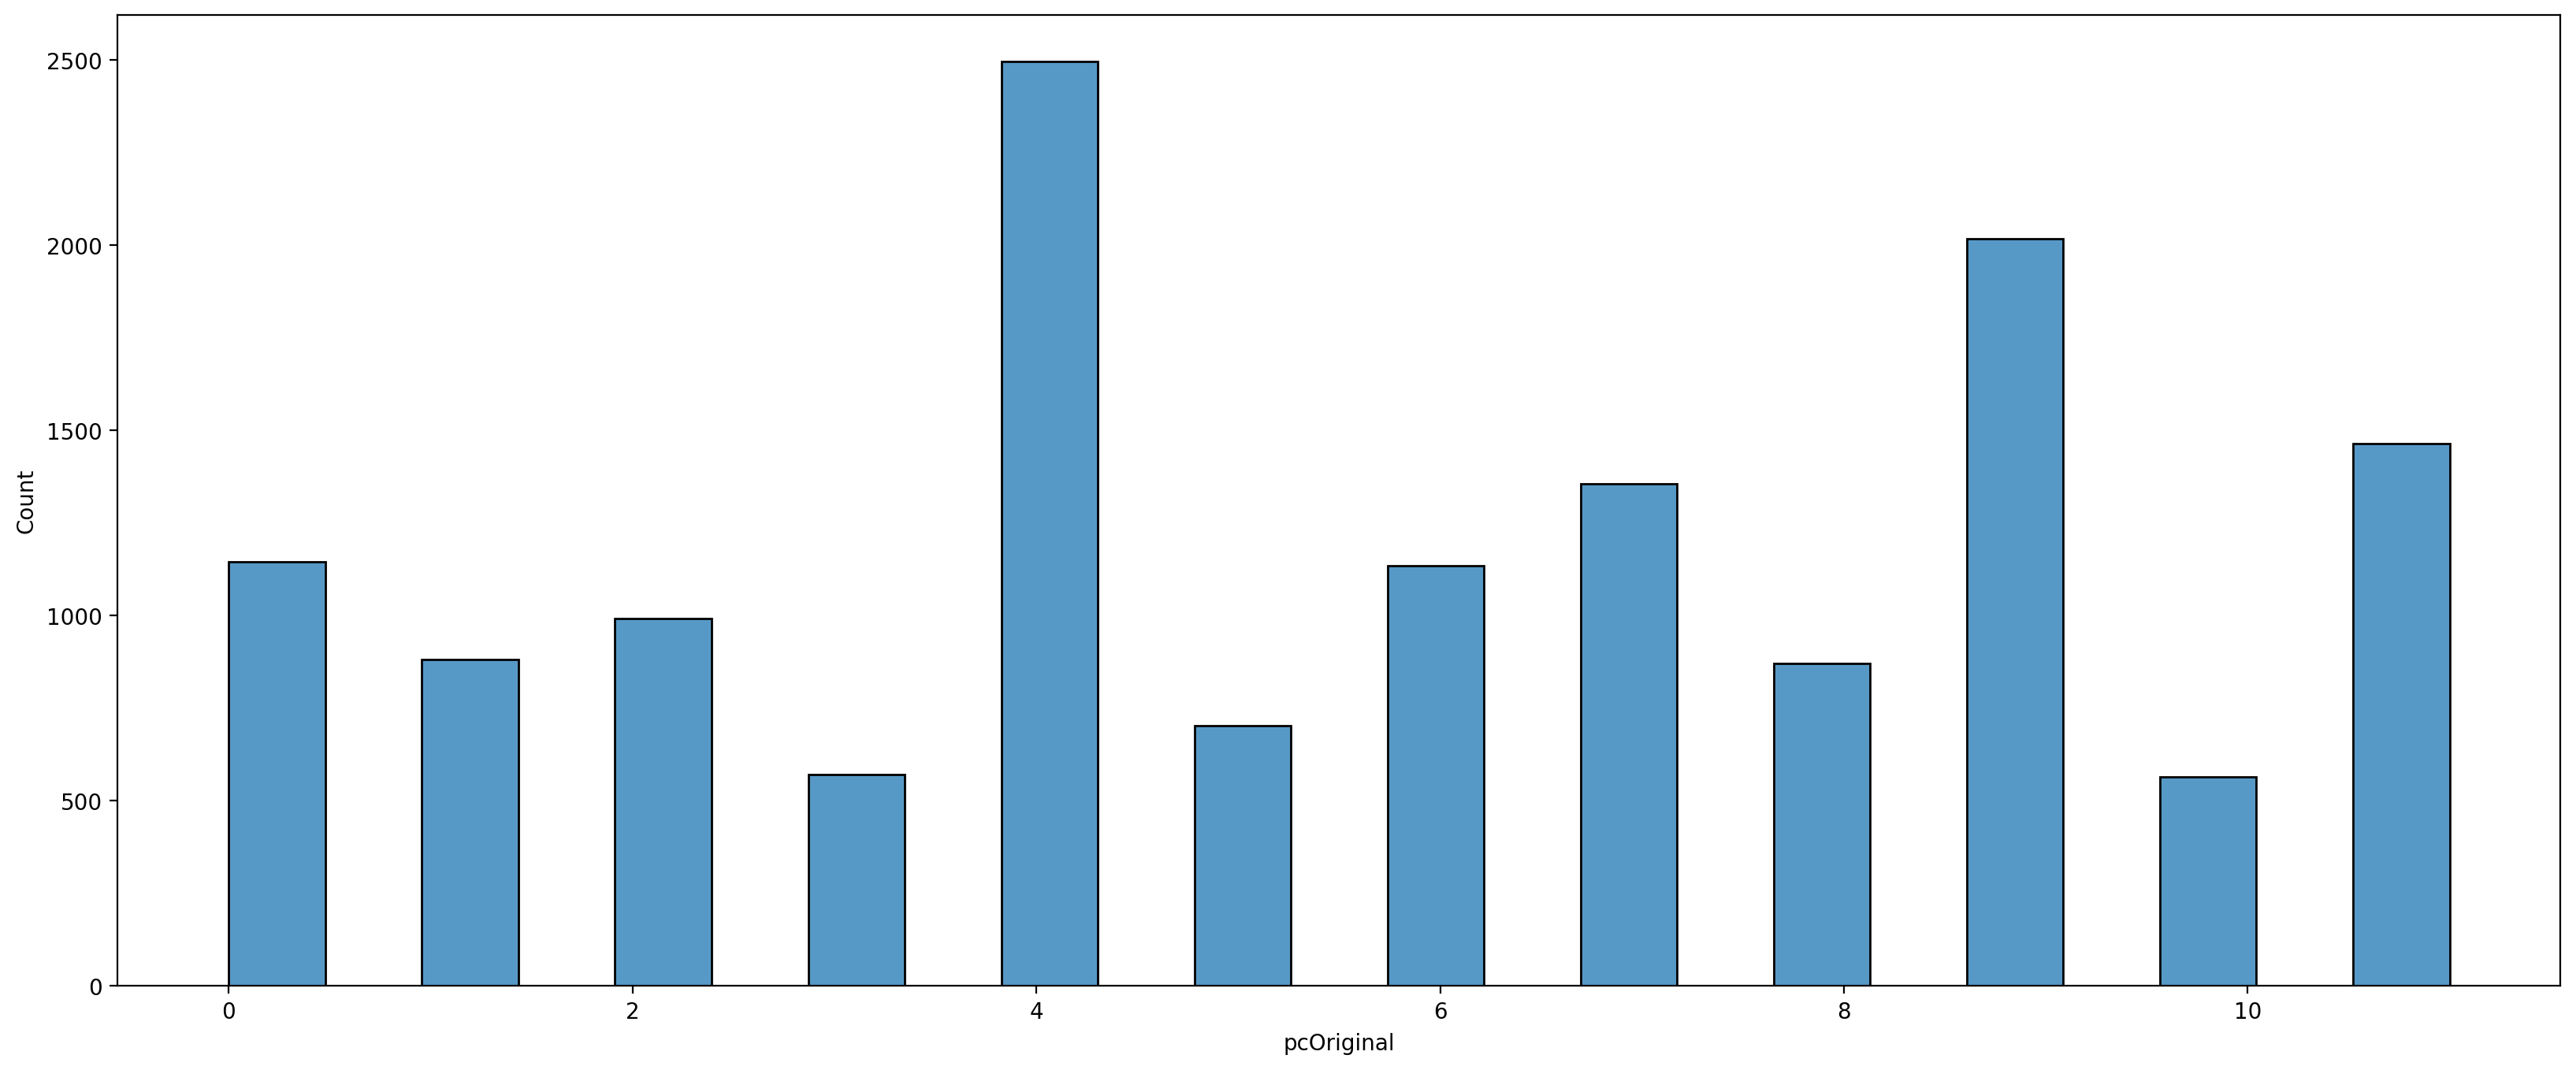

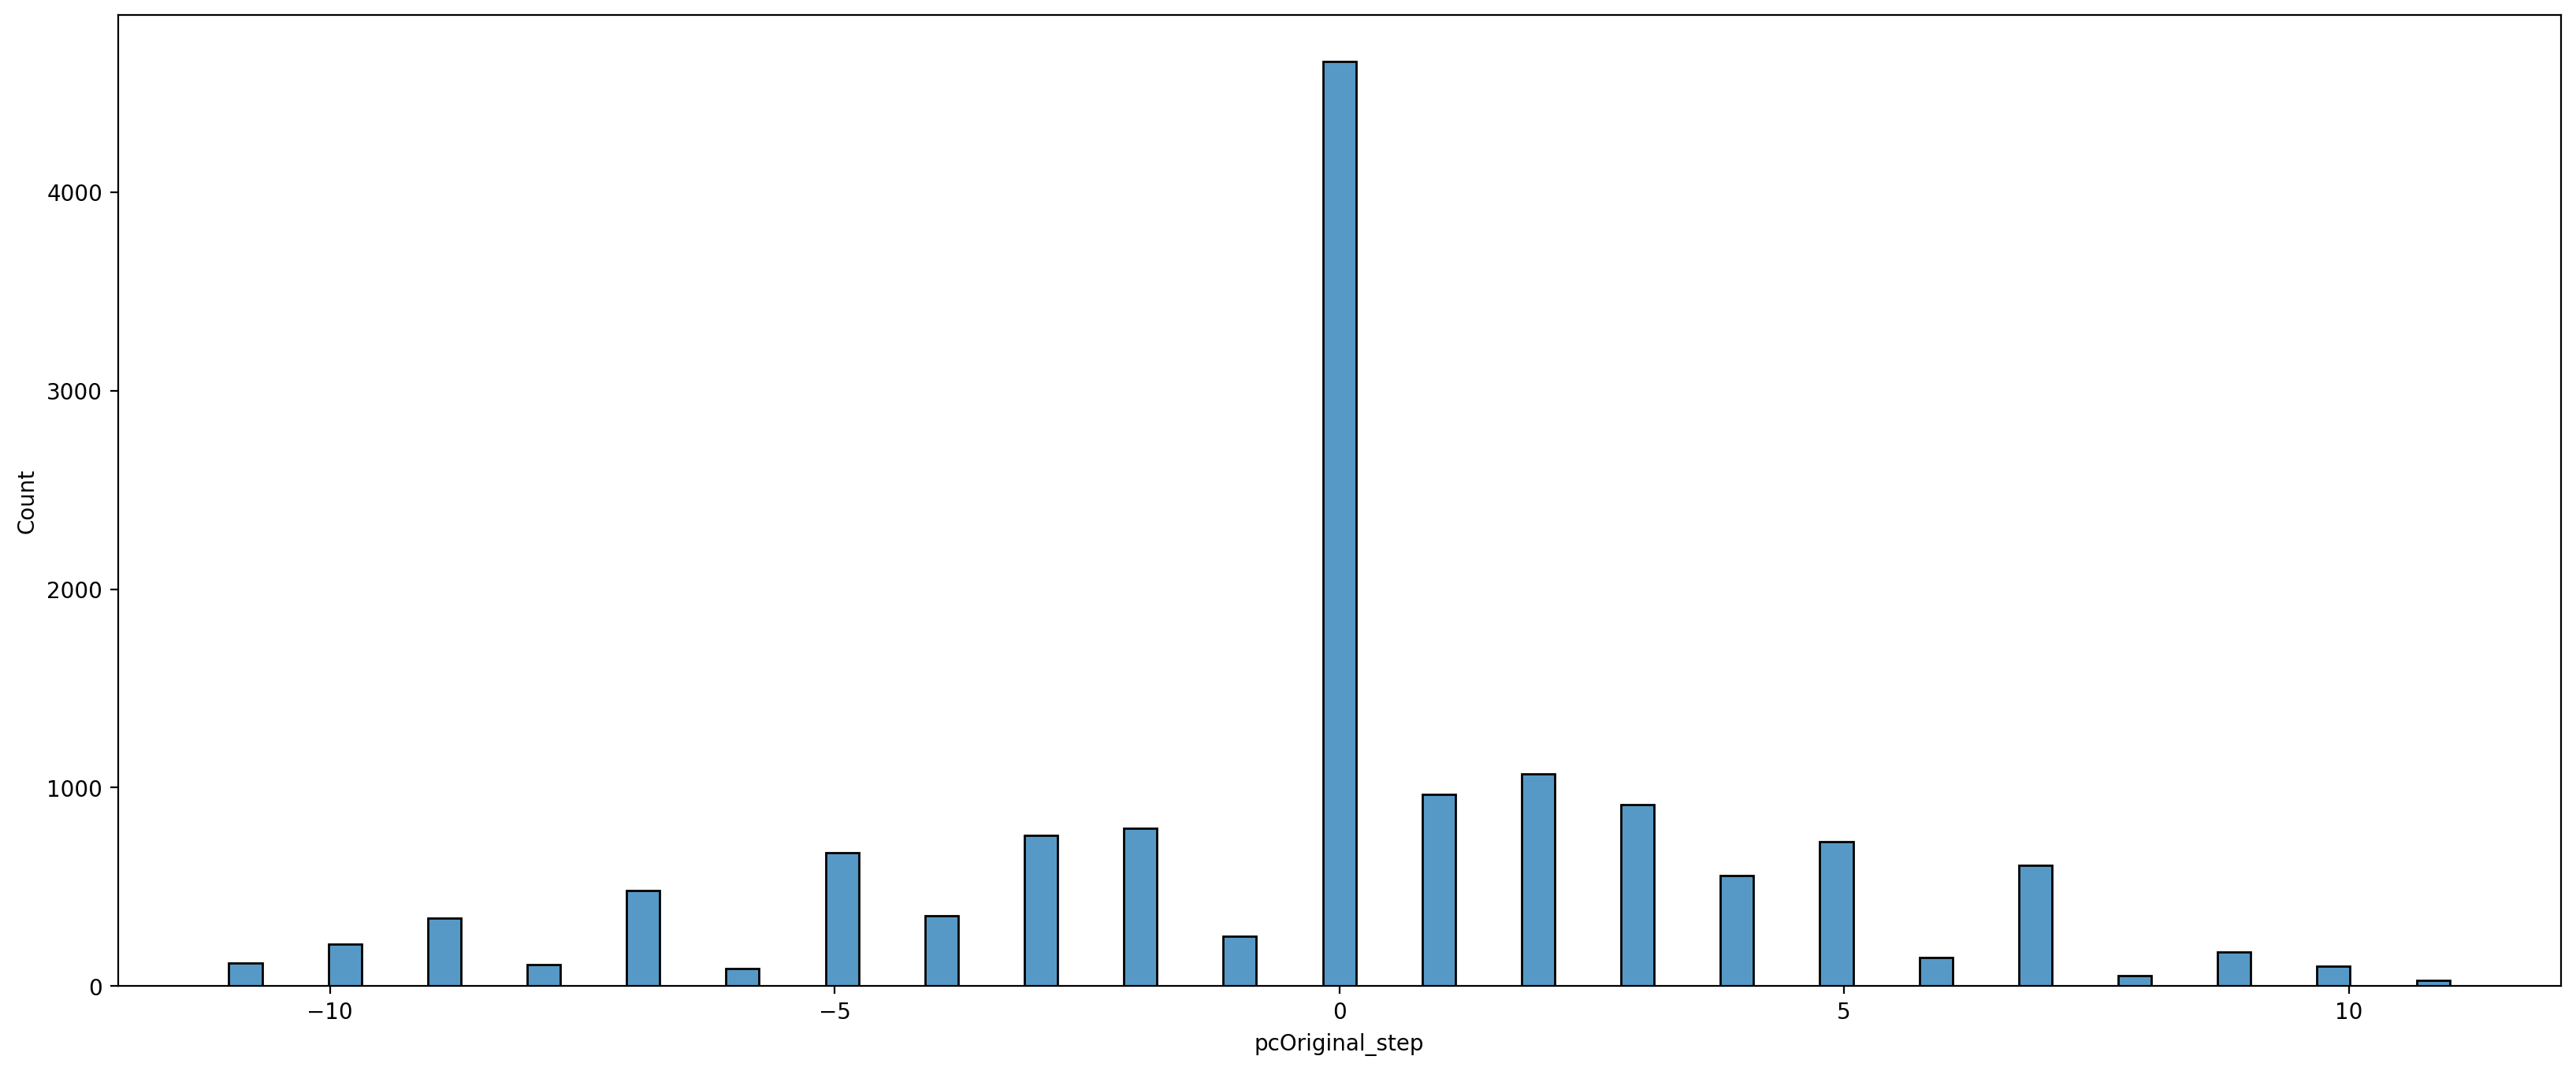

In [26]:
df = dataframe_all.sort_values(by='root_pitch')
plt.figure(figsize=[20, 8])
'''
def splitnote(val):
    if isinstance(val, list):
        return '.'.join(val)
    else:
        return str(val)
'''    
sns.histplot(df['root_note'])
plt.xticks(rotation = 90)
plt.show()

df = dataframe_all.sort_values(by='root_step')
plt.figure(figsize=[20, 8])    
sns.histplot(df['root_step'])
plt.show()

df = dataframe_all.sort_values(by='duration')
plt.figure(figsize=[20, 8])     
sns.histplot(df['duration'])
plt.show()



step = 1./16.
    
def fractions(x, pos):
    # https://stackoverflow.com/questions/33780678/how-to-label-the-x-axis-in-fraction-numbers
    if np.isclose((x/step)%(1./step),0.):
        # x is an integer, so just return that
        return '{:.0f}'.format(x)
    else:
        # this returns a latex formatted fraction
        return '$\\frac{{{:2.0f}}}{{{:2.0f}}}$'.format(x/step,1./step)
        # if you don't want to use latex, you could use this commented
        # line, which formats the fraction as "1/13"
        ### return '{:2.0f}/{:2.0f}'.format(x/step,1./step)

df['duration_scaled'] = df['duration'] / 4
plt.figure(figsize=[20, 8])
hist = sns.histplot(df, x="duration_scaled", binwidth=0.005)
hist.xaxis.set_major_locator(mticker.MultipleLocator(step))
hist.xaxis.set_major_formatter(mticker.FuncFormatter(fractions))


df = dataframe_all.sort_values(by='duration_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['duration_step'])
plt.show()

df['duration_step_scaled'] = df['duration_step'] / 4
plt.figure(figsize=[20, 8])
hist = sns.histplot(df, x="duration_step_scaled", binwidth=0.005)
hist.xaxis.set_major_locator(mticker.MultipleLocator(step))
hist.xaxis.set_major_formatter(mticker.FuncFormatter(fractions))

df = dataframe_all.sort_values(by='chord_interval')
plt.figure(figsize=[15, 8])
sns.histplot(df['chord_interval'])
plt.xticks(rotation = 90)
plt.show()

df = dataframe_all.sort_values(by='cardinality')
plt.figure(figsize=[20, 8])
sns.histplot(df['cardinality'])
plt.show()

df = dataframe_all.sort_values(by='cardinality_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['cardinality_step'])
plt.show()

df = dataframe_all.sort_values(by='forteClass')
plt.figure(figsize=[20, 8])
sns.histplot(df['forteClass'])
plt.show()

df = dataframe_all.sort_values(by='forteClass_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['forteClass_step'])
plt.show()

df = dataframe_all.sort_values(by='inversion')
plt.figure(figsize=[20, 8])
sns.histplot(df['inversion'])
plt.show()

df = dataframe_all.sort_values(by='inversion_step')
plt.figure(figsize=[20, 8])
sns.histplot(df['inversion_step'])
plt.show()

df = dataframe_all.sort_values(by='pcOriginal')
plt.figure(figsize=[20, 8])       
sns.histplot(df['pcOriginal'])
plt.show()

df = dataframe_all.sort_values(by='pcOriginal_step')
plt.figure(figsize=[20, 8])       
sns.histplot(df['pcOriginal_step'])
plt.show()


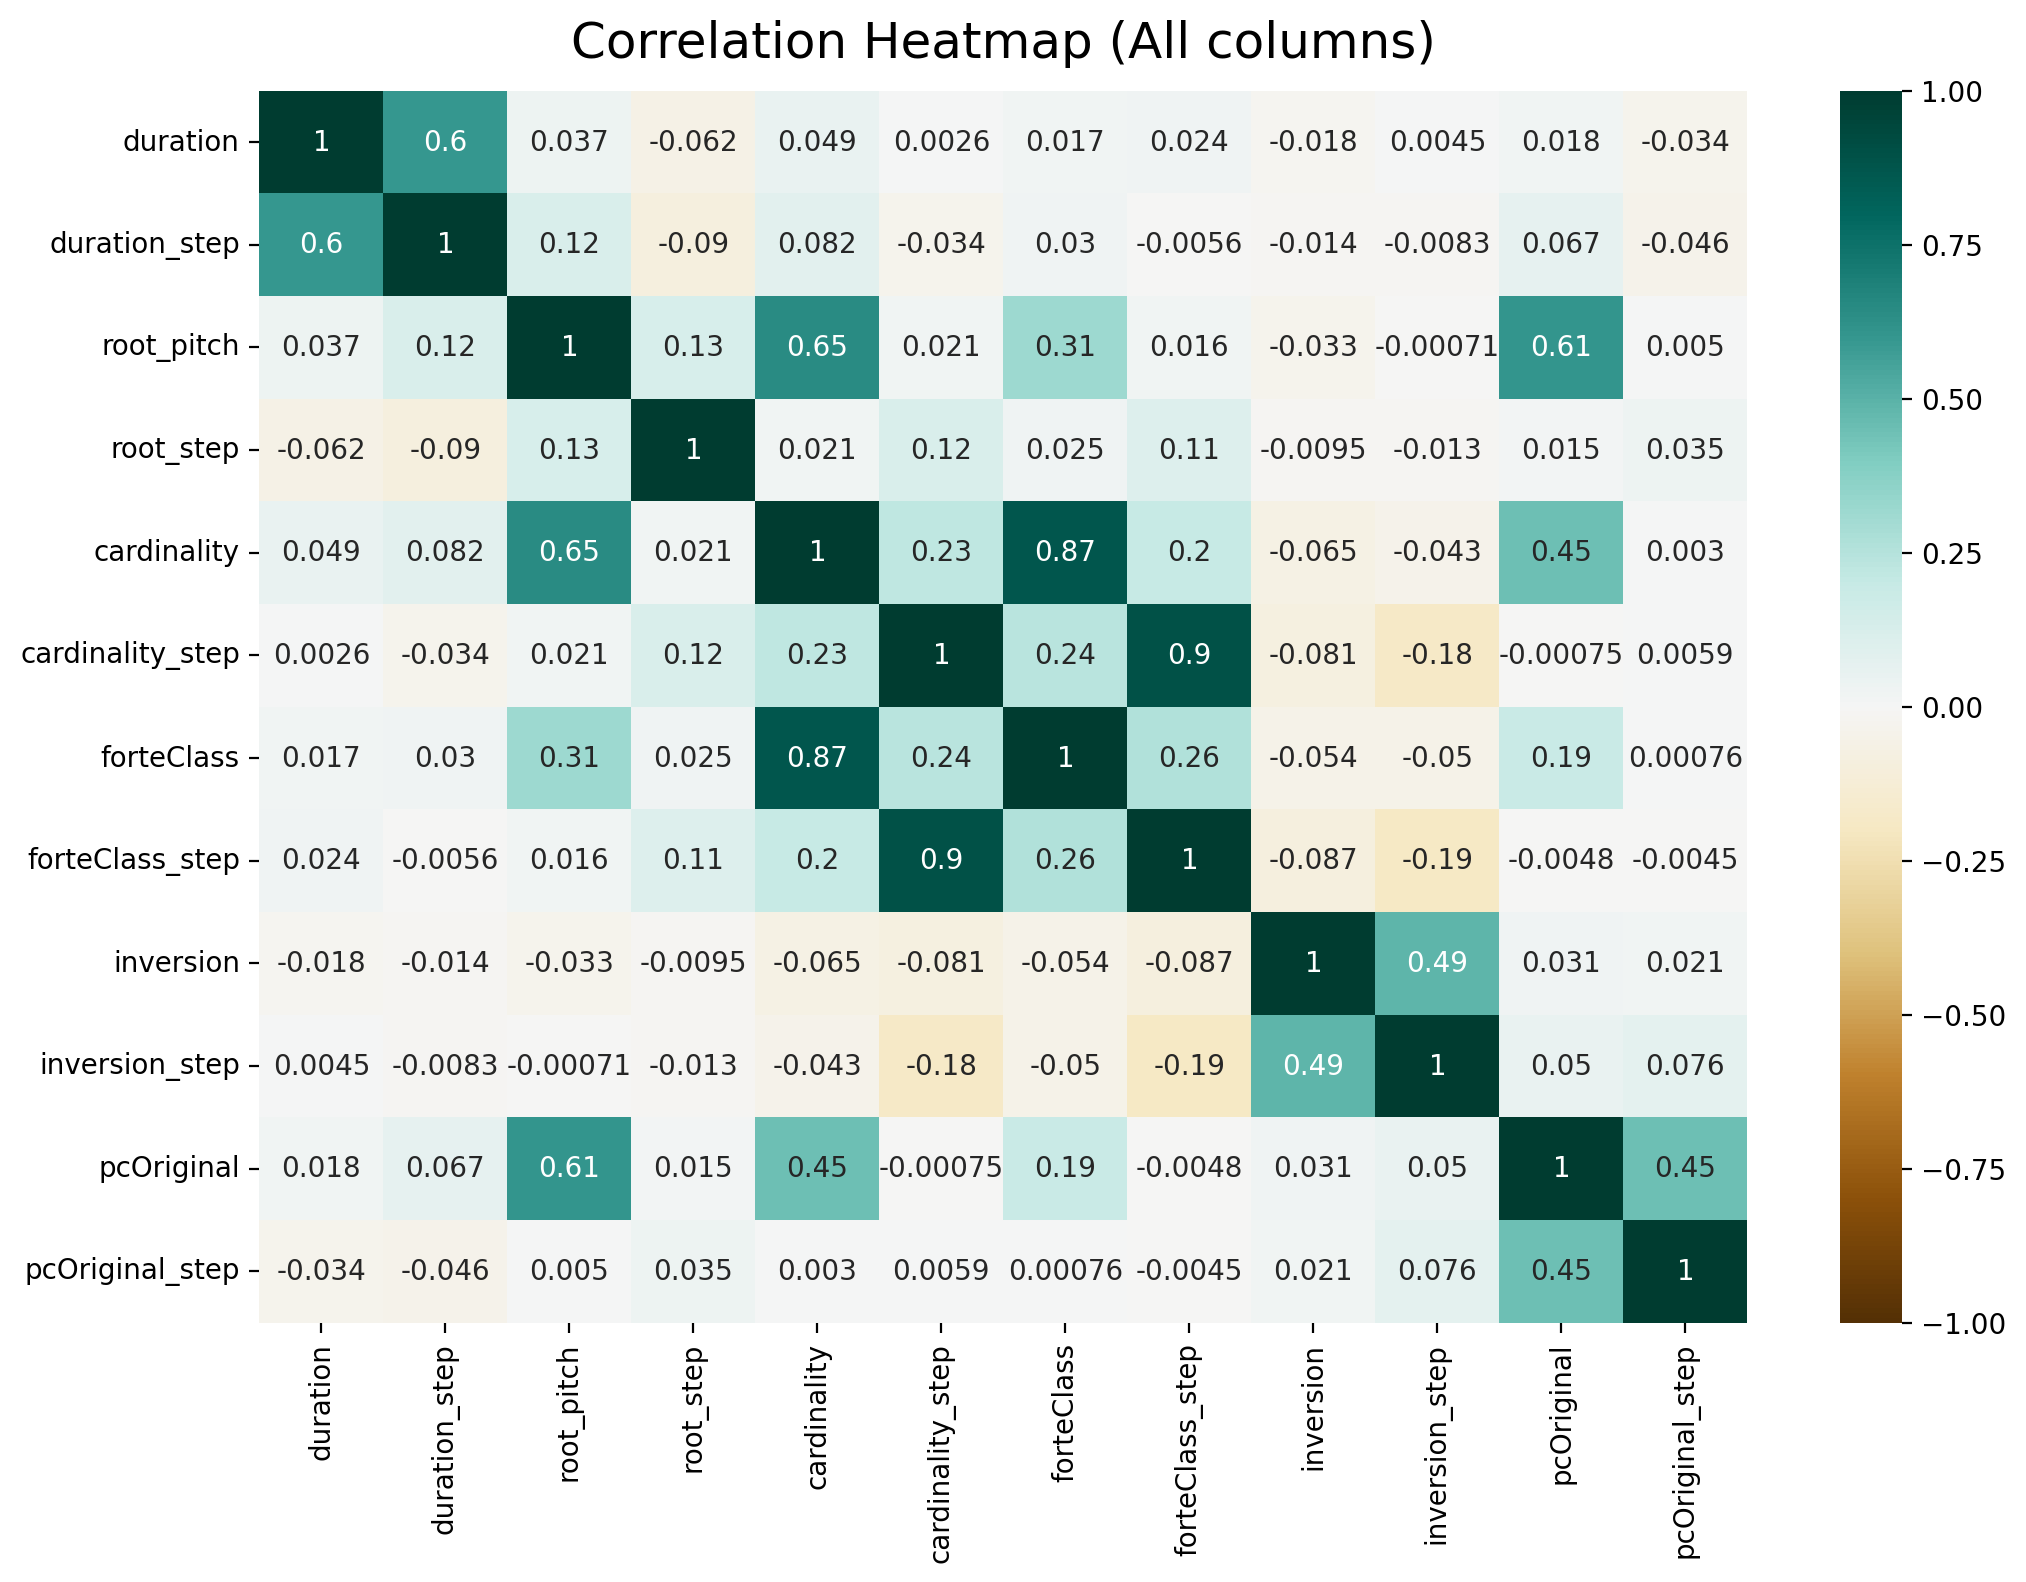

In [27]:
dataframe_corr = dataframe_all.drop(columns=['chord_interval','notes', 'note_pitches', 'root_note']).fillna(value=0)
correlation_all = dataframe_corr.corr()

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_all, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap (All columns)', fontdict={'fontsize':18}, pad=12);
plt.show()

# plot piano roll of all MIDI data

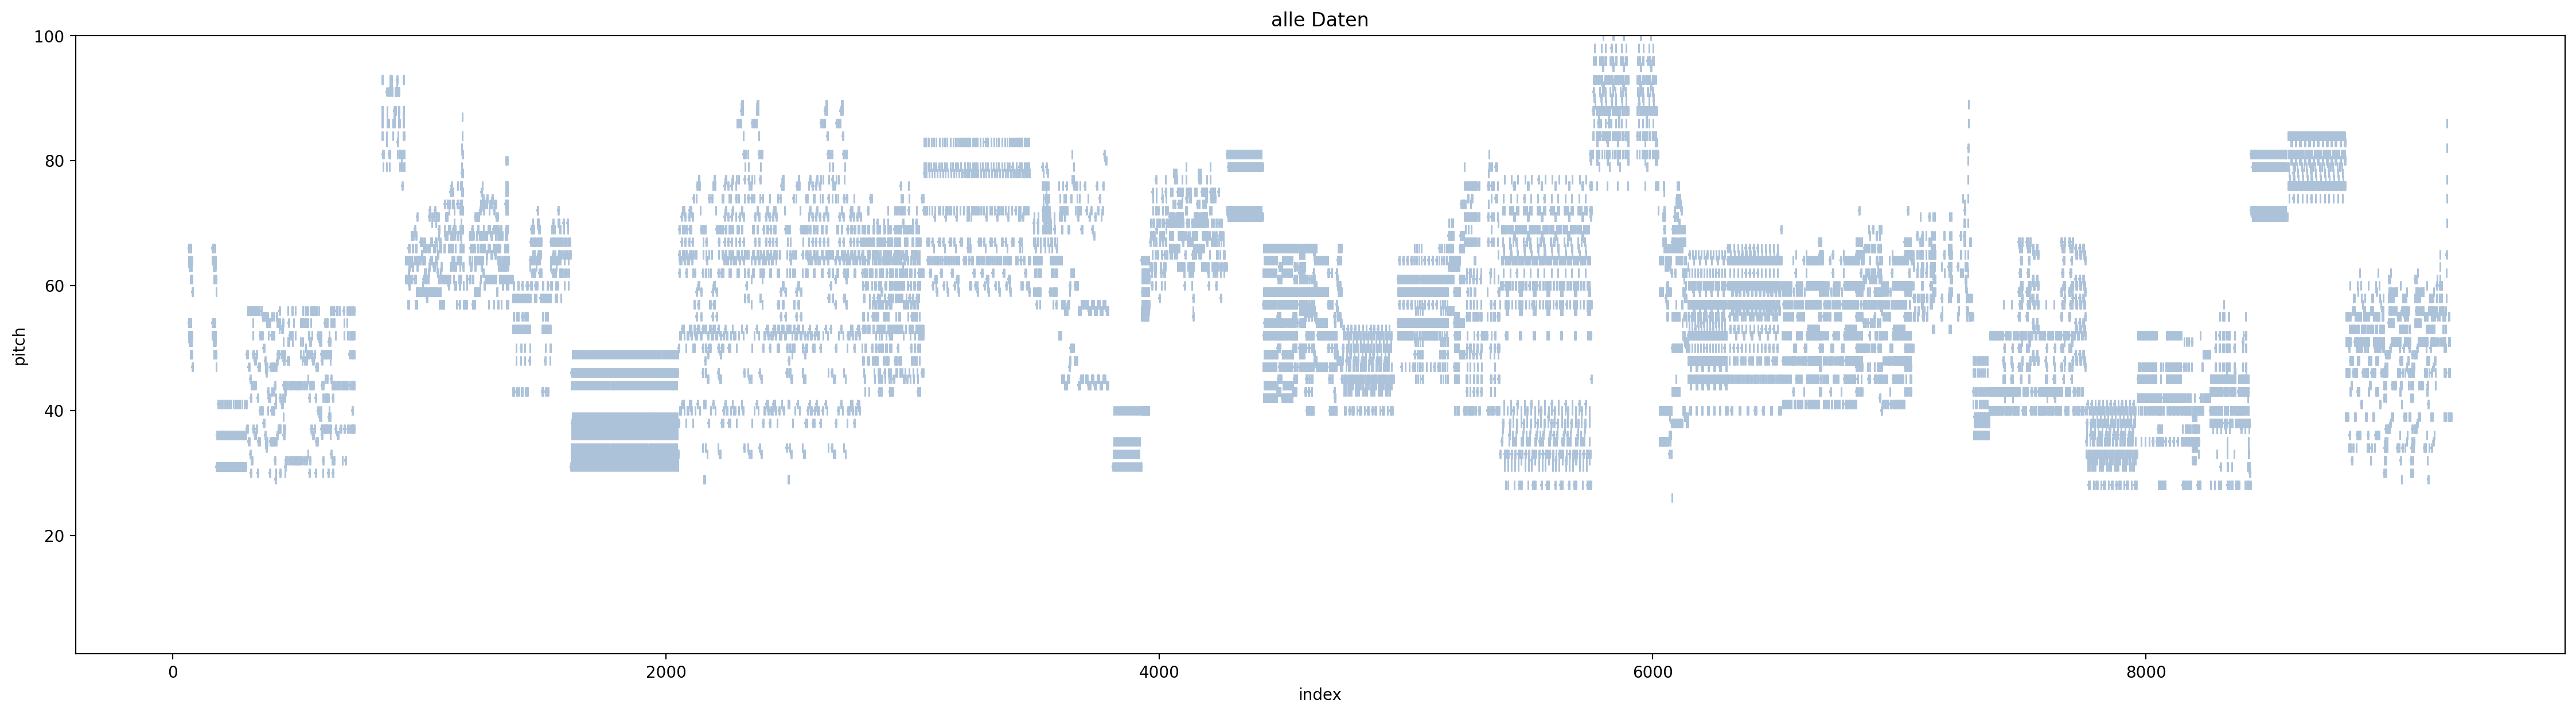

In [28]:
def plot_piano_roll(dataframes, count:int = None):
    if len(dataframes) > 1:
        title = f'All MIDI Data'
        count = 99999999999
    else:
        title = dataframes[0].name

    fig, ax1 = plt.subplots(figsize=(28, 7)) 

    for n, (notes, color) in enumerate(zip(dataframes, list(mcolors.XKCD_COLORS))):
        flat_start = []
        flat_end = []
    
        start = (notes['duration'].cumsum()).shift(periods=1)[:count]
        start[0] = 0.0
        end = (notes['duration'].cumsum())[:count]
    
        for p, s, e in zip(notes['note_pitches'][:count], start, end):
            if isinstance(p, np.ndarray):
                for n in range(len(p)): 
                    flat_start.append(s)
                    flat_end.append(e)
            else:
                flat_start.append(s)
                flat_end.append(e)
    
        flat_notes = np.hstack(notes['note_pitches'][:count].to_numpy())

        if n == 0:
            axn=ax1
        else:
            axn = ax1.twinx()
            axn.get_yaxis().set_visible(False)

        axn.plot([flat_start[0], flat_end[0]],[flat_notes[0], flat_notes[0]], color=color, marker="|", label=notes.name)
        axn.plot([flat_start[1:], flat_end[1:]],[flat_notes[1:], flat_notes[1:]], color=color, marker="|")
        axn.set_ylim([1, 100])
        axn.set_xlabel('index')
        axn.set_ylabel('pitch')
        
    plt.title(title)        
    plt.show()

plot_piano_roll([dataframe_all])

# explore sequences
create raw sequences for exploration

In [29]:
col_idx = [6]
seq_len = 8

In [30]:
def create_sequences(df, seq_length, column_indx):

    print(f'extracting column:  "{df.columns[column_indx]}" !')
    
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i : (i+seq_length), column_indx]
        # Define target
        y = df.iloc[(i+seq_length), column_indx]
  
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(dataframe_all, seq_len, col_idx)

extracting column:  "Index(['root_step'], dtype='object')" !


In [31]:
X_all_list = [f'{x}' for x in X_all.tolist()]
X_all_list_tar = [f'{x} --> {y}' for x, y in zip(X_all.tolist(), y_all.tolist())]
unique = np.unique(X_all_list, return_counts=True)
uniq = pd.Series(data=unique[1], index=unique[0])
uniq = uniq.sort_values(ascending=False)

df_trainmatrice = pd.DataFrame(data=y_all, columns=[f'y_{x}' for x in range(y_all.shape[1])], index=X_all_list)
df_trainmatrice= pd.get_dummies(df_trainmatrice[df_trainmatrice.columns], dtype=float)
df_trainmatrice = df_trainmatrice.groupby(df_trainmatrice.index).sum()

unique_tar = np.unique(X_all_list_tar, return_counts=True)
uniq_tar = pd.Series(data=unique_tar[1], index=unique_tar[0])
uniq_tar = uniq_tar.sort_values(ascending=False)

In [32]:
ntop = 20
print(f'Top {ntop} unique sequences')
uniq.head(ntop)

Top 20 unique sequences


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]         540
[[nan], [4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0]]         98
[[4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan]]         98
[[nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0]]        72
[[3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0], [nan]]        72
[[1.0], [1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0]]       62
[[10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0]]       62
[[1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0]]       62
[[1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0]]       62
[[1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0]]        62
[[2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0]]      62
[[-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0]]      62
[[7.0], [3.0], [-18.0], [1.0], [1.0], [1.0], [10.0], [2.0]]       61
[[1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0], [1.0]]        61
[[3.0], [-18.0], [1.0], [1.0], [1.

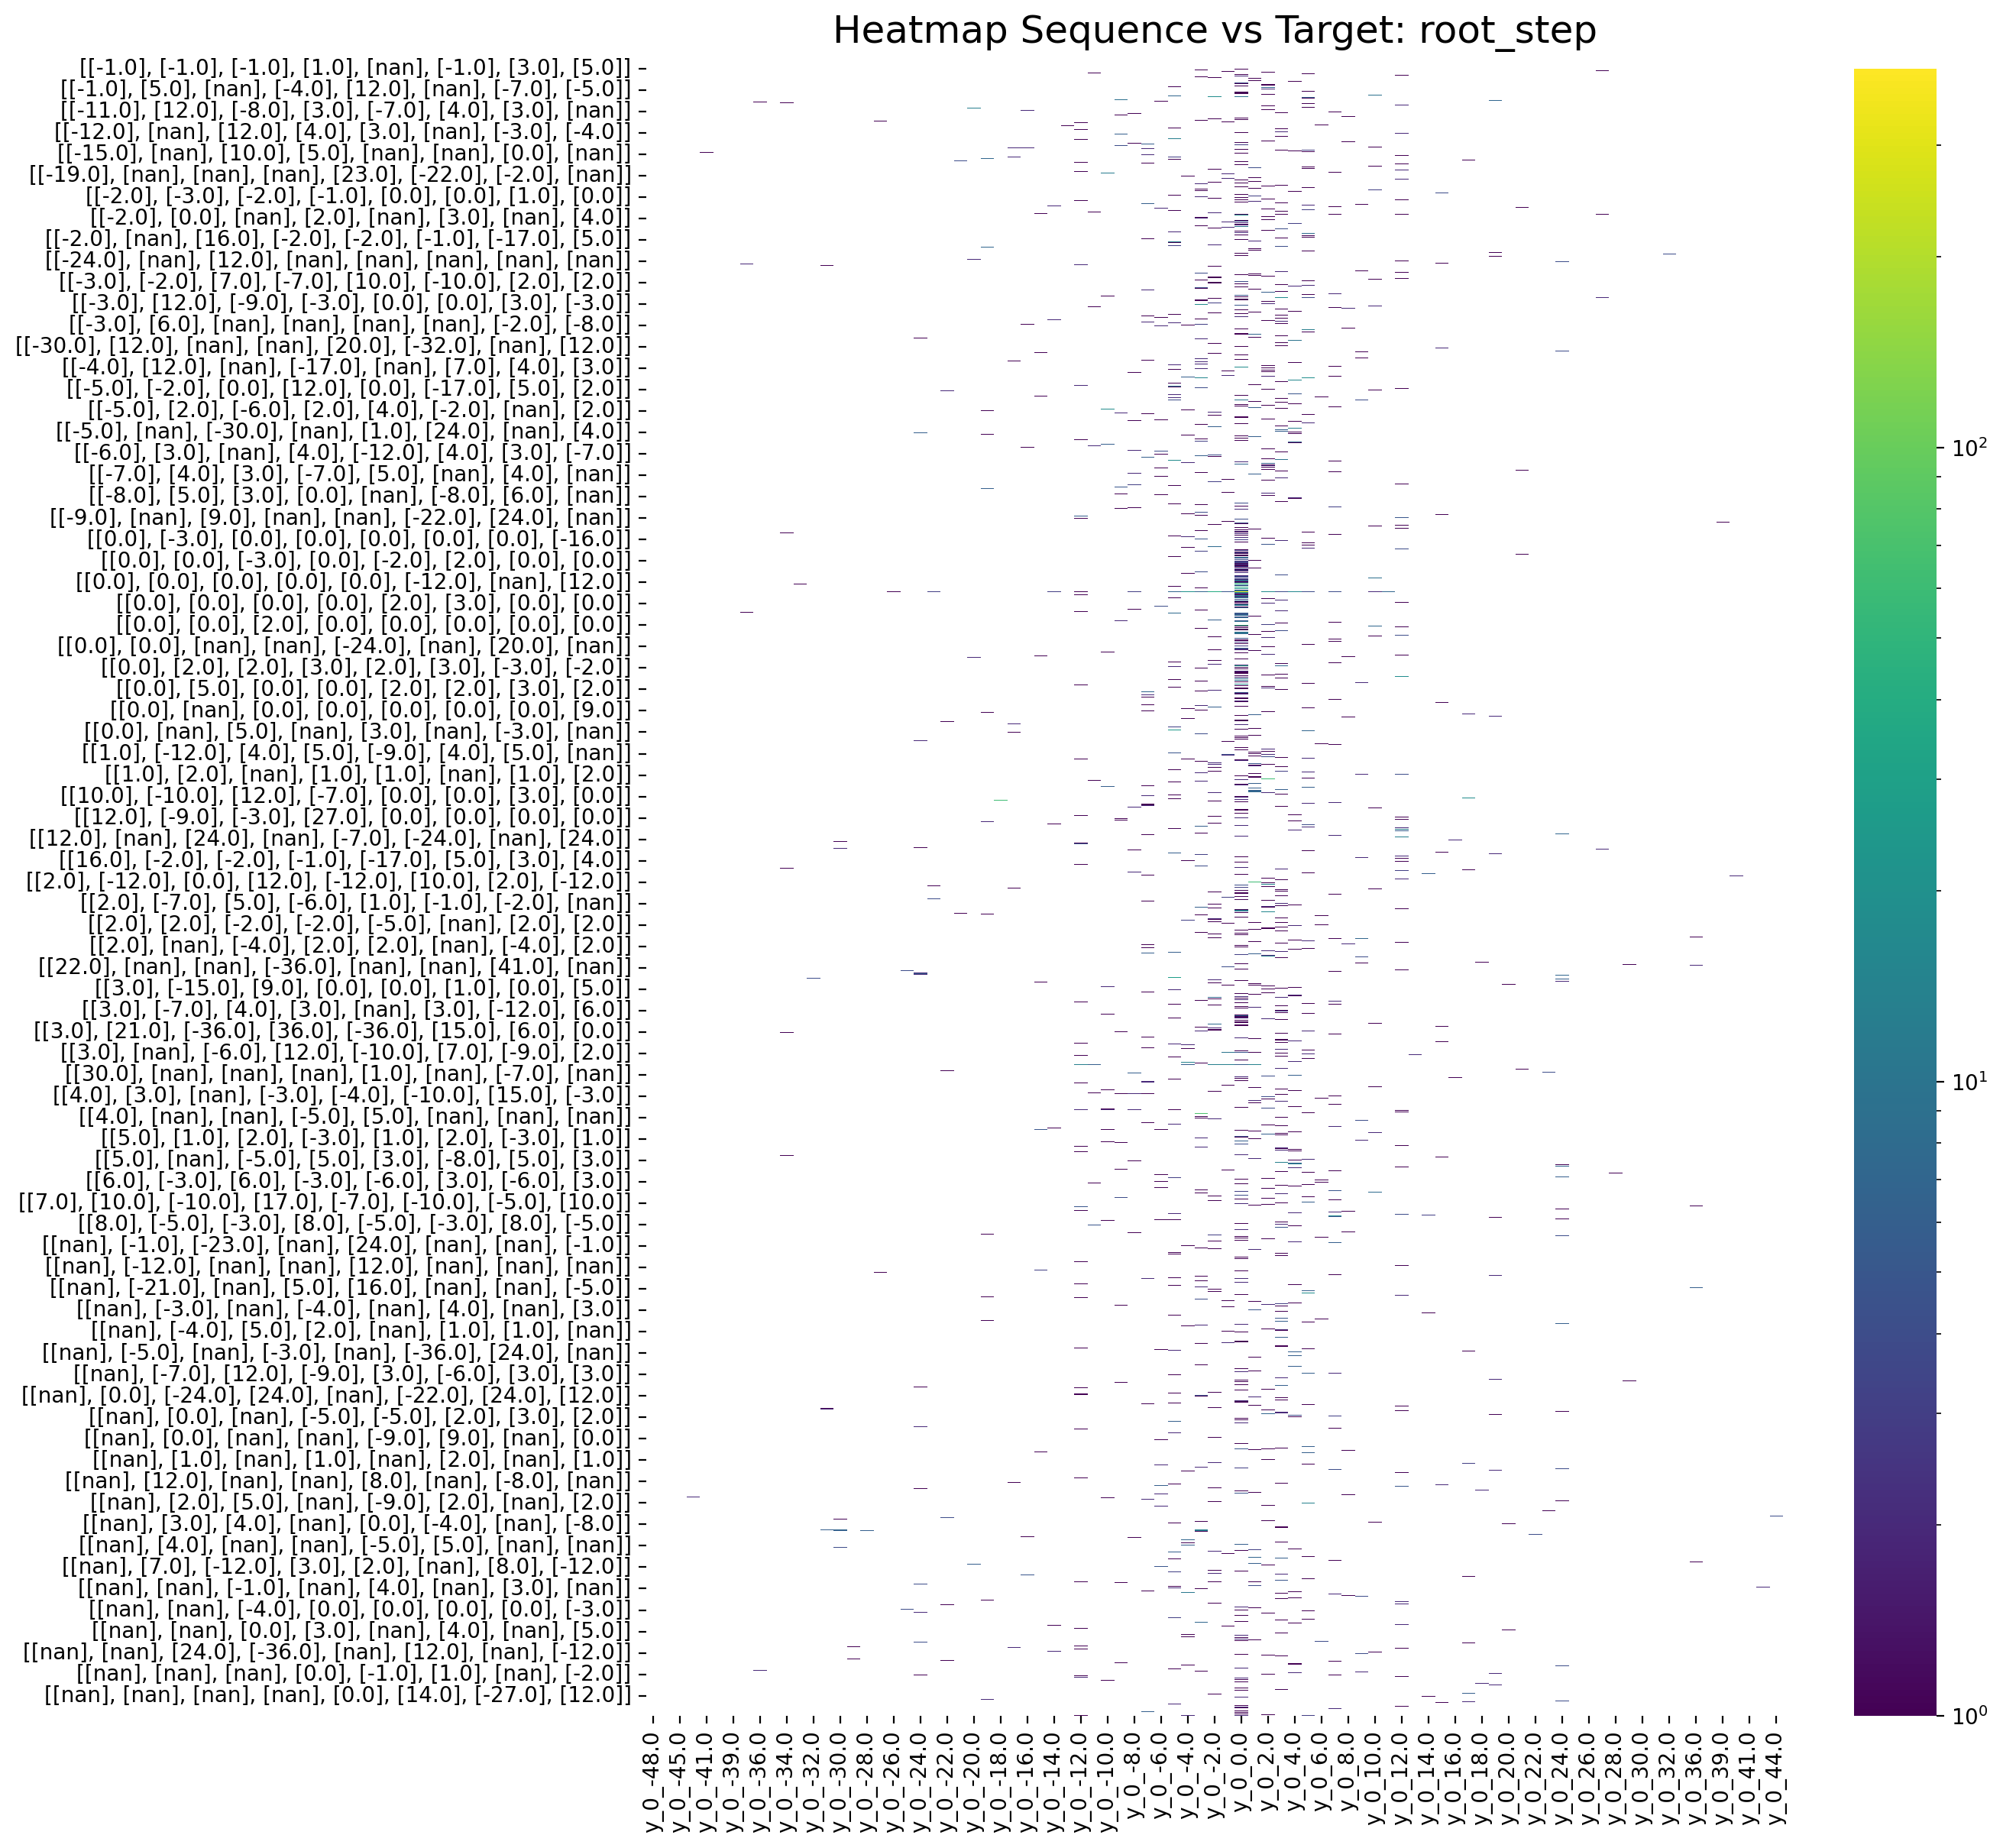

In [33]:
plt.figure(figsize=(12, 14))
heatmap = sns.heatmap(df_trainmatrice, annot=False, norm=mcolors.LogNorm(), cmap='viridis')
heatmap.set_title(f'Heatmap Sequence vs Target: {df.columns[col_idx][0]}', fontdict={'fontsize':18}, pad=12)
plt.show()

In [34]:
print(f'Top {ntop} unique sequences with target')
uniq_tar.head(ntop)

Top 20 unique sequences with target


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]] --> [0.0]         396
[[nan], [4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0]] --> [nan]         98
[[4.0], [nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan]] --> [-3.0]        72
[[nan], [3.0], [nan], [5.0], [nan], [-5.0], [nan], [-3.0]] --> [nan]        72
[[1.0], [1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0]] --> [1.0]       62
[[2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0]] --> [1.0]      62
[[10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0], [3.0]] --> [-18.0]     62
[[1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0], [7.0]] --> [3.0]       62
[[-10.0], [1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0]] --> [1.0]      62
[[1.0], [1.0], [10.0], [2.0], [-10.0], [1.0], [1.0], [1.0]] --> [7.0]       62
[[1.0], [1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0]] --> [1.0]        61
[[-18.0], [1.0], [1.0], [1.0], [10.0], [2.0], [-10.0], [1.0]] --> [1.0]     61
[[1.0], [1.0], [7.0], [3.0], [-18.0], [1.0], [1.0], 

## explore outlier
everything $>= 3 \sigma$ can be considered an outlier, that includes the very common `0.0` sequences and the rare ones 

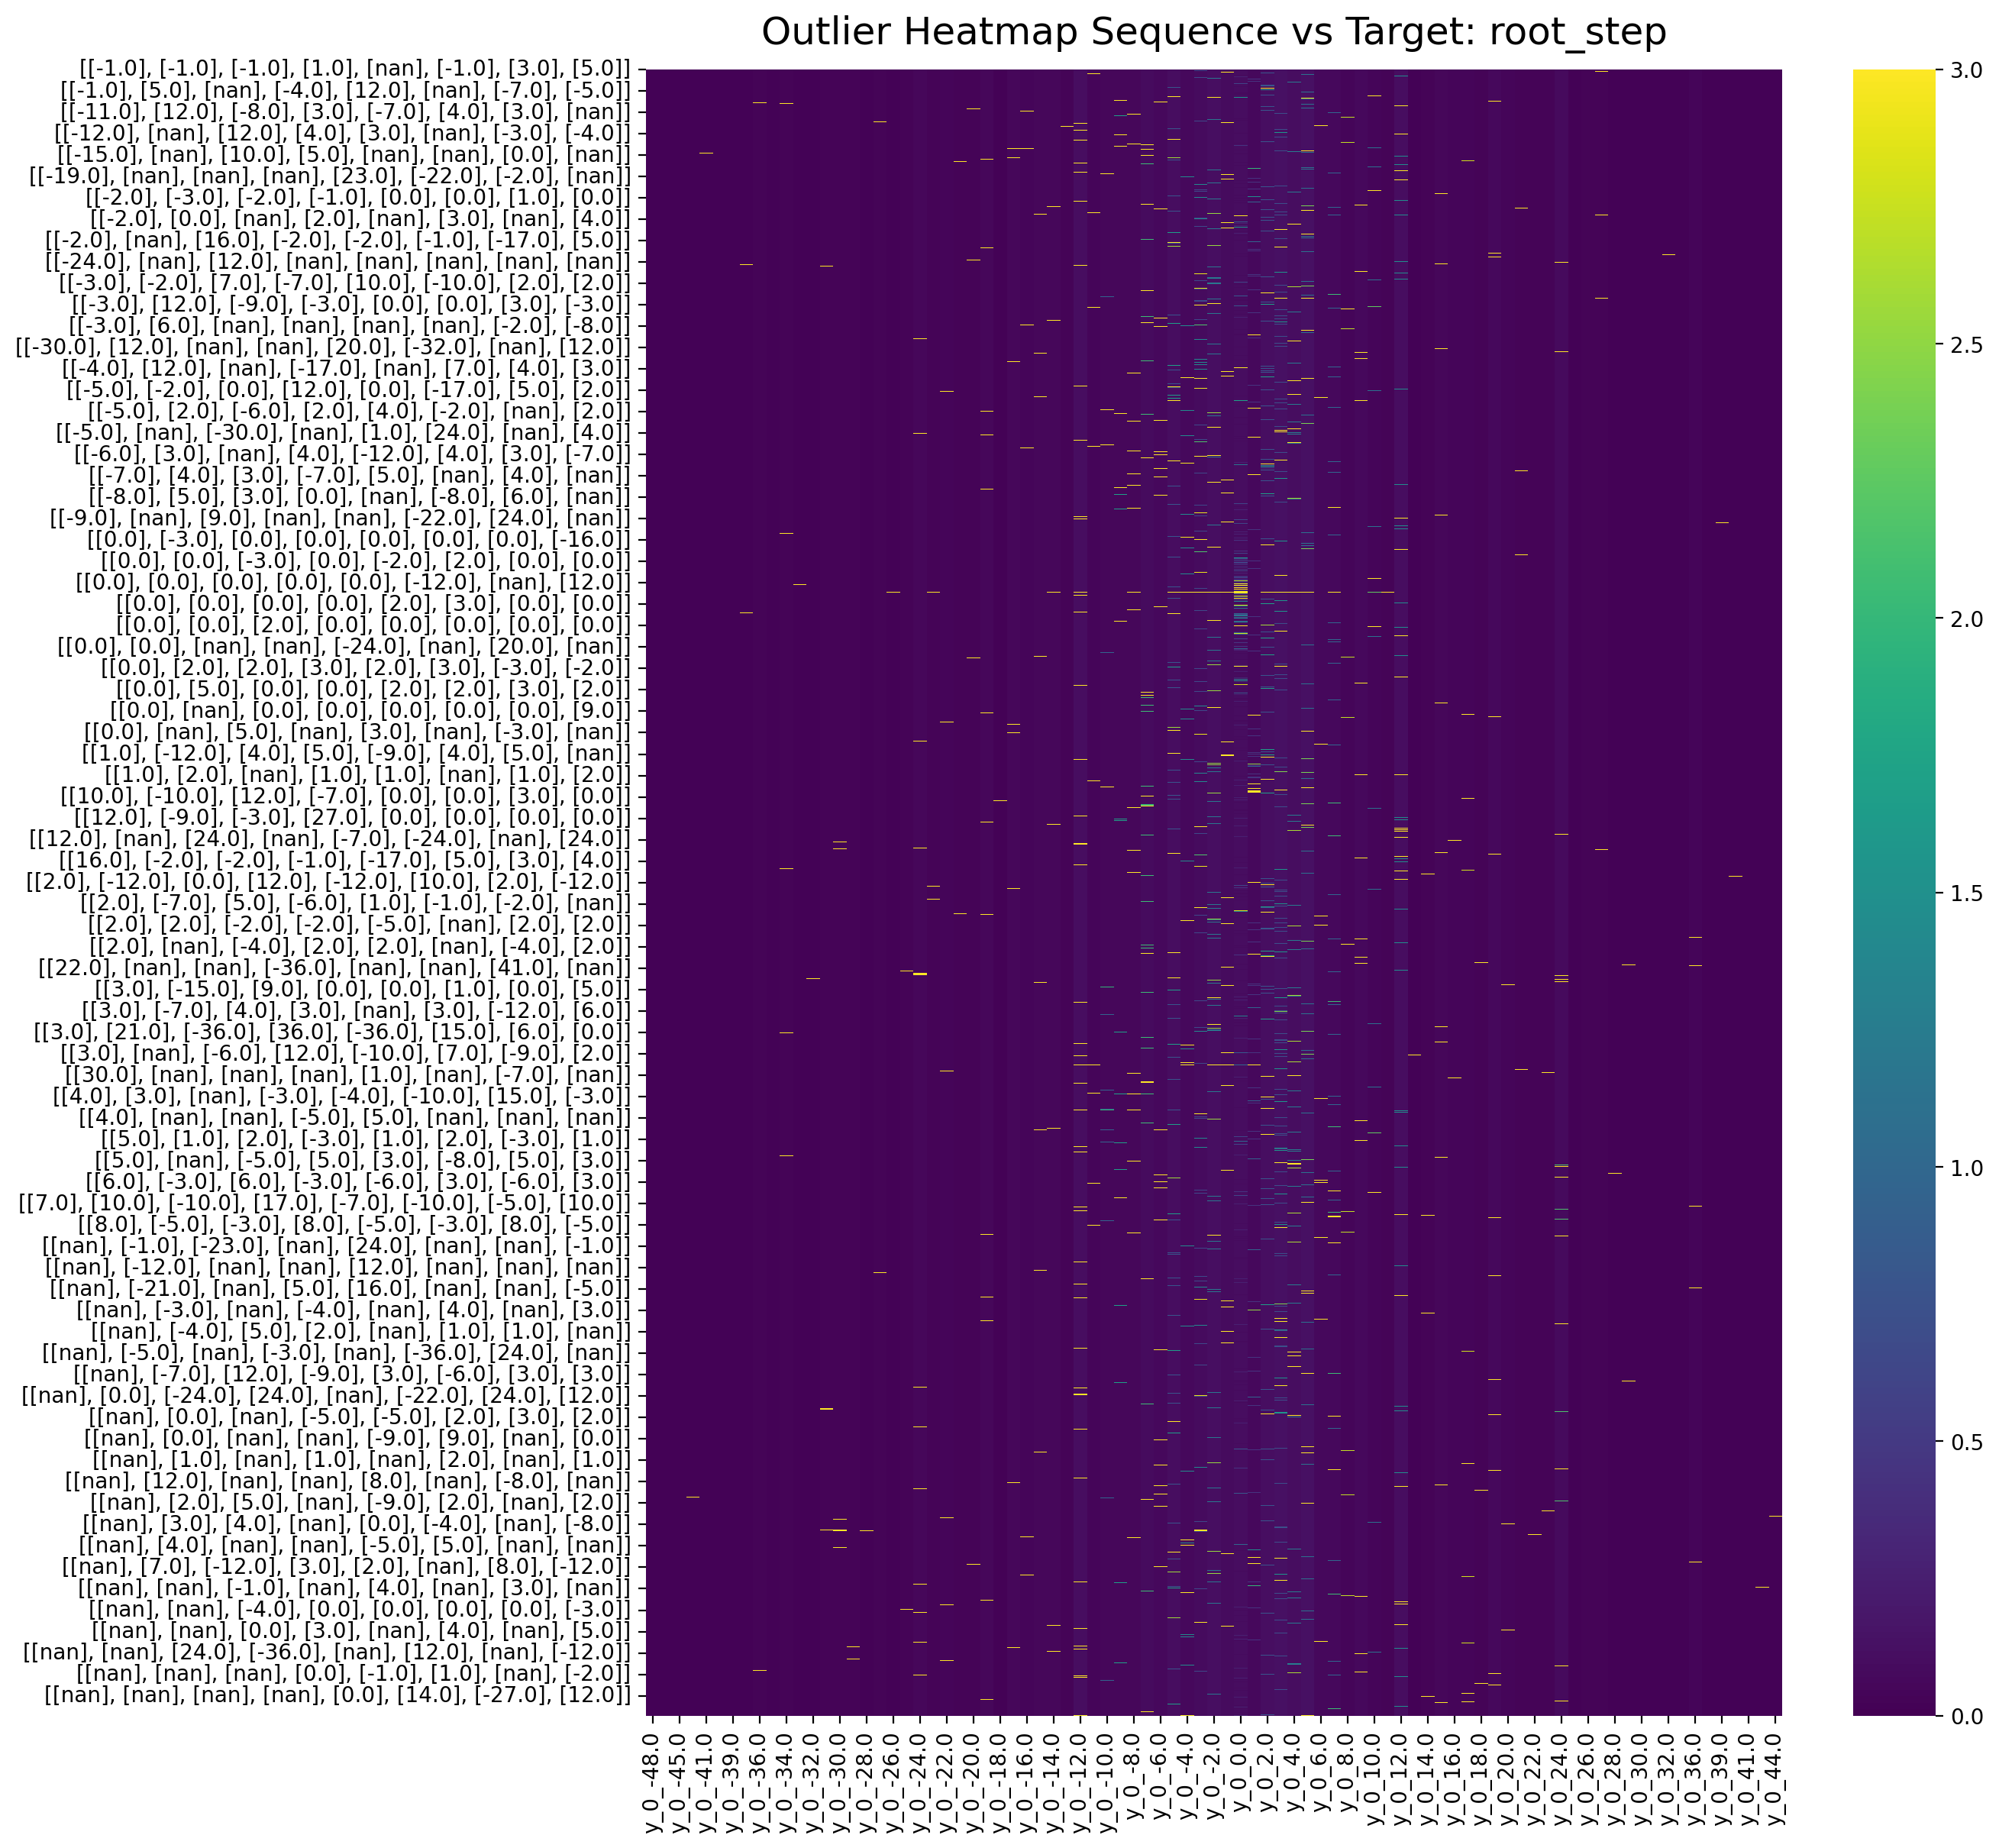

In [35]:
df_outlier = df_trainmatrice.copy()

for col in df_trainmatrice.columns:
    df_outlier[col] = np.abs(zscore(df_trainmatrice[col]))

df_outlier = np.abs(zscore(df_trainmatrice, axis = 0, ddof = 1))

plt.figure(figsize=(12, 14))
heatmap = sns.heatmap(df_outlier, annot=False, vmin = 0, vmax = 3, cmap='viridis')
heatmap.set_title(f'Outlier Heatmap Sequence vs Target: {df.columns[col_idx][0]}', fontdict={'fontsize':18}, pad=12)
plt.show()

# OHE encoded sequences
now create sequences in one-hot encoded format to encode every value including `nan` rests

In [36]:
## print all columns with indexes
for col, idx in zip(dataframe_all.columns, range(len(dataframe_all.columns))):
    print(idx, col)

0 notes
1 note_pitches
2 duration
3 duration_step
4 root_note
5 root_pitch
6 root_step
7 chord_interval
8 cardinality
9 cardinality_step
10 forteClass
11 forteClass_step
12 inversion
13 inversion_step
14 pcOriginal
15 pcOriginal_step


In [37]:
col_idx = [2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
seq_len = seq_len

#print(dataframe_all.columns[idx])

X_all, y_all = np.array(()), np.array(())

mi = []
ma = []
ste = []

for idx in col_idx:
    uniq = np.unique(dataframe_all[dataframe_all.columns[idx]].values)
    
    i = np.nanmin(uniq)
    s = np.nanmin(np.diff(uniq))
    a = np.nanmax(uniq) + s
    mi.append(i)
    ma.append(a)
    ste.append(s)
    
    #print(uniq, i, a, s)

#print(mi, ma, ste)


def create_ohe_sequences(df, seq_length, column_indx, min_list, max_list, step_list, verbose):

    col_names = df.columns[column_indx]

    Xs, Ys, Fact, deFact = {}, {}, {}, {}
    
    for min, max, step, colname in zip(min_list, max_list, step_list, col_names):
    
        ohe_values = np.arange(min, max, step)
        ohe_values = np.append(ohe_values, values=[np.nan])
        ohe_replace = [x for x in range(len(ohe_values))]

        if verbose > 0:
            print(f'extracting sequences with len: {seq_length} from column: "{colname}", replacing {len(ohe_values)} values!')
        
        factorize_dict = dict(itertools.zip_longest(*[iter(ohe_values)], ohe_replace, fillvalue="-1"))
        defactorize_dict = dict(itertools.zip_longest(*[iter(ohe_replace)], ohe_values, fillvalue="-1"))

        df_factorized = df[colname].replace(factorize_dict)
    
        encoder = LabelBinarizer()
        encoder.fit(ohe_replace)
    
        df_transformed = encoder.transform(df_factorized)

        #print(df_transformed)
    
        xs, ys = [], []
        # Iterate over data indices
        for i in range((len(df_transformed) - seq_length)):
          	# Define inputs
            x = df_transformed[i : (i + seq_length)]
            # Define target
            y = df_transformed[(i + seq_length)]
      
            xs.append(x)
            ys.append(y)

        Xs[colname] = np.array(xs)
        Ys[colname] = np.array(ys)
        Fact[colname] = factorize_dict
        deFact[colname] = defactorize_dict
        
        if verbose > 0:
            print(f'extracted {len(xs)} sequences from column: "{colname}"!')
        
    return Xs, Ys, Fact, deFact

X_all, y_all, factorizing_dict, defactorize_dict = create_ohe_sequences(dataframe_all, seq_len, col_idx, mi, ma, ste, 1)

extracting sequences with len: 8 from column: "duration", replacing 34 values!
extracted 19594 sequences from column: "duration"!
extracting sequences with len: 8 from column: "duration_step", replacing 66 values!
extracted 19594 sequences from column: "duration_step"!
extracting sequences with len: 8 from column: "root_pitch", replacing 77 values!
extracted 19594 sequences from column: "root_pitch"!
extracting sequences with len: 8 from column: "root_step", replacing 94 values!
extracted 19594 sequences from column: "root_step"!
extracting sequences with len: 8 from column: "cardinality", replacing 6 values!
extracted 19594 sequences from column: "cardinality"!
extracting sequences with len: 8 from column: "cardinality_step", replacing 8 values!
extracted 19594 sequences from column: "cardinality_step"!
extracting sequences with len: 8 from column: "forteClass", replacing 36 values!
extracted 19594 sequences from column: "forteClass"!
extracting sequences with len: 8 from column: "for

## data cleaning #2

### get all sequences and target nan (Rest)
sequences where all X values of a sequence equal `nan` and y target also equal `nan`

In [38]:
for (Xkey, Xval), (ykey, yval) in zip(X_all.items(), y_all.items()):
    where_all_nan = (np.sum(Xval[ : , : , -1], axis=1) == Xval.shape[1]) & (yval[:,-1] == 1)
    print(f'{Xkey}: {len(Xval[where_all_nan])} nan sequences | {len(Xval[where_all_nan]) / len(Xval) * 100:.5}% of data!')

duration: 0 nan sequences | 0.0% of data!
duration_step: 0 nan sequences | 0.0% of data!
root_pitch: 44 nan sequences | 0.22456% of data!
root_step: 44 nan sequences | 0.22456% of data!
cardinality: 44 nan sequences | 0.22456% of data!
cardinality_step: 44 nan sequences | 0.22456% of data!
forteClass: 44 nan sequences | 0.22456% of data!
forteClass_step: 44 nan sequences | 0.22456% of data!
inversion: 44 nan sequences | 0.22456% of data!
inversion_step: 44 nan sequences | 0.22456% of data!
pcOriginal: 44 nan sequences | 0.22456% of data!
pcOriginal_step: 44 nan sequences | 0.22456% of data!


we should consider removing them!!

In [39]:
X_all_no_nan, y_all_no_nan = {}, {}

print('original with nan sequences:')
for (Xkey, Xval), (ykey, yval) in zip(X_all.items(), y_all.items()):
    print(Xkey, len(Xval))
    X_all_no_nan[Xkey] = Xval[~where_all_nan]
    y_all_no_nan[ykey] = yval[~where_all_nan]

print('\n\ncleansed:')
for (Xkey, Xval), (ykey, yval) in zip(X_all_no_nan.items(), y_all_no_nan.items()):
    print(Xkey, len(Xval))

original with nan sequences:
duration 19594
duration_step 19594
root_pitch 19594
root_step 19594
cardinality 19594
cardinality_step 19594
forteClass 19594
forteClass_step 19594
inversion 19594
inversion_step 19594
pcOriginal 19594
pcOriginal_step 19594


cleansed:
duration 19550
duration_step 19550
root_pitch 19550
root_step 19550
cardinality 19550
cardinality_step 19550
forteClass 19550
forteClass_step 19550
inversion 19550
inversion_step 19550
pcOriginal 19550
pcOriginal_step 19550


### get all sequences and target 0.0
sequences where all X-values of a sequence equals `0.0` and y-target als0 equals `0.0`

In [40]:
notin_tuple = ('duration', 'root_pitch', 'root_step', 'cardinality', 'cardinality_step', 'forteClass', 'forteClass_step','inversion', 'inversion_step', 'pcOriginal', 'pcOriginal_step')


clean_label_list = []
all_oo_d = {}

for (Xkey, Xval), (ykey, yval) in zip(X_all_no_nan.items(), y_all_no_nan.items()):
    if Xkey not in notin_tuple:
        where_all_00 = (np.sum(Xval[ : , : , factorizing_dict[Xkey][0.0]], axis=1) == Xval.shape[1]) & (yval[:,factorizing_dict[ykey][0.0]] == 1)
        lenght = len(Xval[where_all_00])
        clean_label_list.append(Xkey)
        all_oo_d[Xkey] = where_all_00
        print(f'{Xkey}: {lenght}   "0.0" sequences | {lenght / len(Xval) * 100:.5}% of data!')

duration_step: 2291   "0.0" sequences | 11.719% of data!


In [41]:
all_oo_d

{'duration_step': array([False, False, False, ..., False, False, False])}

In [42]:
X_all_clean, y_all_clean = {}, {}


print('original with "0.0" sequences:')
for (Xkey, Xval), (ykey, yval) in zip(X_all_no_nan.items(), y_all_no_nan.items()):
    #if Xkey in clean_label_list:
    print(Xkey, len(Xval))
    for clean_key in clean_label_list:
        X_all_clean[Xkey] = Xval[~all_oo_d[clean_key]]
        y_all_clean[ykey] = yval[~all_oo_d[clean_key]]

print('\n\ncleansed:')
for (Xkey, Xval), (ykey, yval) in zip(X_all_clean.items(), y_all_clean.items()):
    print(Xkey, len(Xval))



original with "0.0" sequences:
duration 19550
duration_step 19550
root_pitch 19550
root_step 19550
cardinality 19550
cardinality_step 19550
forteClass 19550
forteClass_step 19550
inversion 19550
inversion_step 19550
pcOriginal 19550
pcOriginal_step 19550


cleansed:
duration 17259
duration_step 17259
root_pitch 17259
root_step 17259
cardinality 17259
cardinality_step 17259
forteClass 17259
forteClass_step 17259
inversion 17259
inversion_step 17259
pcOriginal 17259
pcOriginal_step 17259


In [43]:
notin_tuple = ('root_pitch', 'cardinality', 'cardinality_step', 'forteClass', 'forteClass_step','inversion', 'inversion_step', 'pcOriginal', 'pcOriginal_step')


clean_label_list = []
all_oo_d = {}

for (Xkey, Xval), (ykey, yval) in zip(X_all_clean.items(), y_all_clean.items()):
    if Xkey not in notin_tuple:
        where_all_00 = (np.sum(Xval[ : , : , factorizing_dict[Xkey][0.0]], axis=1) == Xval.shape[1]) & (yval[:,factorizing_dict[ykey][0.0]] == 1)
        lenght = len(Xval[where_all_00])
        clean_label_list.append(Xkey)
        all_oo_d[Xkey] = where_all_00
        print(f'{Xkey}: {lenght}   "0.0" sequences | {lenght / len(Xval) * 100:.5}% of data!')

duration: 0   "0.0" sequences | 0.0% of data!
duration_step: 0   "0.0" sequences | 0.0% of data!
root_step: 306   "0.0" sequences | 1.773% of data!


### get all sequences with missing values after encoding

In [44]:
for (Xkey, Xval), (ykey, yval) in zip(X_all_clean.items(), y_all_clean.items()):

    where_missing_data = (np.sum(np.sum(Xval[ : , : , :], axis=2), axis=1) < Xval.shape[1]) | (np.sum(yval, axis=1) < 1)  
    print(f'{Xkey}: {len(Xval[where_missing_data])} sequences with missing value after encoding | {len(Xval[where_missing_data]) / len(Xval) * 100:.5}% of data!')

duration: 0 sequences with missing value after encoding | 0.0% of data!
duration_step: 0 sequences with missing value after encoding | 0.0% of data!
root_pitch: 0 sequences with missing value after encoding | 0.0% of data!
root_step: 0 sequences with missing value after encoding | 0.0% of data!
cardinality: 0 sequences with missing value after encoding | 0.0% of data!
cardinality_step: 0 sequences with missing value after encoding | 0.0% of data!
forteClass: 0 sequences with missing value after encoding | 0.0% of data!
forteClass_step: 0 sequences with missing value after encoding | 0.0% of data!
inversion: 0 sequences with missing value after encoding | 0.0% of data!
inversion_step: 0 sequences with missing value after encoding | 0.0% of data!
pcOriginal: 0 sequences with missing value after encoding | 0.0% of data!
pcOriginal_step: 0 sequences with missing value after encoding | 0.0% of data!


## count each class for each target and calculate weight vector

**calculate weight vectors**
<br>
the total sum of each weight in each feature vector is very close to 1 to not affect the learning rate while training 
<br>
$ 1 = \frac{numerator_0}{valuecount_0} + \frac{numerator_1}{valuecount_1} + ... + \frac{numerator_n}{valuecount_n} $
<br>
<br>
https://stats.stackexchange.com/questions/342170/how-to-train-an-lstm-when-the-sequence-has-imbalanced-classes

In [45]:
use_weights = True

In [46]:
weights_dict = {}
    
for ykey, yval in y_all_clean.items():

    unique_target_vals = np.unique(np.argmax(yval, axis = 1), axis = 0, return_counts= True)
    target_length = len(list(factorizing_dict[ykey].values()))
    value_list = np.zeros((target_length))

    for idx in range(target_length):
        for utidx, utcnt in zip(*unique_target_vals):
            if idx == utidx:
                value_list[idx] = utcnt

    ## 1 = (numerator / value_count_0) + (numerator / value_count_1) + ... + (numerator / value_count_n)
    def numerator_func(numerator):   
        for idx, val in enumerate(value_list):
            if val == 0. :
                ## make non trainable step highly inproper. set to less than inf to make them possible
                value_list[idx] = np.inf #999999
        return 1 - (np.sum([(numerator / (val)) for val in value_list]))
    
    numerator_solution = fsolve(numerator_func, 1)
    weights_dict[ykey] = np.nan_to_num((numerator_solution / value_list), posinf=0.0, neginf=0.0) if use_weights else [1.0 for x in value_list]
    
weights_dict

{'duration': array([0.03391413, 0.19312216, 0.01699074, 0.        , 0.03049297,
        0.        , 0.        , 0.        , 0.05384238, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.11821293, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55342469, 0.        ]),
 'duration_step': array([0.0689525 , 0.0689525 , 0.02028015, 0.        , 0.03830694,
        0.        , 0.        , 0.        , 0.07956057, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00550153, 0.07387767, 0.00400887, 0.        ,
        0.0090727 , 0.        , 0.        , 0.        , 0.00188052,
        0.04309531, 0.0020937 , 0.        , 0.00105325, 0.07956057,
        0.00041371, 0.00210221, 0.00016485, 0.00275076, 0.00044736,
        0.05443618, 0.0015011

# define tensor dataset

In [47]:
class MidiDataset(TensorDataset):
    def __init__(self, mididata_x: dict, mididata_y: dict):
        super().__init__()
        for (keyx, x), (keyy, y) in zip(mididata_x.items(), mididata_y.items()):
            if keyx == 'duration':
                self.duration_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'duration_step':
                self.duration_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'root_pitch':
                self.root_pitch_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'root_step':
                self.root_step_data = torch.from_numpy(x).float().to(DEVICE)           
            elif keyx == 'cardinality':
                self.cardinality_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'cardinality_step':
                self.cardinality_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'forteClass':
                self.forteClass_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'forteClass_step':
                self.forteClass_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'inversion':
                self.inversion_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'inversion_step':
                self.inversion_step_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'pcOriginal':
                self.pcOriginal_data = torch.from_numpy(x).float().to(DEVICE)
            elif keyx == 'pcOriginal_step':
                self.pcOriginal_step_data = torch.from_numpy(x).float().to(DEVICE)

            if keyy == 'duration':
                self.duration_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'duration_step':
                self.duration_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'root_pitch':
                self.root_pitch_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'root_step':
                self.root_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'cardinality':
                self.cardinality_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'cardinality_step':
                self.cardinality_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'forteClass':
                self.forteClass_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'forteClass_step':
                self.forteClass_step_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'inversion':
                self.inversion_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyx == 'inversion_step':
                self.inversion_step_label = torch.from_numpy(y).float().to(DEVICE)       
            elif keyy == 'pcOriginal':
                self.pcOriginal_label = torch.from_numpy(y).float().to(DEVICE)
            elif keyy == 'pcOriginal_step':
                self.pcOriginal_step_label = torch.from_numpy(y).float().to(DEVICE)

        assert(self.duration_data.shape[0] == self.duration_label.shape[0])

    def __len__(self):
        return self.duration_data.shape[0]

    def __getitem__(self, idx):
        data = {}
        ## data
        if hasattr(self,'root_pitch_data'):
            data['root_pitch_data'] = (self.root_pitch_data[idx])         
        if hasattr(self,'root_step_data'):
            data['root_step_data'] = (self.root_step_data[idx])
        if hasattr(self,'duration_data'):
            data['duration_data'] = (self.duration_data[idx])
        if hasattr(self,'duration_step_data'):
            data['duration_step_data'] = (self.duration_step_data[idx])
        if hasattr(self,'pcOriginal_data'):
            data['pcOriginal_data'] = (self.pcOriginal_data[idx])
        if hasattr(self,'pcOriginal_step_data'):
            data['pcOriginal_step_data'] = (self.pcOriginal_step_data[idx])
        if hasattr(self,'cardinality_data'):
            data['cardinality_data'] = (self.cardinality_data[idx])
        if hasattr(self,'cardinality_step_data'):
            data['cardinality_step_data'] = (self.cardinality_step_data[idx])
        if hasattr(self,'forteClass_data'):
            data['forteClass_data'] = (self.forteClass_data[idx])
        if hasattr(self,'forteClass_step_data'):
            data['forteClass_step_data'] = (self.forteClass_step_data[idx])
        if hasattr(self,'inversion_data'):
            data['inversion_data'] = (self.inversion_data[idx])
        if hasattr(self,'inversion_step_data'):
            data['inversion_step_data'] = (self.inversion_step_data[idx])


        label = {}
        ## labels
        if hasattr(self,'root_pitch_label'):
            label['root_pitch_label'] = (self.root_pitch_label[idx])         
        if hasattr(self,'root_step_label'):
            label['root_step_label'] = (self.root_step_label[idx])
        if hasattr(self,'duration_label'):
            label['duration_label'] = (self.duration_label[idx])
        if hasattr(self,'duration_step_label'):
            label['duration_step_label'] = (self.duration_step_label[idx])
        if hasattr(self,'pcOriginal_label'):
            label['pcOriginal_label'] = (self.pcOriginal_label[idx])
        if hasattr(self,'pcOriginal_step_label'):
            label['pcOriginal_step_label'] = (self.pcOriginal_step_label[idx])
        if hasattr(self,'cardinality_label'):
            label['cardinality_label'] = (self.cardinality_label[idx])
        if hasattr(self,'cardinality_step_label'):
            label['cardinality_step_label'] = (self.cardinality_step_label[idx])
        if hasattr(self,'forteClass_label'):
            label['forteClass_label'] = (self.forteClass_label[idx])
        if hasattr(self,'forteClass_step_label'):
            label['forteClass_step_label'] = (self.forteClass_step_label[idx])
        if hasattr(self,'inversion_label'):
            label['inversion_label'] = (self.inversion_label[idx])
        if hasattr(self,'inversion_step_label'):
            label['inversion_step_label'] = (self.inversion_step_label[idx])
        
        return data, label

**let's hope we have enough VRAM**
<br>
create Dataset object and move it to the vram.

In [48]:
# Create TensorDataset
dataset_all = MidiDataset(
    X_all_clean, y_all_clean
)

print(f'count of all data: {len(dataset_all)}')

count of all data: 17259


## split dataset
split the dataset into train, test and validation datasets

In [49]:
generator1 = torch.Generator().manual_seed(42)


train_size = int(0.7 * len(dataset_all))

test_size = (len(dataset_all) - train_size)
val_size = test_size // 2

dataset_train, dataset_test = random_split(dataset_all, [train_size, test_size], generator=generator1)
dataset_val, dataset_test = random_split(dataset_test, [val_size, (test_size - val_size)], generator=generator1)

print(f'train size: {len(dataset_train)}\ntest size: {len(dataset_test)}\nvalidation size: {len(dataset_val)}')

train size: 12081
test size: 2589
validation size: 2589


# define model
we want a multiple input, multiple output model which benefits from having historic information about sequenced data. In the past LSTM based architectures have proven to be able to do that

In [50]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_lstm_layer, sequence_len, batch_size, momentum, dropout, data_embedding, num_embeddings, input_output_sizes):
        super(Net, self).__init__()

        self.batch_size = batch_size
        self.momentum = momentum
        self.dropout = dropout
        self.data_embedding = data_embedding
        self.num_lstm_layer = num_lstm_layer
        self.hidden_size = hidden_size

        ## Input: batch_size * seq_length * embedding_dimension
        self.LSTM_1 = nn.LSTM(
            input_size=input_size,
            hidden_size=int(self.hidden_size*1.5),
            dropout = self.dropout,
            num_layers=self.num_lstm_layer*2,
            batch_first=True,
        )
        self.LSTM_2 = nn.LSTM(
            input_size=int(self.hidden_size*1.5),
            hidden_size=int(self.hidden_size),
            dropout = self.dropout,
            num_layers=self.num_lstm_layer,
            batch_first=True,
        )
       
        for (key, out_size) in input_output_sizes.items():
            if key == 'duration':
                if self.data_embedding:
                    self.duration_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.duration_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.duration_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.duration_out_size = out_size
                
            elif key == 'root_step':
                if self.data_embedding:
                    self.root_step_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.root_step_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.root_step_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.root_step_out_size = out_size
            elif key == 'cardinality':
                if self.data_embedding:
                    self.cardinality_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.cardinality_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p=self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.cardinality_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.cardinality_out_size = out_size
                
            elif key == 'forteClass':
                if self.data_embedding:
                    self.forteClass_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.forteClass_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.forteClass_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.forteClass_out_size = out_size

            elif key == 'inversion':
                if self.data_embedding:
                    self.inversion_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=out_size)
                self.inversion_fc = nn.Sequential(
                    nn.BatchNorm1d(int(self.hidden_size), eps=1e-05, momentum=self.momentum), 
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(int(self.hidden_size), self.hidden_size // 2),
                    nn.ELU(),
                    nn.BatchNorm1d(self.hidden_size // 2, eps=1e-05, momentum=self.momentum),
                    nn.Dropout(p = self.dropout, inplace=False),
                    nn.Linear(self.hidden_size // 2, out_size),
                    nn.Softmax(), 
                )
                
                self.inversion_accuracy = Accuracy(task="multiclass", num_classes=out_size)
                self.inversion_out_size = out_size
                
    def forward(self, batch_idx, data):

        data_list = []
       
        for (key, dat) in data.items():
            if key == 'duration_data':
                duration_data = dat
                data_list.append(dat)
            elif key == 'duration_step_data':
                duration_step = dat
                data_list.append(dat)
            elif key == 'root_pitch_data':
                root_pitch_data = dat
                data_list.append(dat)
            elif key == 'root_step_data':
                root_step_data = dat
                data_list.append(dat)
            elif key == 'cardinality_data':
                cardinality_data = dat
                data_list.append(dat)
            elif key == 'cardinality_step_data':
                cardinality_step_data = dat
                data_list.append(dat)
            elif key == 'forteClass_data':
                forteClass_data = dat
                data_list.append(dat)
            elif key == 'forteClass_step_data':
                forteClass_step_data = dat
                data_list.append(dat)
            elif key == 'inversion_data':
                inversion_data = dat
                data_list.append(dat)
            elif key == 'inversion_step_data':
                inversion_step_data = dat
                data_list.append(dat)
            elif key == 'pcOriginal_data':
                pcOriginal_data = dat
                data_list.append(dat)
            elif key == 'pcOriginal_step_data':
                pcOriginal_step_data = dat
                data_list.append(dat)
        
        #embedd root pitch and duration
        if self.data_embedding:
            root_pitch_embedded = self.root_pitch_embedding(root_pitch_data)
            root_step_embedded = self.root_step_embedding(root_step_data) 
            duration_embedded = self.duration_embedding(duration_data)
            duration_step_embedded = self.duration_embedding(duration_step_data)
            pcOriginal_data_embedded = None
            
            x = torch.cat((root_pitch_embedded, root_step_embedded, duration_embedded, duration_step_embedded), dim = 2)
            
        else:
            x = torch.cat((duration_data, duration_step, root_pitch_data, root_step_data, cardinality_data, cardinality_step_data, forteClass_data, forteClass_step_data, inversion_data, inversion_step_data, pcOriginal_data, pcOriginal_step_data), dim = 2)
        

        ## Initialize long-term memory
        if batch_idx == 0:
            self.h0 = torch.zeros(self.num_lstm_layer*2, x.shape[0], int(self.hidden_size*1.5)).to(DEVICE)
            self.c0 = torch.zeros(self.num_lstm_layer*2, x.shape[0], int(self.hidden_size*1.5)).to(DEVICE)
            self.h1 = torch.zeros(self.num_lstm_layer, x.shape[0], int(self.hidden_size)).to(DEVICE)
            self.c1 = torch.zeros(self.num_lstm_layer, x.shape[0], int(self.hidden_size)).to(DEVICE)

        # Pass all inputs to lstm layers
        out_lstm_1, _ = self.LSTM_1(x, (self.h0, self.c0))
        out_lstm_2, _ = self.LSTM_2(out_lstm_1, (self.h1, self.c1))
        
        
        # pass lstm output to fully connected layers
        out_root_step = self.root_step_fc(out_lstm_2[:, -1, :])
        out_duration = self.duration_fc(out_lstm_2[:, -1, :])
        out_cardinality = self.cardinality_fc(out_lstm_2[:, -1, :])
        out_forteClass = self.forteClass_fc(out_lstm_2[:, -1, :])
        out_inversion = self.inversion_fc(out_lstm_2[:, -1, :])
        
        return out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion

    def fit(self):
        pass
        



## define hyperparameters
normally you would use an approach like `grid search` or `random search` to approach optimal parameters for the data. I trial and errored them for now

In [51]:
## output sizes of network for each output to predict
input_output_sizes = dict(map(lambda key, value : (key, len(value.values())) , factorizing_dict.keys(), factorizing_dict.values()))
print(f'network inputs sizes: {input_output_sizes}')

## total input size of first lstm layer
input_size = np.sum([x for k, x in input_output_sizes.items()])# if k != 'root_pitch'])
print(f'network total input size: {input_size}')

network inputs sizes: {'duration': 34, 'duration_step': 66, 'root_pitch': 77, 'root_step': 94, 'cardinality': 6, 'cardinality_step': 8, 'forteClass': 36, 'forteClass_step': 58, 'inversion': 4, 'inversion_step': 6, 'pcOriginal': 13, 'pcOriginal_step': 24}
network total input size: 426


In [52]:
n_batches = 50
num_epochs = 4000
learning_rate= 0.6


best_params = {
    'num_lstm_layer': 1,
    #embedding_size = min(50, m+1// 2). Where m is the number of categories so if you have m=10 you will have an embedding size of 5.
    'num_embeddings': np.minimum(50, input_size + 1 // 2),
    'data_embedding': False,
    'momentum' : 0.01, ## 0.99 in tensorflow
    'dropout': 0.4,
    'sequence_len': seq_len,
    'batch_size': len(dataset_train) // n_batches,
    'hidden_size': int(input_size // 1.4),
    'input_size': input_size,
    'input_output_sizes' : input_output_sizes
}

for param, val in best_params.items():
    print(f'{param}: {val}')
    

num_lstm_layer: 1
num_embeddings: 50
data_embedding: False
momentum: 0.01
dropout: 0.4
sequence_len: 8
batch_size: 241
hidden_size: 304
input_size: 426
input_output_sizes: {'duration': 34, 'duration_step': 66, 'root_pitch': 77, 'root_step': 94, 'cardinality': 6, 'cardinality_step': 8, 'forteClass': 36, 'forteClass_step': 58, 'inversion': 4, 'inversion_step': 6, 'pcOriginal': 13, 'pcOriginal_step': 24}


**create dataloader for training**
<br>
dataloader split the datasets into batches of (almost) equal size

In [53]:
dataloader_train = DataLoader(
  dataset_train, shuffle=False, batch_size=best_params['batch_size']#, num_workers = 4
)

dataloader_validation = DataLoader(
  dataset_val, shuffle=False, batch_size=best_params['batch_size']#, num_workers = 4
)

# train

**create model network or load existing**
<br>
create instance of model network and pass the best hyperparameters

In [54]:
load_weights_from_file = False

## create net
net = Net(**best_params).to(DEVICE)

if load_weights_from_file:
    net_weights_filepath = Path(input('model weights:'))
    net.load_state_dict(torch.load(net_weights_filepath))

print(net)

Net(
  (LSTM_1): LSTM(426, 456, num_layers=2, batch_first=True, dropout=0.4)
  (LSTM_2): LSTM(456, 304, batch_first=True, dropout=0.4)
  (duration_fc): Sequential(
    (0): BatchNorm1d(304, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=304, out_features=152, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(152, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=152, out_features=34, bias=True)
    (7): Softmax(dim=None)
  )
  (duration_accuracy): MulticlassAccuracy()
  (root_step_fc): Sequential(
    (0): BatchNorm1d(304, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=304, out_features=152, bias=True)
    (3): ELU(alpha=1.0)
    (4): BatchNorm1d(152, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (5): Dropout(

### define helper functions

In [ ]:
all_root_steps = torch.from_numpy(np.array(list(defactorize_dict["root_step"].values()))).float().to(DEVICE)

def make_checkpoint(network, network_optimizer, EPOCH, LOSS, PATH):
    '''helper function to save a model and optimizer state at a given epoch to a specified directory'''
    outpath = PATH.joinpath(f'checkpoint_epoch_{EPOCH}.pt')
    torch.save({
        'epoch': EPOCH,
        'model_state_dict': network.state_dict(),
        'optimizer_state_dict': network_optimizer.state_dict(),
        'loss': LOSS,
        }, outpath)

def calc_rateofchange(mean_losses):
    '''helper function to calculate a rate of change to display model loss progress'''
    if len(mean_losses) < 2: return 0
    #x = np.log(np.abs(np.prod(np.diff(mean_losses) * 1e3)))
    return np.diff(mean_losses)[0]
    #return 1 / (1 + np.exp(-x))
    #return  if len(mean_losses) > 1 else 0

def shift_pitch_by_steps(base_roots, root_step_data):
    '''helper function to predict the next root pitch by shifting the tensor by root_steps'''
    base_roots_shifted = base_roots.clone()
    
    root_step_counts = root_step_data.round()
    root_step_sums = all_root_steps * root_step_counts[:, None]
    root_step_shift = torch.nansum(root_step_sums, dim=2).squeeze(1)
    
    for idx, (br, stshift) in enumerate(zip(base_roots, root_step_shift)):
        shift = int(stshift.item())
        if shift == 0: continue
        base_roots_shifted[idx] = torch.roll(br, shifts=shift)

    return base_roots_shifted

############################################################################################################################

### training
each model outputs loss adds up to the total model loss. predicted `root_pitch` is calculated by a helper function

In [ ]:


rateofchange_batches = []
rateofchange_val_batches = []
mean_val_batch_losses = []
mean_batch_losses = []
epoch_losses = []



criterion_root_step = nn.CrossEntropyLoss(weight = torch.from_numpy(weights_dict['root_step']).float().to(DEVICE))
criterion_duration = nn.CrossEntropyLoss(weight = torch.from_numpy(weights_dict['duration']).float().to(DEVICE))
criterion_cardinality = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_dict['cardinality']).float().to(DEVICE))
criterion_forteClass = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_dict['forteClass']).float().to(DEVICE))
criterion_inversion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_dict['inversion']).float().to(DEVICE))
criterion_root_pitch = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_dict['root_pitch']).float().to(DEVICE))


optimizer = SGD(net.parameters(), lr=learning_rate, momentum=0.9)#, weight_decay=0.002)

ts = datetime.now().strftime("%m%d%Y_%H%M%S")
checkpoint_folder = Path.cwd().joinpath('checkpoints').joinpath(ts)
checkpoint_folder.mkdir(parents=True, exist_ok=True)

with tqdm(range(num_epochs), unit="epoch") as tepoch:
    tepoch.set_description(f"Training")
    for epoch in tepoch:
        batch_losses = []
        net.train()
        for batch_idx, (data, label) in enumerate(dataloader_train):
            ## exclude last "incomplete" batch
            if len(data['root_pitch_data']) == best_params['batch_size']:
                optimizer.zero_grad()
                ## pass inputs
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)

                loss_root_step = criterion_root_step(out_root_step, label['root_step_label'])
                loss_duration = criterion_duration(out_duration, label['duration_label'])
                loss_cardinality = criterion_cardinality(out_cardinality, label['cardinality_label'])
                loss_forteClass = criterion_forteClass(out_forteClass, label['forteClass_label'])
                loss_inversion = criterion_inversion(out_inversion, label['inversion_label'])

                ## predict root_pitch using root_step output of network 
                out_root_pitch = shift_pitch_by_steps(data['root_pitch_data'][:, -1, :], out_root_step)
                ## root_pitch penalty
                loss_root_pitch = criterion_root_pitch(out_root_pitch, label['root_pitch_label'])                
                
                # Compute total loss
                loss = loss_root_step + loss_duration + loss_cardinality + loss_forteClass + loss_inversion + loss_root_pitch
                loss.backward()
                try:
                    batch_losses.append(loss.item())
                    optimizer.step()
                except Exception as e:
                    #print(e)
                    print(loss.item())
                    optimizer.step()
                    
        val_batch_losses = []        
        net.eval()
        with torch.no_grad():
            for batch_idx, (data, label) in enumerate(dataloader_validation):
                if len(data['root_pitch_data']) == best_params['batch_size']:
                    out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)
                    ## validation losses
                    loss_root_step = criterion_root_step(out_root_step, label['root_step_label'])
                    loss_duration = criterion_duration(out_duration, label['duration_label'])
                    loss_cardinality = criterion_cardinality(out_cardinality, label['cardinality_label'])
                    loss_forteClass = criterion_forteClass(out_forteClass, label['forteClass_label'])
                    loss_inversion = criterion_inversion(out_inversion, label['inversion_label'])

                    out_root_pitch = shift_pitch_by_steps(data['root_pitch_data'][:, -1, :], out_root_step) 
                    loss_root_pitch = criterion_root_pitch(out_root_pitch, label['root_pitch_label'])     

                    loss = loss_root_step + loss_duration + loss_cardinality + loss_forteClass + loss_inversion + loss_root_pitch
                    val_batch_losses.append(loss.item())
        
        mean_batch_loss = np.mean(batch_losses)
        mean_val_batch_loss = np.mean(val_batch_losses)
        #print(mean_batch_loss,mean_batch_losses[-2:], np.diff(mean_batch_losses[-2:]))
        mean_batch_losses.append(mean_batch_loss)
        mean_val_batch_losses.append(mean_val_batch_loss)
        rateofchange_batch = calc_rateofchange(mean_batch_losses[-2:]) 
        rateofchange_val_batch = calc_rateofchange(mean_val_batch_losses[-2:])

        rateofchange_batches.append(rateofchange_val_batch)
        rateofchange_val_batches.append(rateofchange_val_batch)

        epochd = {'Train loss': f'{mean_batch_loss:.4f} ({rateofchange_batch:.4f})',
                'Validation loss': f'{mean_val_batch_loss:.4f} ({rateofchange_val_batch:.4f})'
                 }
        epoch_losses.append(batch_losses)
        tepoch.set_postfix(epochd)
        if (i+1) % 1000 == 0:
            make_checkpoint(net, optimizer, epoch, mean_batch_loss, checkpoint_folder)
    

Training:  17%|▏| 670/4000 [1:05:43<5:33:50,  6.02s/epoch, Train loss=0.2134 (0.0000), Validation loss=0.2358 (-0.0002)

In [ ]:
print(np.mean(epoch_losses))

## plot training performance

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, num_epochs + 1, 1), mean_batch_losses, color='tab:orange', label='train loss')
plt.plot(np.arange(1, num_epochs + 1, 1), mean_val_batch_losses, color='tab:green', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

## print weights and biases

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

## Save/Load model state_dict

**Save:**

In [ ]:
ts = datetime.now().strftime("%m%d%Y_%H%M%S")

net_weights_filename = f'state_dict_{ts}.pth'

savepath = Path.cwd().joinpath('nets')
net_weights_filepath = savepath.joinpath(net_weights_filename)

torch.save(net.state_dict(), net_weights_filepath)


**Load:**

In [ ]:
net_loaded = Net(**best_params).to(DEVICE)
net_loaded.load_state_dict(torch.load(net_weights_filepath))
net_loaded.eval()

# evaluation

## predict on testdata
predict output labels of test data and compare them to their true label

In [ ]:
test_batchsize = len(dataset_test) // n_batches

dataloader_test = DataLoader(
    dataset_test, shuffle=False, batch_size = test_batchsize#, num_workers = 4
)

def evaluate_model(model, dataloader_test):
    # Define accuracy metrics
    #acc_root_note = Accuracy(task="multiclass", num_classes=30)
    #acc_chord_interval = Accuracy(task="multiclass", num_classes=6)

    cnf_matrices_root_pitch = []
    cnf_matrices_duration = []
    cnf_matrices_root_pitch = []
    cnf_matrices_root_step = [] 
    cnf_matrices_cardinality = []
    cnf_matrices_forteClass = []
    cnf_matrices_inversion = []


    model.eval()
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(dataloader_test):
            # Obtain model outputs
            #print(batch_idx
            if len(data['root_pitch_data']) == test_batchsize:
 
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net_loaded(batch_idx, data)    
                #print(out_inversion.shape,out_inversion, out_inversion.argmax(dim=1))
                y_preds_root_step = out_root_step.argmax(dim=1).cpu()
                y_preds_duration = out_duration.argmax(dim=1).cpu()
                y_preds_cardinality = out_cardinality.argmax(dim=1).cpu()
                y_preds_forteClass = out_forteClass.argmax(dim=1).cpu()
                y_preds_inversion = out_inversion.argmax(dim=1).cpu()
                y_preds_root_pitch = shift_pitch_by_steps(data['root_pitch_data'][:, -1, :], out_root_step).argmax(dim=1).cpu()

                y_trues_root_step = label['root_step_label'].argmax(dim=1).cpu()
                y_trues_duration = label['duration_label'].argmax(dim=1).cpu()
                y_trues_cardinality = label['cardinality_label'].argmax(dim=1).cpu()
                y_trues_forteClass = label['forteClass_label'].argmax(dim=1).cpu()
                y_trues_inversion = label['inversion_label'].argmax(dim=1).cpu()
                y_trues_root_pitch = label['root_pitch_label'].argmax(dim=1).cpu()


                cnf_matrices_root_pitch.append(confusion_matrix(y_preds_root_pitch, y_trues_root_pitch, labels=list(defactorize_dict['root_pitch'].keys())))
                cnf_matrices_root_step.append(confusion_matrix(y_preds_root_step, y_trues_root_step, labels=list(defactorize_dict['root_step'].keys())))
                cnf_matrices_duration.append(confusion_matrix(y_preds_duration, y_trues_duration, labels=list(defactorize_dict['duration'].keys())))
                cnf_matrices_cardinality.append(confusion_matrix(y_preds_cardinality, y_trues_cardinality, labels=list(defactorize_dict['cardinality'].keys())))
                cnf_matrices_forteClass.append(confusion_matrix(y_preds_forteClass, y_trues_forteClass, labels=list(defactorize_dict['forteClass'].keys())))
                cnf_matrices_inversion.append(confusion_matrix(y_preds_inversion, y_trues_inversion, labels=list(defactorize_dict['inversion'].keys())))

        
        cnf_matrices_root_pitch = np.sum(cnf_matrices_root_pitch, axis=0)
        cnf_matrices_root_step = np.sum(cnf_matrices_root_step, axis=0)
        cnf_matrices_duration = np.sum(cnf_matrices_duration, axis=0)
        cnf_matrices_cardinality = np.sum(cnf_matrices_cardinality, axis=0)
        cnf_matrices_forteClass = np.sum(cnf_matrices_forteClass, axis=0)
        cnf_matrices_inversion = np.sum(cnf_matrices_inversion, axis=0)
        
        return cnf_matrices_duration, cnf_matrices_root_pitch, cnf_matrices_root_step , cnf_matrices_cardinality, cnf_matrices_forteClass, cnf_matrices_inversion

cnf_matrices = evaluate_model(net, dataloader_test)

## evaluate

**plot confusion matrices**
<br>
evaluate the trained model predicted output labels against the true labels in confusion matrices. Perfect classification would result in a diagonal line

In [ ]:
for cnf_matrix, target in zip(cnf_matrices, ['duration', 'root_pitch', 'root_step', 'cardinality', 'forteClass', 'inversion']):

    value_dict = defactorize_dict[target]

    def format_fn(tick_val, tick_pos):
        if int(tick_val) in range(len(value_dict)):
            return value_dict[int(tick_val)]
        else:
            return ''

    plt.figure(figsize=(10, 10))
    
        
    heatmap = sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=False, fmt='.2%', cmap='Blues')
    heatmap.set_title(f'Confusion matrix - {target}')
    heatmap.set_ylabel(f'True label')
    heatmap.yaxis.set_major_formatter(format_fn)
    heatmap.set_xlabel(f'Predicted label')
    heatmap.xaxis.set_major_formatter(format_fn)
    if cnf_matrix.shape[0] > 10:
        heatmap.tick_params(axis='x', rotation=90)
        heatmap.tick_params(axis='y', rotation=0)
    plt.show()

**print predicted output samples**
<br>
feed the model with some test data and print the predicted human readable outputs

# create a sequence with predicted MIDI data

**prepare initial sequence**
<br>
create initial empty sequence of lenght ´seq_len` with last note/chord information being user chosen

In [ ]:
def create_initial_data(seq_len, start_pitch, start_duration):
    note_pitches = [start_pitch] 
    start_chord = chord.Chord([start_pitch], duration=duration.Duration(start_duration))
    (cardinality, forteClass, inversion, pcOriginal) = start_chord.chordTablesAddress
    
    predict_start_data = {
            'note_pitches' : [np.nan if x <= seq_len - 2 else note_pitches for x in range(seq_len + 1)],
            'duration' : [0.25 if x <= seq_len - 2 else start_duration for x in range(seq_len + 1)],
            'duration_step' : [0. if x <= seq_len - 2 else start_duration - 0.25 for x in range(seq_len + 1)],
            'root_pitch': [np.nan if x <= seq_len - 2 else start_pitch for x in range(seq_len + 1)],
            'root_step': [np.nan if x <= seq_len - 2 else 0. for x in range(seq_len + 1)],
    
            'cardinality': [np.nan if x <= seq_len - 2 else cardinality for x in range(seq_len + 1)],
            'cardinality_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
            'forteClass': [np.nan if x <= seq_len - 2 else forteClass for x in range(seq_len + 1)],
            'forteClass_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
            'inversion': [np.nan if x <= seq_len - 2 else inversion for x in range(seq_len + 1)],
            'inversion_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)],
            'pcOriginal': [np.nan if x <= seq_len - 2 else pcOriginal for x in range(seq_len + 1)],
            'pcOriginal_step': [np.nan if x <= seq_len - 2 else 0 for x in range(seq_len + 1)]
    }

    return pd.DataFrame(data = predict_start_data, index=list(range(seq_len + 1)))
##########################################################################################################

sequence_len = int(input('Enter the sequence lenght: ').strip() or '8')
starting_pitch = int(input('Enter the starting pitch: ').strip() or '69')
starting_duration = float(input('Enter the starting duration as fraction: ').strip() or '0.5')

df_predict_initial = create_initial_data(sequence_len, starting_pitch, starting_duration)
df_predict_initial

**predict further outputs**
<br>
predict one output at a time using all previous outputs as sequenced information

In [ ]:
prediction_sequence_len = 1000
print(f'predicting MIDI sequence of lenght: {prediction_sequence_len}')


df_predict = df_predict_initial.copy()
#df_predicted = pd.DataFrame(columns=df_predict_initial.columns, index=[0])

net.eval()
with torch.no_grad():
    with tqdm(range(prediction_sequence_len), unit="sequence") as tsequence:
        tsequence.set_description(f"predict sequence")
        for predict_epoch in tsequence:
            #print(predict_epoch)
            df_predicted = df_predict.iloc[-(seq_len + 1): ].reset_index(drop=True)
    
            note_pitches = []
            
            X_predict_train, _, __, defactorize_dict_predict  = create_ohe_sequences(df_predicted, seq_len, list(range(len(df_predict.columns)))[1:], mi, ma, ste, 0)
    
            #print('X_predict_ root_step:', X_predict_train["root_step"],'X_predict_ root_pitch:', X_predict_train["root_pitch"])
            
            #if predict_epoch == 0:
            df_predict = df_predict.drop(df_predict.index[-1], axis = 0)
                
            
           
            dataloader_predict_train = DataLoader(
                MidiDataset(X_predict_train, _), shuffle=False, batch_size = 1
            )
            
            for batch_idx, (data, label) in enumerate(dataloader_predict_train):
    
                #for key, val in data.items():
                #    print(key, val.shape)
                
                out_root_step, out_duration, out_cardinality, out_forteClass, out_inversion = net(batch_idx, data)  

                print(out_root_step, out_root_step.shape, out_root_step.argmax().item(), defactorize_dict["root_step"][out_root_step.argmax(dim=1).item()])
        
                y_preds_root_step = defactorize_dict["root_step"][out_root_step.argmax(dim=1).item()]
                y_preds_duration = defactorize_dict["duration"][out_duration.argmax(dim=1).item()]
                y_preds_cardinality = defactorize_dict["cardinality"][out_cardinality.argmax(dim=1).item()]
                y_preds_forteClass = defactorize_dict["forteClass"][out_forteClass.argmax(dim=1).item()]
                y_preds_inversion = defactorize_dict["inversion"][out_inversion.argmax(dim=1).item()]
    
                #print(out_root_step.round(), y_preds_root_step)
                
                y_preds_root_pitch = defactorize_dict["root_pitch"][shift_pitch_by_steps(data['root_pitch_data'][:, -1, :], out_root_step).argmax(dim=1).item()]
            '''
            print( f'round {predict_epoch + 1}:')
            print( f'root_pitch: {y_preds_root_pitch}')
            print( f'root_step: {y_preds_root_step}')
            print( f'duration: {y_preds_duration}')
            print( f'cardinality: {y_preds_cardinality}')
            print( f'forteClass: {y_preds_forteClass}')
            print( f'inversion: {y_preds_inversion}')
            print()
            '''
            try:
                assert y_preds_root_step**y_preds_root_step > 0
                
                chord_vec = chord.tables.addressToIntervalVector((int(y_preds_cardinality), int(y_preds_forteClass), int(y_preds_inversion)))
                predict_chord = chord.fromIntervalVector(chord_vec)
                
                predict_chord.root().ps = y_preds_root_pitch
                predict_chord.duration = duration.Duration(y_preds_duration)
    
                note_pitches.append(np.array([p.ps for p in predict_chord.pitches]))
    
                (cardinality, forteClass, inversion, pcOriginal) = predict_chord.chordTablesAddress
    
                predict_data = {
                    'note_pitches' : note_pitches,
                    'duration' : y_preds_duration,
                    'duration_step' : y_preds_duration - df_predict['duration'].iloc[-1],
                    'root_pitch': y_preds_root_pitch,
                    'root_step': y_preds_root_step,
                    'cardinality': y_preds_cardinality,
                    'cardinality_step': y_preds_cardinality - df_predict['cardinality'].iloc[-1],
                    'forteClass': y_preds_forteClass,
                    'forteClass_step': y_preds_forteClass - df_predict['forteClass'].iloc[-1],
                    'inversion': y_preds_inversion,
                    'inversion_step': y_preds_inversion - df_predict['inversion'].iloc[-1],
                    'pcOriginal': pcOriginal,
                    'pcOriginal_step': pcOriginal - df_predict['pcOriginal'].iloc[-1]
                }
            except Exception:
                predict_data = {
                    'note_pitches' : [np.nan],
                    'duration' : y_preds_duration,
                    'duration_step' : y_preds_duration - df_predict['duration'].iloc[-1],
                    'root_pitch': np.nan,
                    'root_step': np.nan,
                    'cardinality': np.nan,
                    'cardinality_step': np.nan,
                    'forteClass': np.nan,
                    'forteClass_step': np.nan,
                    'inversion': np.nan,
                    'inversion_step': np.nan,
                    'pcOriginal': np.nan,
                    'pcOriginal_step': np.nan
                }
        ##########################################################################
            
            
            
            df_predict_data = pd.DataFrame(predict_data, index=[0])
    
            #print('df_predict_data:\n',df_predict)
            
            df_predict = pd.concat([df_predict, df_predict_data, df_predict_data], ignore_index=True)
            tsequence_d = {'last predicted pitch': f'{y_preds_root_pitch:.1f}',
                            'last predicted duration': f'{y_preds_duration:.3f}'
                             }
            tsequence.set_postfix(tsequence_d) 
        
## drop nan at the beginning      
df_predict = df_predict.drop(list(range(6)), axis = 0)
df_predict.name = 'predicted sequence of notes'

df_predict

In [ ]:
df_predict.describe()

# plot piano roll of predicted MIDI sequence

In [ ]:
plot_piano_roll([df_predict])

<hr style="border: solid 3px blue;">

# convert MIDI sequence to file

In [ ]:
def create_midi_file_from_df(dataframe, output_filepath):

    midi_stream = stream.Stream()
        
    
    print(f'output file: {midi_filepath}')
    
    for (note_pitches, dura) in dataframe.values:
        chord_notes = []
        try:
            for note_pitch in note_pitches:
                # pattern is a chord
                new_note = note.Note(note_pitch)
                new_note.duration = duration.Duration(dura)
                new_note.storedInstrument = instrument.Marimba()
                chord_notes.append(new_note)
            new_chord = chord.Chord(chord_notes)
            midi_stream.append(new_chord)
        except TypeError:
        # pattern is a rest
            new_note = note.Rest()
            new_note.duration = duration.Duration(dura)
            new_note.storedInstrument = instrument.Marimba()
            midi_stream.append(new_note)
    
    
    midi_stream.write('midi', fp=midi_filepath)
##############################################################

ts = datetime.now().strftime("%m%d%Y_%H%M%S")

midi_filename = f'output_{ts}.mid'
midi_savepath = Path.cwd().joinpath('outputs')
midi_filepath = midi_savepath.joinpath(midi_filename)

midi_columns = ['note_pitches', 'duration']

create_midi_file_from_df(df_predict[midi_columns], midi_filepath)

# multiprocess output
TODO